# Introduction

# Methodology

# Data Preparation

In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import association_metrics as am
import statsmodels
import shap
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as SMOTEPipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report, log_loss, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from autofeat import AutoFeatClassifier, FeatureSelector

In [349]:
shap.initjs()

In [350]:
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv', index_col='id')

In [351]:
stroke.head()

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
51676  Female  61.0             0              0          Yes  Self-employed   
31112    Male  80.0             0              1          Yes        Private   
60182  Female  49.0             0              0          Yes        Private   
1665   Female  79.0             1              0          Yes  Self-employed   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
9046           Urban             228.69  36.6  formerly smoked       1  
51676          Rural             202.21   NaN     never smoked       1  
31112          Rural             105.92  32.5     never smoked       1  
60182          Urban             171.23  34.4           smokes       1  
1665           Rural             174.12  24.0     never smoked       1

## Data Types and Missing Values

In [352]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


Some columns are incorrectly assigned as integers. We will fix them before moving on. Also, bmi column has some missing values. We will keep this for EDA, however they will be imputed before fitting a machine learning model.

In [353]:
stroke['age'] = stroke['age'].astype('int')

In [354]:
new_categories = {0: 'No', 1: 'Yes'}
stroke = stroke.replace({'hypertension': new_categories,
                         'heart_disease': new_categories})

In [355]:
stroke.loc[stroke['gender'] == 'Other']

gender  age hypertension heart_disease ever_married work_type  \
id                                                                    
56156  Other   26           No            No           No   Private   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
56156          Rural             143.33  22.4  formerly smoked       0

In [356]:
stroke = stroke.drop(56156, axis=0)

## Split Data

In [740]:
X = stroke.drop('stroke', axis=1)
y = stroke['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42)

In [358]:
stroke_eda = X_train.merge(y_train, on='id')

## Remap Categories

## Outliers

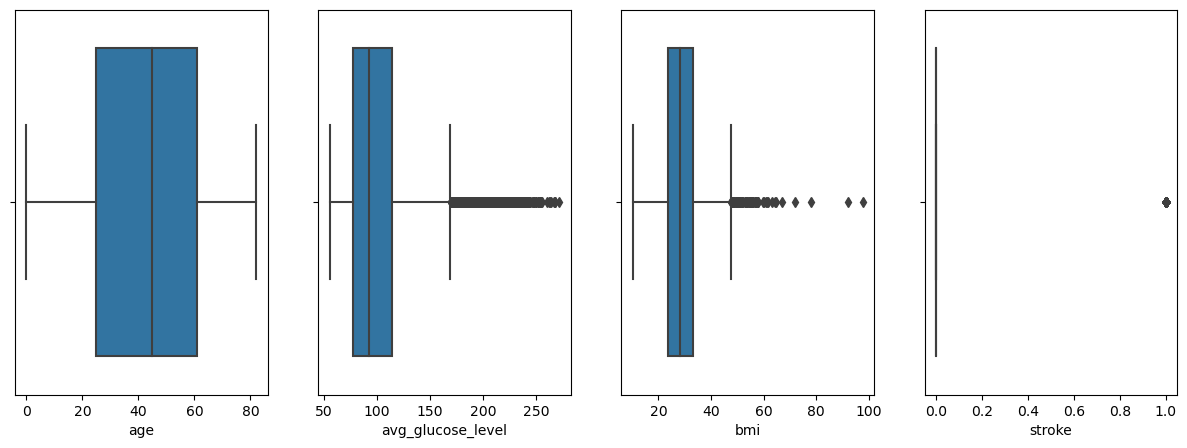

In [359]:
num_cols = stroke_eda.select_dtypes(include=['int', 'float']).columns

fig, ax = plt.subplots(1, len(num_cols), figsize=(15, 5))
for i in range(len(num_cols)):
    sns.boxplot(x=num_cols[i], data=stroke_eda, ax=ax[i])

There are some extreme values in glucose and bmi values. However, these extreme values are not unheard in real life. We won't be dropping these values. But extra steps will be taken to mark these extreme values later.

# Analysis

## Stroke

In order to predict stroke risk in a patient, we will use the historical data about patients who had a stroke. Let's understand the dataset by looking at the distribution of individuals who had a stroke before.

[Text(0, 0, '3888'), Text(0, 0, '199')]

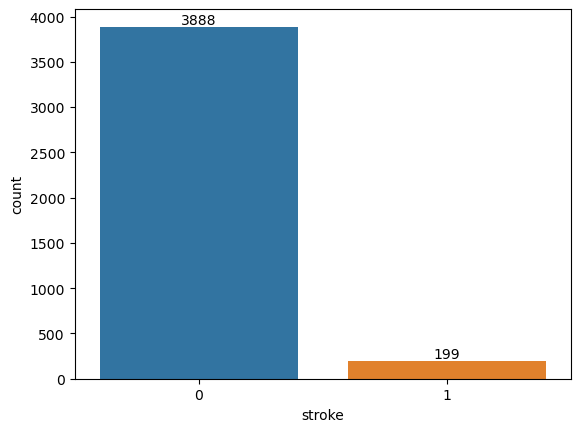

In [360]:
fig, ax = plt.subplots()
sns.countplot(x='stroke', data=stroke_eda, ax=ax)
ax.bar_label(ax.containers[0])

We don't expect to meet a lot of people who had a stroke in our daily lives. The graph shows that while 3889 people in this dataset had never had a stroke, 199 people had a stroke experience.  Individuals who had a stroke constitute a small minority in this dataset. The results are comparable to what we assumed. 

However, this shows an important aspect that we should consider with care. The target feature that we want to predict is imbalanced. This finding requires us to approach the classification problem with a special attitude. In order to have a reliable model, we will try appropriate measures to counter this problem.

Males and females may have different characteristics in terms of health. In order to see such a distinction exists in terms of stroke risk, we will take a closer look at stroke data with respect to gender. Before moving on let's see how different genders are represented in this dataset.

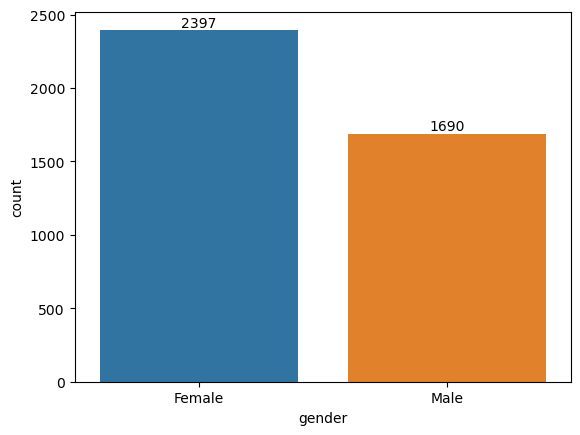

In [361]:
fig, ax = plt.subplots()
sns.countplot(x='gender', data=stroke_eda)
ax.bar_label(ax.containers[0])
plt.show()

The gender representation in this dataset is more biased towards females. Although the difference is not dramatically high, males are represented less in the dataset. On the other hand, we can see that other genders are underrepresented, with only one individual defining their gender as other. 

Let's now go back to the data about stroke. We will see this data with a comparison of different genders.

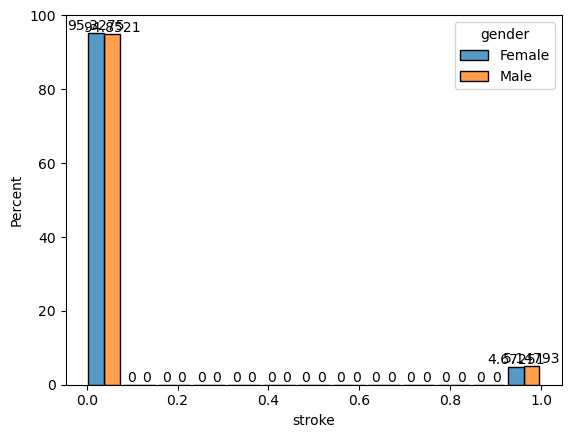

In [362]:
fig, ax = plt.subplots()
sns.histplot(x='stroke', data=stroke_eda, ax=ax, hue='gender', stat='percent',
             shrink=0.9, multiple='dodge', common_norm=False)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

Compared to the previous graph, the distribution of people from different genders who had not had a stroke look similar to the overall distribution of genders. 56% of all people in this dataset were female and never had a stroke. Males who had never had a stroke represent the 39% of all people. However, for those who had a stroke, the ratio of men seem to jump to rise to a level very close to females. Around 2.7% percent of people were female and had a stroke. Those who are male and had a stroke are 2.12% of all people in this dataset. There is a clear difference here. Even though they were the minority in this dataset, they have a very close ratio to females who had a stroke. Males seem to have a higher chance of stroke than females. 

Another important factor that should be considered in health is age. It is common knowledge that as a person ages, the health issues are bound to start appearing. We will see if that is the case in terms of stroke. Before moving on, let's see how different age groups are represented in this dataset.

<AxesSubplot:xlabel='age', ylabel='Count'>

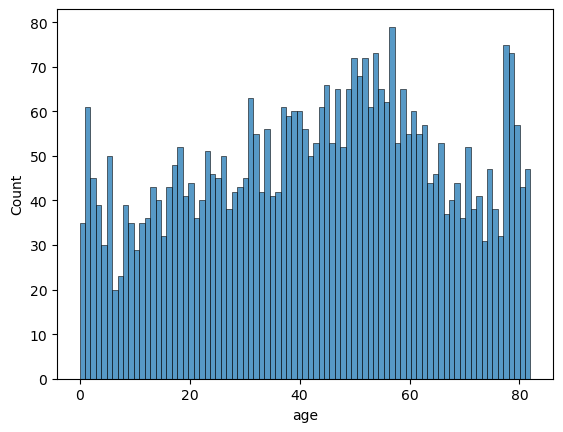

In [363]:
sns.histplot(x='age', data=stroke_eda, bins=83)

In [364]:
print(stroke_eda['age'].mean())
print(stroke_eda['age'].median())
print(stroke_eda['age'].std())

43.247369708832885
45.0
22.6646523961643


The distribution of age is slightly right skewed. That means that we see more people with higher ages than 40 those who are younger than 40. However, the other side of the distribution is not completely empty. There are still many values representing young population. The mean age of this dataset is 43, which is around the halfway of the range we see in this dataset, which are 0-82. 

Another important insight here is that, we see the most number of people at extreme ages. The high representation of these two extreme value may need further investigation, as they may come from data errors. An explaination for this could be that when babies are born, their data are immediately collected. For old people, it can be speculated that they are more likely to be constantly in check with a hospital, so that their data are more constantly collected. 

Before moving on, let's verify the data to see whether the low ages actually denotes a baby's age.

In [365]:
baby = stroke_eda['age'] <= 5
assert (stroke_eda.loc[baby, 'work_type'] == 'children').all()

When we verify with another column of this dataset, we see that it confirms that the suspected range of age is actually about babies. 

Let's now go back and compare age values for people who had had a stroke before. 

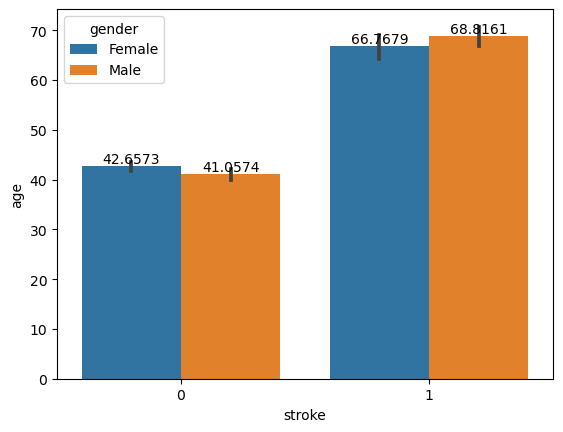

In [366]:
fig, ax = plt.subplots()
sns.barplot(x='stroke', y='age', data=stroke_eda, hue='gender')
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

Age seem to have a dramatic effect when we consider the risk of stroke. Average age of people who had not had a stroke before seem close to the average age of the dataset for both males and females. However, when we check the average age again for those who had had a stroke, the difference is visible. For females the value was 67, and, for males it was 69. This shows us clearly that old age is a contributing factor to stroke risk. 

## Heart Disease

CDC mentions that common heart diseases [increases](https://www.cdc.gov/stroke/risk_factors.htm#:~:text=Heart%20disease,rich%20blood%20to%20the%20brain.) the risk of stroke. Some diseases may decrease the oxygen rich blood flow to the brain. Others may cause blood clots. Whatever the case, heart diseases may be able to help our model understand stroke better. 

Let's first check how many people in this dataset have some kind of heart disease.

<AxesSubplot:xlabel='heart_disease', ylabel='count'>

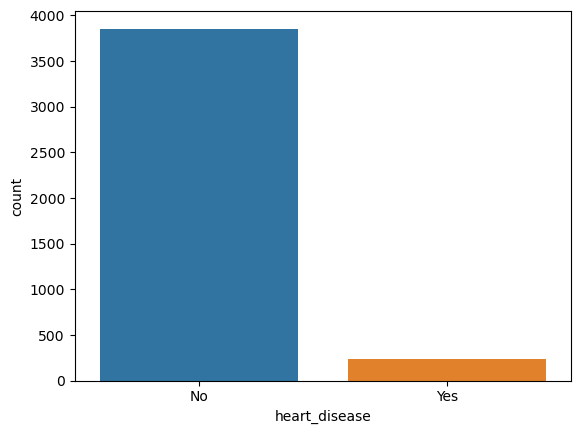

In [367]:
sns.countplot(x='heart_disease', data=stroke_eda)

As expected most people whose data were collected do not have any heart diseases. We are interested in those who has a heart diseases to see whether they have a higher chance of stroke.

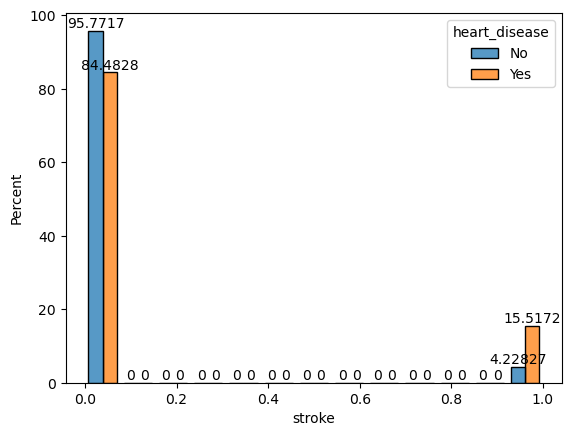

In [368]:
fig, ax = plt.subplots()
sns.histplot(x='stroke', data=stroke_eda, ax=ax, hue='heart_disease', stat='percent',
            shrink=0.8, multiple='dodge', common_norm=False)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

16% of all people who do have a heart disease had a stroke. This value is higher than the value for those who do not have a heart disease and had a stroke. It looks like people with heart diseases have a higher risk of stroke. However, on the left side we see that the majority of people who has a heart disease had not had a stroke before. This means that while heart diseases are a driving factor for strokes, they do not necessarily result in a stroke in all cases. 

Let's now check the background of those who have a heart disease. It is widely known that smoking causes heart diseases. We will check if that assumption is true in this dataset.

<AxesSubplot:xlabel='smoking_status', ylabel='count'>

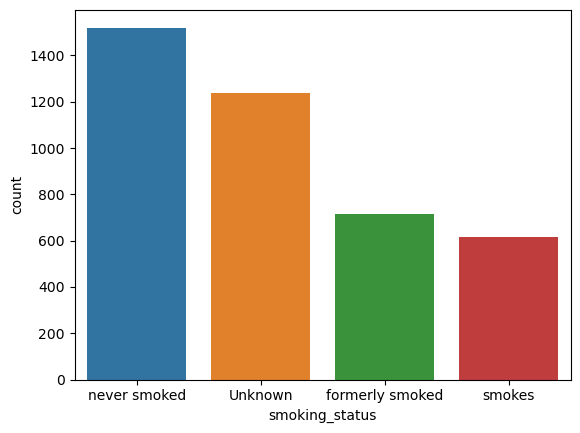

In [369]:
sns.countplot(x='smoking_status', data=stroke_eda)

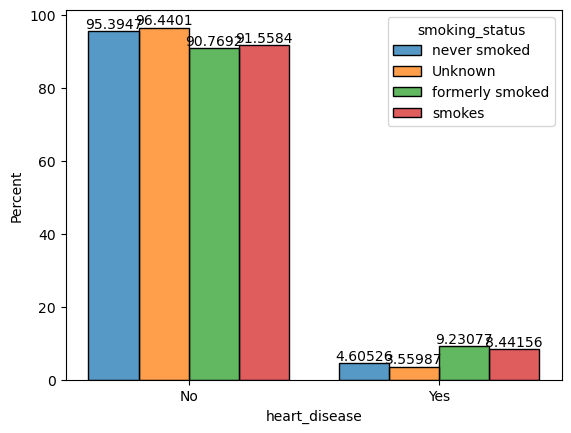

In [370]:
fig, ax = plt.subplots()
sns.histplot(x='heart_disease', data=stroke_eda, ax=ax, hue='smoking_status', stat='percent',
             shrink=0.8, multiple='dodge', common_norm=False)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

Smoking status is denoted by four categories in this dataset. In addition to those who never smoked, smoked and formerly smoked, we have a category with a label 'Unknown'. This may represent those who did not answer the question or the data may not be available for these individuals.

For all cases, the majority of people did not have a heart disease. However when we look at those who have a heart disease, we can see that smokers and former smokers have a higher chance of heart diseases. 7% of those who smoke have a heart disease. Also 8% of individuals who smoked before have a heart disease. It is interesting to see that the latter group has a higher ratio of heart diseases. This could be due to higher or lower representation in either group, hence the difference in ratios of heart diseases.

## BMI

BMI or Body Mass Index describes the body fat based on height and weight of a person. The feature on its own may tell a good deal about the health of a patient, as high and low values in this feature communicate whether a patient is underweight, obese, or in a healthy weight. Typically a healthy person stands in the range of 18.5 to 24.9.

BMI is also one of the features that we want to predict in this project. So we will take a closer look at it on its own and in terms of its relationship to other characteristics of different patients.

<AxesSubplot:xlabel='bmi', ylabel='Count'>

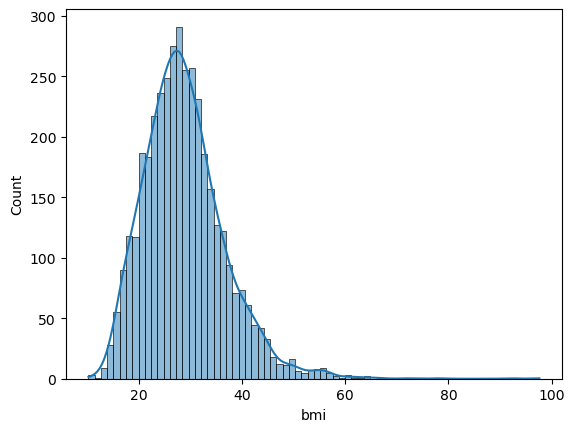

In [371]:
sns.histplot(x='bmi', data=stroke_eda, kde=True)

In [372]:
print(stroke_eda['bmi'].mean())
print(stroke_eda['bmi'].median())
print(stroke_eda['bmi'].std())

28.88195718654434
28.1
7.895163233913356


Disregarding the long tail on right, we see that the values on the left build a normal distribution, which is fitting for a sample of this size. The values on the long tail, while not unheard of, are very rare to encounter in daily life. We will later handle these values when fitting a model.

Most people have around 28 BMI, which is a high value for a healthy person. This value is not however unexpected, as obesity is a common problem. 

Let's go back to heart diseases for a moment and see whether different weight types have relationship with heart diseases. 

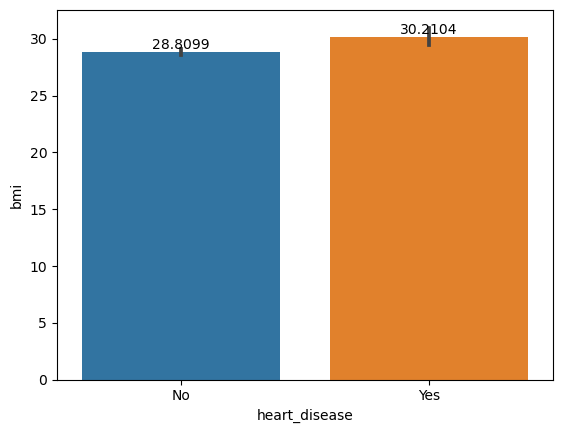

In [373]:
fig, ax = plt.subplots()
sns.barplot(x='heart_disease', y='bmi', data=stroke_eda)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

On average, people with a heart disease tend to have a higher bmi than those who do not. This may indicate that overweight people are more vulnerable to heart diseases. If that is true, this would be a very useful information for our case, as we already know that there is a relationship between heart diseases and strokes. 

We see that the average bmi values are very close between the groups of those who do not have a heart disease and those who have. In order to check the distinction, we will conduct a hypothesis test.

# Hypothesis test

Obesity may also have direct impact on strokes. [Studies](https://ochsnerlg.org/about-us/news/how-obesity-affects-stroke-risk) suggest that each unit increase in BMI increases the risk of strokes by 5 percent. Let's now take a closer look at this relationship to see if that assumption is true for our dataset.  

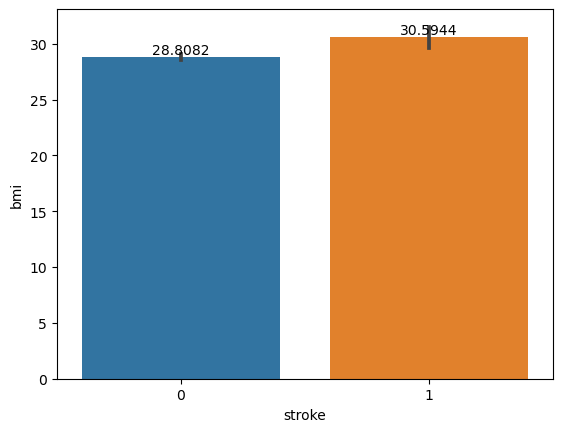

In [374]:
fig, ax = plt.subplots()
sns.barplot(x='stroke', y='bmi', data=stroke_eda)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

The average bmi values for both cases, namely people who had not had a stroke and people who had had a stroke, look very similar to those with and without a heart disease. It looks like bmi of around 30 may be a dangerous value, which may lead to problems like stroke and heart disease. But what does it look when a patient has both?

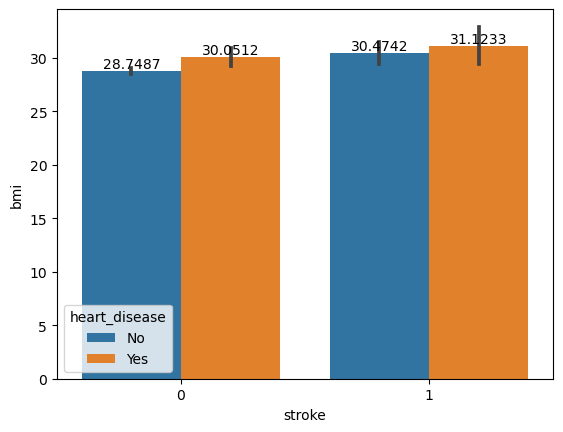

In [375]:
fig, ax = plt.subplots()
sns.barplot(x='stroke', y='bmi', data=stroke_eda, hue='heart_disease')
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

When a patient has a heart disease and had a stroke, the average bmi value for those individuals seem to be higher than individual cases. It should be noted here that, this group has a large error bar, which indicates a less confidence in our average value. 

Overall, we understand from the graphs that bmi has a direct or indirect affect on other health conditions such as heart diseases and strokes. It should come as no surprise, as it is common knowledge that obese individuals are more prone to health complications.

## Hypertension

[Blood pressure](https://www.cdc.gov/bloodpressure/about.htm) is the pressure of blood pushing against the walls of arteries. Arteries carry blood from heart to other parts of the body.

High blood pressure, also called hypertension, is the condition where blood pressure is higher than normal. This condition may lead to several health issues. In our case, we want to see if the presence of hypertension usually accompanied by other health condition of our interest, such as heart diseases and stroke.

<AxesSubplot:xlabel='hypertension', ylabel='count'>

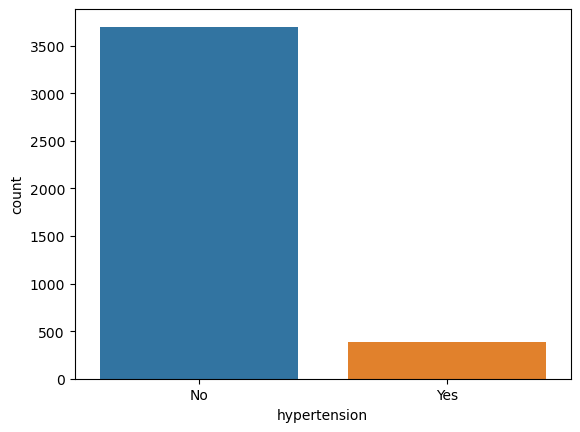

In [376]:
sns.countplot(x='hypertension', data=stroke_eda)

Individuals with a hypertension problem are the minority in our dataset. We will now check how hypertension relates to other conditions.

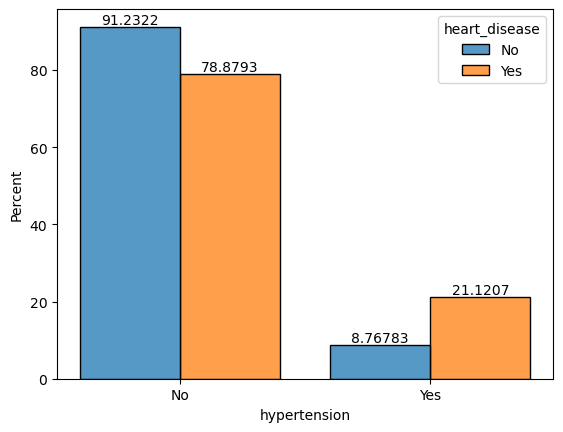

In [377]:
fig, ax = plt.subplots()
sns.histplot(x='hypertension', data=stroke_eda, ax=ax, hue='heart_disease', stat='percent',
             shrink=0.8, multiple='dodge', common_norm=False)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

Most people, whether with a heart condition or not, did not report hypertension. However, for those who did, we see that 21 percent of people who has a heart disease also has hypertension. This is higher than the value of 9 percent for the group which represents those without a heart disease and had a hypertension. So, it looks like people with a heart disease may be more likely to also have hypertension. Perhaps unhealthy blood pressure levels are a cause for heart diseases.

Let's now look at the relationship between hypertension and strokes.

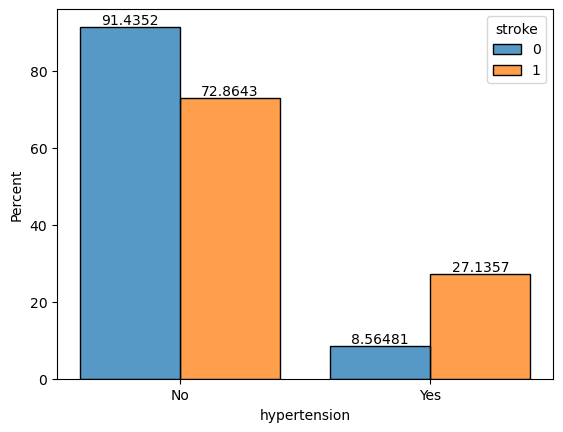

In [378]:
fig, ax = plt.subplots()
sns.histplot(x='hypertension', data=stroke_eda, ax=ax, hue='stroke', stat='percent',
             shrink=0.8, multiple='dodge', common_norm=False)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

We now see a more dramatic difference between groups. Again the majority of people whether with had a stroke or not, did not report a hypertension problem. The important insight lies in the left sight of this graph. 27 percent of individuals who has a hypertension problem had experienced a stroke. This shows a clear relationship between these two conditions.

We have seen that hypertension is often accompanied with other health problems. These conditions may be a direct result of hypertension, or they may be the side effects of the conditions hypertension causes. 

But what causes hypertension? Let's look at some data that may be related to this condition.

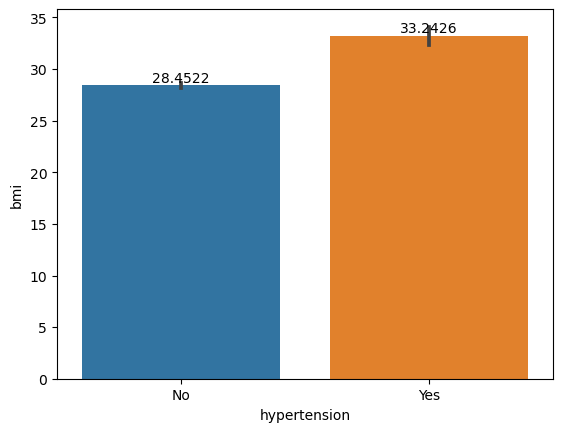

In [379]:
fig, ax = plt.subplots()
sns.barplot(x='hypertension', y='bmi', data=stroke_eda)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

The comparisons with bmi seem to follow a pattern with different health conditions. Hypertension is no different. We see here that individuals with hypertension tend to have a much higher bmi. The average value we see is in the range of obesity, which is 33. It looks like overweight individuals may be more prone to hypertension and as a result to other conditions such as heart diseases and strokes. 

We suspect that smoking could also could be a factor that lead to hypertension. Let's check this assumption.

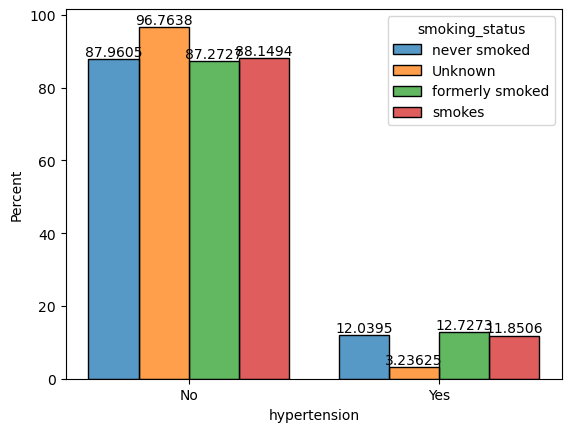

In [380]:
fig, ax = plt.subplots()
sns.histplot(x='hypertension', data=stroke_eda, ax=ax, hue='smoking_status', stat='percent',
            shrink=0.8, multiple='dodge', common_norm=False)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

For most different smoking habits, the results seem very similar. There may not be enough evidence to say that smokers or non-smokers are more prone to hypertension. There is one surprising insight here though. We see that those whose preference are not known tend to have much lower ratio for hypertension. Perhaps these people are special in some other way that they often do not have any hypertension problem.

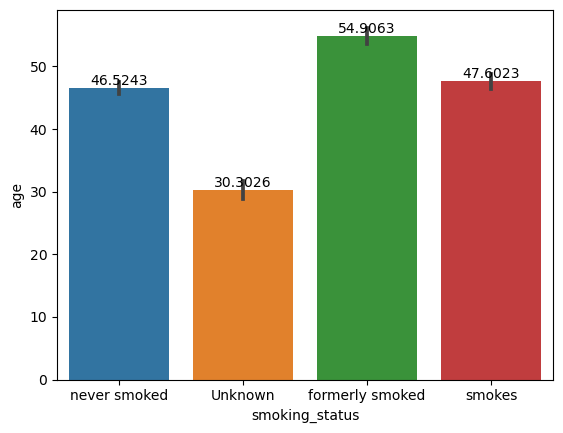

In [381]:
fig, ax = plt.subplots()
sns.barplot(x='smoking_status', y='age', data=stroke_eda)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

The people whose smoking habits are much younger on average. Perhaps this group is mostly consisted of children and simply they may not be asked about their smoking habits.

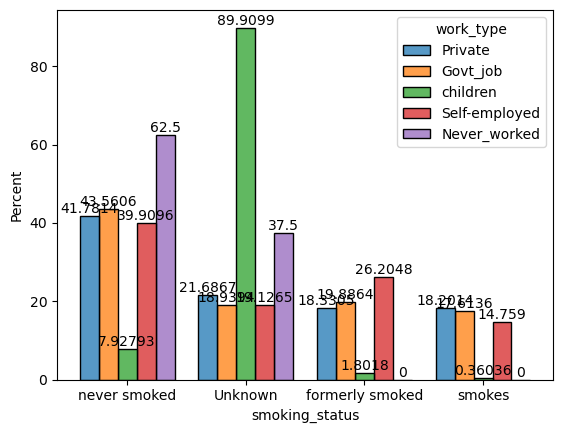

In [382]:
fig, ax = plt.subplots()
sns.histplot(x='smoking_status', data=stroke_eda, ax=ax, hue='work_type', stat='percent',
            shrink=0.8, multiple='dodge', common_norm=False)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

Our assumption was true. 90 percent of children's smoking preferences are simply encoded as unknown. There may be a couple reasons behind that. But what is important is we now know a characteristic behind this group called unknown. We have also discovered that younger people may be less vulnerable to hypertension problem. Let's confirm this as the last step here.

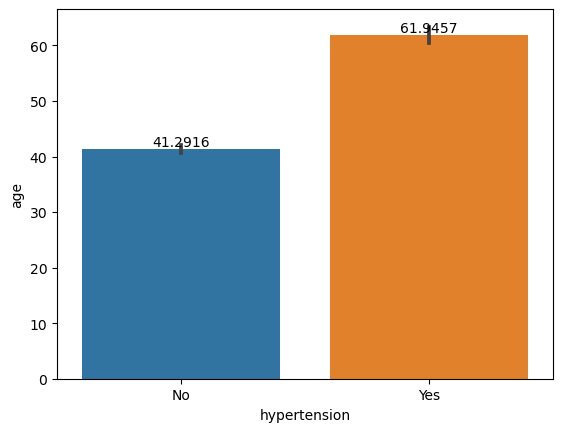

In [383]:
fig, ax = plt.subplots()
sns.barplot(x='hypertension', y='age', data=stroke_eda)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

As assumed, individuals with hypertension tend to be older with an average age of 62. This is a clear difference when compared to those without hypertension, which averaged 41 years. This value is also very similar to the average age of the dataset. From here we can understand that as people get older, blood pressure also increases.

## Glucose

Glucose, also called blood sugar, is the main sugar found in [blood](https://medlineplus.gov/bloodsugar.html). This is the main form of energy that is used by the body to perform tasks. While glucose is needed, it can be dangerous in high or low levels. In very high levels, the condition is called diabetes. Individuals with diabetes are twice as more likely to have a [stroke](https://www.stroke.org/en/about-stroke/stroke-risk-factors/diabetes-and-stroke-prevention). 

Understanding glucose levels seem to be very important to predict other health conditions such as stroke. In our case, we won't be labelling any patient with diabetes, as we are not medical practitioners. However, we will label the names for very high and low blood sugar levels without diagnosing any conditions. When blood sugar level is higher than 200, this condition is called Hyperglycemia. When the level drops lower than 70, this is called Hypoglycemia. 

We want to understand how glucose levels are related to other conditions. Let's first look at the distribution of glucose in our dataset.

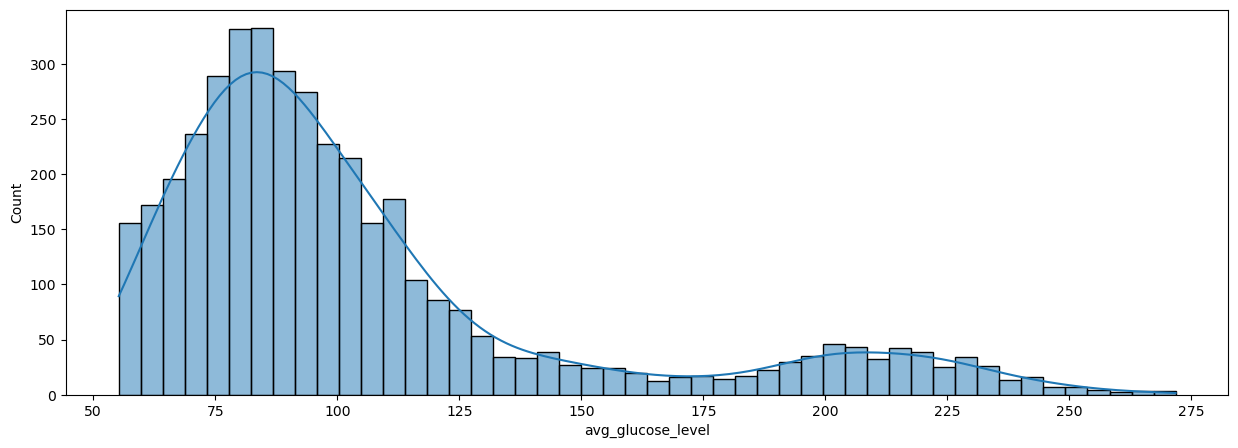

In [384]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(x='avg_glucose_level', data=stroke_eda, kde=True)
ax.set_xticks(np.arange(50, 300, 25))
plt.show()

We see two peaks in our distribution of average glucose levels. The first one seem to be centered around healthy values which ranges between 75 to 100. The other small peak is around high blood sugar levels which are higher than 200, which indicates a condition called hyperglycemia. The individuals in the second peak may or may not be suffering from diabetes. Overall, we understand that the distributions represent a wide variety of glucose levels. 

Now let's take a look at different features that could be contributing to glucose levels.

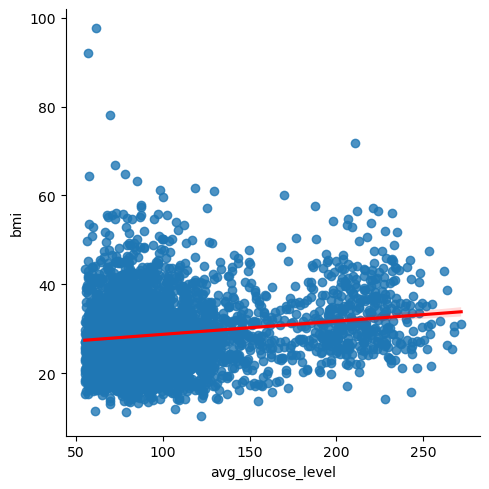

In [385]:
sns.lmplot(x='avg_glucose_level', y='bmi', data=stroke_eda, line_kws={'color': 'red'})

In [386]:
stroke_eda['avg_glucose_level'].corr(stroke_eda[stroke_eda['bmi'] < 50]['bmi'])

0.17268777767486926

When we compare the glucose levels to bmi, we see a weak correlation between these two values. In some cases we expect the individuals with high bmis to have a higher average glucose level. This means that people suffering from obesity may be more likely to have high sugar levels in their blood. 

Now let's see what different blood sugar levels mean for our case. We want to see whether these levels have any affect on a patient's risk of having a stroke and heart disease.

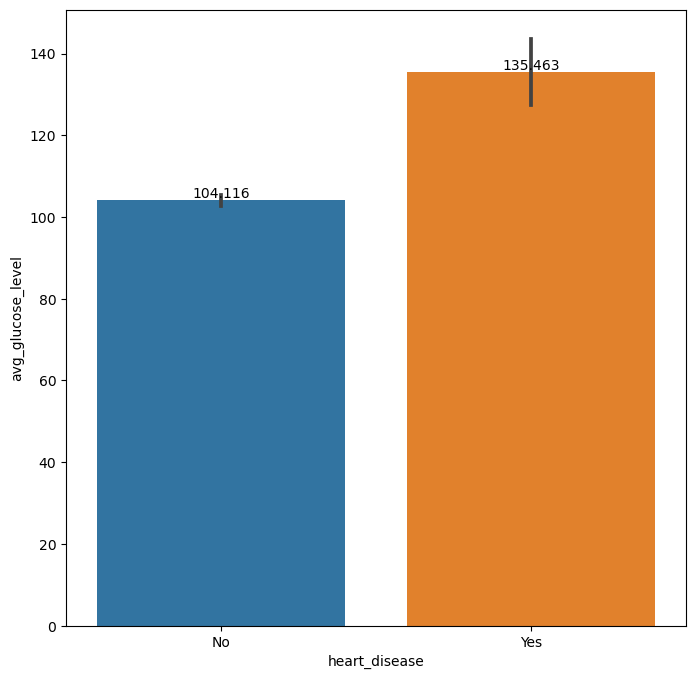

In [387]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x='heart_disease', y='avg_glucose_level', data=stroke_eda)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

The graph shows that on average people with heart diseases had a much higher level of average blood sugar. High glucose may or may not be directly related to heart problems. But the difference between groups is important for our case, as we have already found out that heart diseases are a good indicator about stroke risk. 

Let's now look at the direct relationship between glucose levels and stroke risk.

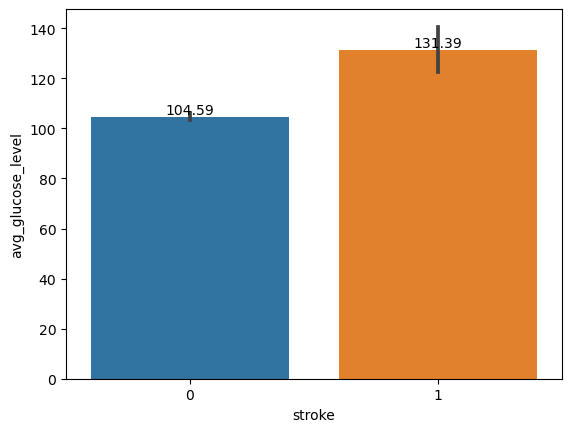

In [388]:
fig, ax = plt.subplots()
sns.barplot(x='stroke', y='avg_glucose_level', data=stroke_eda)
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

Individuals who had had a stroke before has a much higher average glucose levels. This shows that the presence of high levels of blood sugar may be related to stroke. This may also suggest a relationship between diabetes and strokes. 

<AxesSubplot:>

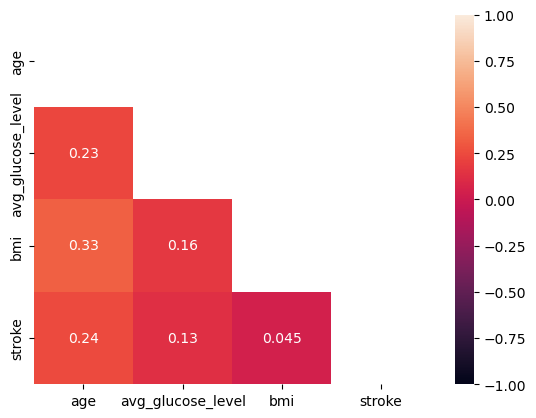

In [389]:
fig, ax = plt.subplots()
mask = np.triu(np.ones_like(stroke_eda.corr()))
sns.heatmap(stroke_eda.corr(), annot=True, ax=ax, vmax=1, vmin=-1, mask=mask)

Correlations that the denote the relationships between numerical columns confirm what we have seen in our data discovery. 

The strongest relationship here is between bmi and age. This means that as a person grows in age, they may have a higher bmi. We have found out that higher bmis usually followed with health problems. In our case this information is quite useful. Also, older ages seem to have a bit higher glucose levels, which also has a relationship with other health problems. It looks like age has an indirect effect on some health problems.

Lastly, we see that there is a small relationship between bmi and glucose levels. As suggested before, this may mean that on certain cases overweight people may have higher glucose levels.

<AxesSubplot:>

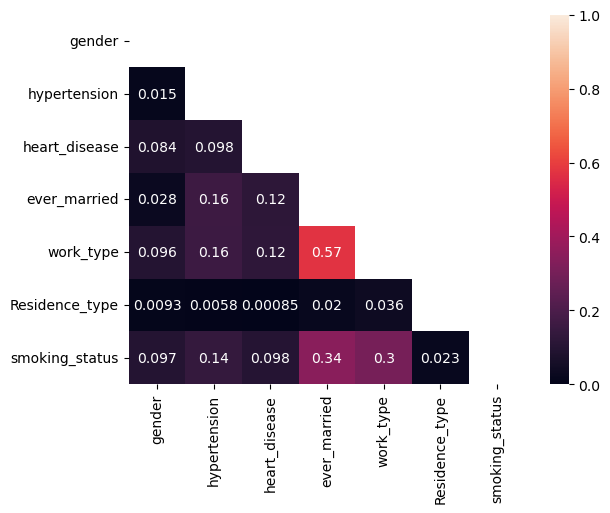

In [390]:
cat_stroke = stroke_eda.apply(
        lambda x: x.astype("category") if x.dtype == "O" else x)

cramersv = am.CramersV(cat_stroke) 
mask = np.triu(np.ones_like(cramersv.fit()))
sns.heatmap(cramersv.fit(), annot=True, vmax=1, vmin=0, mask=mask)

Most categorical features do not have a strong relationship. However, there are some relationships that is important to note.

Work type and ever married status have the strongest relationship here. This makes sense as we know that work type includes the category children, and we don't expect those individuals to be married. So the relationship may be about this. The same can be said about work type vs. smoking status. Most children were reported as unknown on their smoking status, this could be the relationship this graph is capturing. 

It may also be the same case with ever married status and smoking status. However, this could also suggest a relationship between married people and smoking habits.  

## Summary

# Machine Learning Models

## Pipeline

In [391]:
def make_preprocessor(data, scaler=True):
    cat_cols = data.select_dtypes(include=['object', 'category']).columns
    num_cols = data.select_dtypes(include=['int', 'float']).columns

    if scaler == True:
        num_pipe = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())
        ])
    else:
        num_pipe = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean'))
        ])
    cat_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')
         ), ('encoder', OneHotEncoder(drop='first'))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', num_pipe, num_cols), ('categorical', cat_pipe, cat_cols)
        ])
    return preprocessor

In [429]:
def cross_validate_model(classifiers, X_train=X_train, y_train=y_train, pipeline=True):
    score_table = pd.DataFrame()

    if pipeline == True:
        for i in range(len(classifiers)):
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor), ('classifier', classifiers[i])])

            model = pipeline.fit(X_train, y_train)
            predictions = model.predict(X_train)
            pred_proba = model.predict_proba(X_train)

            score_table.loc[i, 'model'] = str(classifiers[i])
            score_table.loc[i, 'train_accuracy'] = accuracy_score(
                y_train, predictions)
            score_table.loc[i, 'train_recall'] = recall_score(
                y_train, predictions, zero_division=False)
            score_table.loc[i, 'train_precision'] = precision_score(
                y_train, predictions, zero_division=False)
            score_table.loc[i, 'train_log_loss'] = log_loss(y_train, pred_proba, normalize=True)
            kfold = RepeatedStratifiedKFold(
                n_splits=10, n_repeats=3, random_state=1)
            cv = cross_validate(pipeline, X_train, y=y_train, cv=kfold, scoring=['accuracy',
                                                                                 'recall',
                                                                                 'precision', 'f1', 'neg_log_loss',
                                                                                 'roc_auc'
                                                                                 ])
            for j in cv.keys():
                score_table.loc[i, j] = np.nanmean(cv[j])
                score_table.loc[i, f'{j}_std'] = np.std(cv[j])

    else:
        for i in range(len(classifiers)):
            model = classifiers[i]
            model.fit(X_train, y_train)
            predictions = model.predict(X_train)
            pred_proba = model.predict_proba(X_train)

            score_table.loc[i, 'model'] = str(classifiers[i])
            score_table.loc[i, 'train_accuracy'] = accuracy_score(
                y_train, predictions)
            score_table.loc[i, 'train_recall'] = recall_score(
                y_train, predictions, zero_division=False)
            score_table.loc[i, 'train_precision'] = precision_score(
                y_train, predictions, zero_division=False)
            score_table.loc[i, 'train_log_loss'] = log_loss(y_train, pred_proba, normalize=True)
            kfold = RepeatedStratifiedKFold(
                n_splits=10, n_repeats=3, random_state=1)
            cv = cross_validate(model, X_train, y=y_train, cv=kfold, scoring=['accuracy',
                                                                              'recall',
                                                                              'precision', 
                                                                              'f1', 'neg_log_loss', 'roc_auc'
                                                                              ])
            for j in cv.keys():
                score_table.loc[i, j] = np.nanmean(cv[j])
                score_table.loc[i, f'{j}_std'] = np.std(cv[j])

    return score_table

## Stroke Prediction

### Simple Models

In [393]:
classifiers = [LogisticRegression(random_state=1, class_weight='balanced'),
               SVC(random_state=1, class_weight='balanced', probability=True), DecisionTreeClassifier(
                   random_state=1, class_weight='balanced'),
               GaussianNB(), KNeighborsClassifier()]

In [394]:
preprocessor = make_preprocessor(X_train)

In [395]:
cross_val = cross_validate_model(classifiers, pipeline=True)
cross_val.style.background_gradient(cmap='Reds')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [396]:
classifiers = [LogisticRegression(random_state=1, class_weight='balanced', C=0.5),
               SVC(random_state=1, class_weight='balanced', C=0.5, probability=True), DecisionTreeClassifier(
                   random_state=1, class_weight='balanced', max_depth=3, ccp_alpha=0.05),
               GaussianNB(), KNeighborsClassifier()]

In [397]:
cross_val = cross_validate_model(classifiers)
cross_val.style.background_gradient(cmap='Reds')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


### Simple Models with Sampling

In [453]:
preprocessor = make_preprocessor(X_train)

In [454]:
X_train_sampled = preprocessor.fit_transform(X_train)

In [455]:
over = SMOTE(sampling_strategy=0.12)
under = RandomUnderSampler(sampling_strategy=0.12)
steps = [('o', over), ('u', under)]
smote_pipeline = SMOTEPipeline(steps=steps)
X_train_sampled, y_train_sampled = smote_pipeline.fit_resample(X_train_sampled, y_train)

In [456]:
preprocessor_alt = make_preprocessor(X_train, scaler=False)
X_train_sampled_unscaled = preprocessor_alt.fit_transform(X_train)

In [457]:
X_train_sampled_unscaled, y_train_sampled = smote_pipeline.fit_resample(X_train_sampled_unscaled, y_train)

In [458]:
pd.Series(y_train_sampled).value_counts()

0    3883
1     466
Name: stroke, dtype: int64

In [459]:
cat_col_names = preprocessor.transformers_[1][1]\
.named_steps['encoder'].get_feature_names_out()
col_names = ['Age', 'avg_glucose_level', 'bmi'] + list(cat_col_names)

In [460]:
X_train_sampled = pd.DataFrame(X_train_sampled, columns=col_names)
X_train_sampled_unscaled = pd.DataFrame(X_train_sampled_unscaled, columns=col_names)

In [461]:
classifiers = [LogisticRegression(random_state=1),
               SVC(random_state=1, probability=True), DecisionTreeClassifier(
                   random_state=1),
               GaussianNB(), KNeighborsClassifier()]

In [462]:
cross_val = cross_validate_model(classifiers, X_train_sampled, y_train=y_train_sampled, pipeline=False)
cross_val.style.background_gradient(cmap='Reds')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [463]:
classifiers = [LogisticRegression(random_state=1, class_weight='balanced', C=0.5),
               SVC(random_state=1, class_weight='balanced', C=0.5, probability=True), DecisionTreeClassifier(
                   random_state=1, class_weight='balanced', max_depth=3, ccp_alpha=0.05),
               GaussianNB(), KNeighborsClassifier(n_neighbors=2)]

In [464]:
cross_val = cross_validate_model(classifiers, X_train_sampled, y_train=y_train_sampled, pipeline=False)
cross_val.style.background_gradient(cmap='Reds')

### Ensemble Models

In [471]:
preprocessor = make_preprocessor(X_train, scaler=False)

In [472]:
ensemble = [RandomForestClassifier(random_state=42), AdaBoostClassifier(random_state=42),
            GradientBoostingClassifier(random_state=42)]

In [473]:
cross_val = cross_validate_model(classifiers=ensemble)
cross_val.style.background_gradient(cmap='Reds')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

In [474]:
ensemble = [RandomForestClassifier(random_state=42, max_depth=3,
                                   class_weight='balanced_subsample', ccp_alpha=0.01,
                                   max_leaf_nodes=10, max_features='log2'),
            AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced',
                                                      max_depth=1, max_features='log2',
                                                      max_leaf_nodes=10),
                               random_state=42, learning_rate=0.5),
            GradientBoostingClassifier(random_state=42, max_depth=3,
                                       learning_rate=0.1)]

In [475]:
cross_val = cross_validate_model(classifiers=ensemble)
cross_val.style.background_gradient(cmap='Reds')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


### Ensemble Models with Sampling

In [ ]:
ensemble = [RandomForestClassifier(random_state=42), AdaBoostClassifier(random_state=42),
            GradientBoostingClassifier(random_state=42)]

In [477]:
cross_val = cross_validate_model(
    ensemble, X_train_sampled_unscaled, y_train=y_train_sampled, pipeline=False)
cross_val.style.background_gradient(cmap='Reds')

In [478]:
ensemble = [RandomForestClassifier(random_state=42, max_depth=3,
                                   class_weight='balanced'),
            AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced',
                                                      max_depth=1),
                               random_state=42, learning_rate=0.5),
            GradientBoostingClassifier(random_state=42, max_depth=5,
                                       learning_rate=0.05)]

In [479]:
cross_val = cross_validate_model(
    ensemble, X_train_sampled_unscaled, y_train=y_train_sampled, pipeline=False)
cross_val.style.background_gradient(cmap='Reds')

### Gradient Boosting

In [486]:
preprocessor = make_preprocessor(X_train, scaler=False)

In [487]:
gradient = [XGBClassifier(random_state=42, verbosity=0, use_label_encoder=False),
            LGBMClassifier(random_state=42)]

In [488]:
cross_val = cross_validate_model(classifiers=gradient)
cross_val.style.background_gradient(cmap='Reds')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [489]:
cat_cols = list(X_train.select_dtypes(include=['object', 'category']).columns)

In [490]:
cross_val = cross_validate_model(classifiers=[CatBoostClassifier(verbose=False).fit(X_train, y_train, cat_features=cat_cols)])
cross_val.style.background_gradient(cmap='Reds')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [491]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [492]:
gradient = [XGBClassifier(random_state=42, verbosity=0, max_depth=2,
                          gamma=0.5, sample_weight=classes_weights, early_stopping_rounds=15),
            LGBMClassifier(random_state=42, max_depth=2, reg_alpha=0.5,
                           verbosity=0, class_weight='balanced', subsample=0.2),
            CatBoostClassifier(random_state=42, depth=2, verbose=False, auto_class_weights='Balanced', eta=0.05, early_stopping_rounds=15)]

In [493]:
cross_val = cross_validate_model(classifiers=gradient)
cross_val.style.background_gradient(cmap='Reds')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Precision is ill-defined and being set to 0.0 due to no predi

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [W

### Gradient Boosting with Sampling

In [494]:
gradient = [XGBClassifier(random_state=42, verbosity=0, use_label_encoder=False),
            LGBMClassifier(random_state=42, verbosity=0),
           CatBoostClassifier(random_state=42, verbose=False)]

In [495]:
cross_val = cross_validate_model(
    gradient, X_train_sampled_unscaled, y_train=y_train_sampled, pipeline=False)
cross_val.style.background_gradient(cmap='Reds')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with unde

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [496]:
gradient = [XGBClassifier(random_state=42, verbosity=0, max_depth=2,
                          gamma=0.5,
                          early_stopping_rounds=15, scale_pos_weight=10),
            CatBoostClassifier(random_state=42, depth=2,
                               verbose=False, early_stopping_rounds=15, scale_pos_weight=10)]

In [497]:
cross_val = cross_validate_model(
    gradient, X_train_sampled_unscaled, y_train=y_train_sampled, pipeline=False)
cross_val.style.background_gradient(cmap='Reds')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. T

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. T

### Voting Classifier

In [498]:
clf = VotingClassifier(estimators=[('cat', CatBoostClassifier(random_state=42, depth=2, verbose=False,
                                                              eta=0.05)),
                                   ('rf', RandomForestClassifier(
                                       random_state=42, max_depth=3, class_weight='balanced')),
                                   ('svc', SVC(
                                       random_state=1, class_weight='balanced', C=0.5, probability=True)),
                                   ('knn', KNeighborsClassifier(n_neighbors=2))],
                       voting='soft', n_jobs=-1)

In [499]:
cross_val = cross_validate_model(
    [clf], X_train_sampled_unscaled, y_train=y_train_sampled, pipeline=False)
cross_val.style.background_gradient(cmap='Reds')

/Users/fet/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/fet/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/fet/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/fet/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use panda

### Feature Engineering

In [500]:
def add_features(data):
    transformed_data = data.copy()
    bins = pd.IntervalIndex.from_tuples([(-1, 3), (3, 13), (13, 20),
                                        (20, 30), (30, 40), (40, 50),
                                        (50, 60), (60, 70), (70, 80),
                                        (80, 90), (90, 100)])
    transformed_data['age_bins'] = pd.cut(data['Age'].astype('int'), bins)
    transformed_data['age_bins'] = transformed_data['age_bins'].astype('object')
    
    hyperglycemia = data['avg_glucose_level'] >= 200
    hypoglycemia = data['avg_glucose_level'] < 70
    transformed_data.loc[hyperglycemia, 'glucose_condition'] = 'hyperglycemia'
    transformed_data.loc[hypoglycemia, 'glucose_condition'] = 'hypoglycemia'
    transformed_data.loc[(~hyperglycemia) & (~hypoglycemia), 'glucose_condition'] = 'normal'
     
    bmi_bins = pd.IntervalIndex.from_tuples([(0, 18.5), (18.5, 25), (25, 30),
                                        (30, 40), (40, 60), (60, np.inf)])
    weight_labels = ['Underweight', 'Healthy', 'Overweight', 'Obese', 'Severely Obese', 'Extreme Values']
    transformed_data['weight_cats'] = pd.cut(data['bmi'], bmi_bins).map(dict(zip(bmi_bins, weight_labels)))
    
    return transformed_data

In [744]:
X_train_sampled_ft = add_features(X_train_sampled_unscaled)

In [745]:
X_train_sampled_ft = pd.get_dummies(X_train_sampled_ft)

In [746]:
X_train_sampled_ft.columns = X_train_sampled_ft.columns.str.replace(r'[\(\)\[\]\<\>]', '')
X_train_sampled_ft.columns = X_train_sampled_ft.columns.str.replace(',', '')

The default value of regex will change from True to False in a future version.


In [747]:
pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [748]:
best_models = [XGBClassifier(random_state=42, verbosity=0,
                          reg_alpha=0.5,
                          early_stopping_rounds=15, scale_pos_weight=pos_weight, max_depth=3),
            LGBMClassifier(random_state=42, max_depth=3, reg_alpha=5,
                           verbosity=0, scale_pos_weight=pos_weight,
                           force_row_wise=True),
            CatBoostClassifier(random_state=42,l2_leaf_reg=5, learning_rate=0.02,
                               verbose=False, early_stopping_rounds=15,
                               scale_pos_weight=pos_weight, random_strength=10, max_depth=3)]

In [749]:
cross_val_ref = cross_validate_model(
    best_models, X_train_sampled_unscaled, y_train=y_train_sampled, pipeline=False)
cross_val_ref.style.background_gradient(cmap='Reds')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. T

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. T

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Find

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [750]:
cross_val_ft_1 = cross_validate_model(
    best_models, X_train_sampled_ft, y_train=y_train_sampled, pipeline=False)
cross_val_ft_1.style.background_gradient(cmap='Reds')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. T

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. T

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=15,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0.5, reg_lambda=1,
              scale_pos_weight=19.551724137931036, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


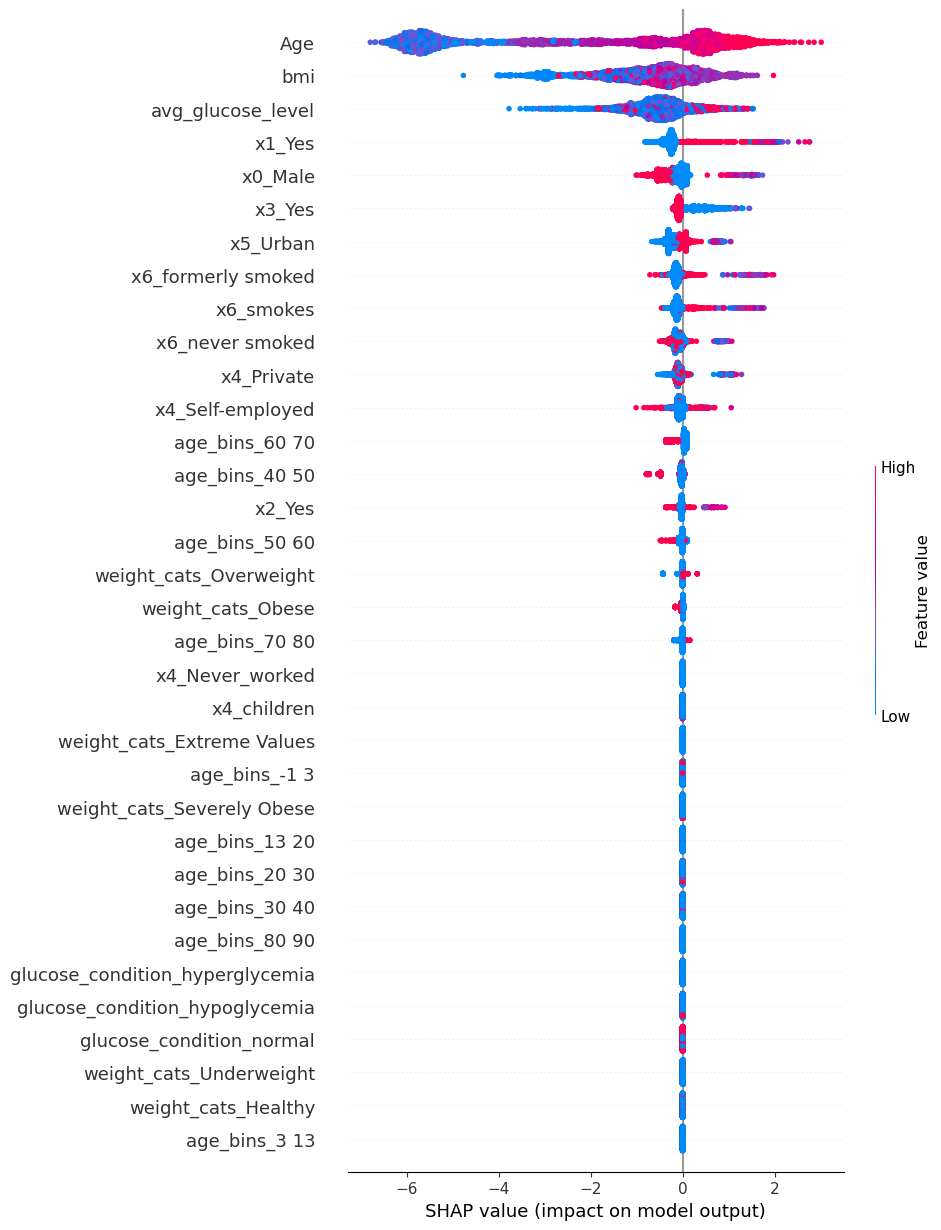

In [751]:
model = best_models[0]
print(model)
model.fit(X_train_sampled_ft, y_train_sampled)
shap_values = shap.TreeExplainer(
    model, feature_names=X_train_sampled_ft.columns).shap_values(X_train_sampled_ft)
shap.summary_plot(shap_values, X_train_sampled_ft, feature_names=X_train_sampled_ft.columns, max_display=50)

In [752]:
vals = np.abs(shap_values).mean(0)
feature_importance_xgb = pd.DataFrame(list(zip(X_train_sampled_ft.columns, vals)),
                                      columns=['col_name', 'feature_importance_vals'])
feature_importance_xgb.sort_values(
    by=['feature_importance_vals'], inplace=True)
feats_drop_xgb = list(
    feature_importance_xgb.loc[feature_importance_xgb['feature_importance_vals'] <= 0.01, 'col_name'])

In [753]:
feats_drop_xgb

['age_bins_3 13',
 'weight_cats_Healthy',
 'weight_cats_Underweight',
 'glucose_condition_normal',
 'glucose_condition_hypoglycemia',
 'glucose_condition_hyperglycemia',
 'age_bins_80 90',
 'age_bins_30 40',
 'age_bins_20 30',
 'age_bins_13 20',
 'weight_cats_Severely Obese',
 'age_bins_-1 3',
 'weight_cats_Extreme Values',
 'x4_children',
 'x4_Never_worked']

LGBMClassifier(force_row_wise=True, max_depth=3, random_state=42, reg_alpha=5,
               scale_pos_weight=19.551724137931036, verbosity=0)
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


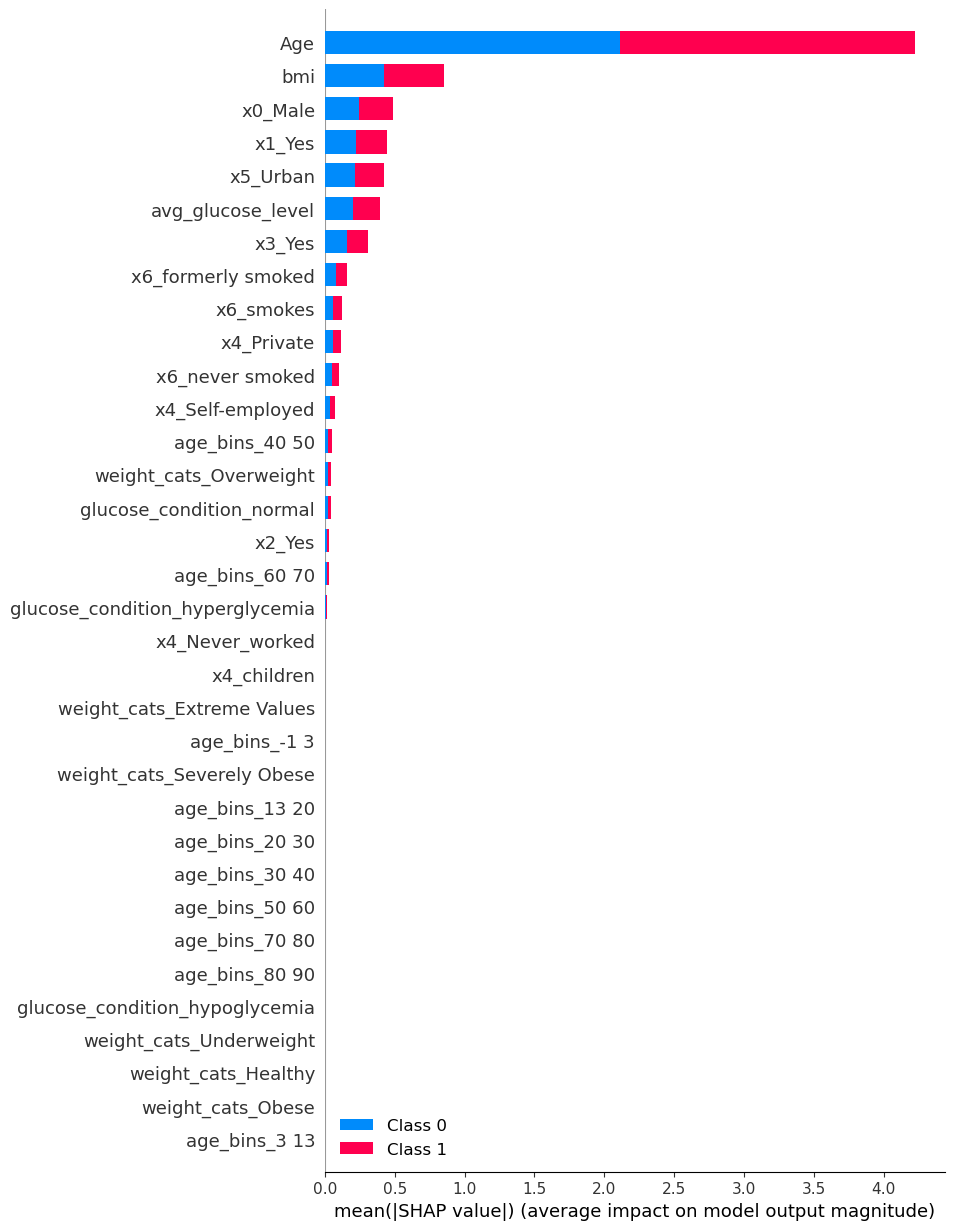

In [754]:
model = best_models[1]
print(model)
model.fit(X_train_sampled_ft, y_train_sampled)
shap_values = shap.TreeExplainer(
    model, feature_names=X_train_sampled_ft.columns).shap_values(X_train_sampled_ft)
shap.summary_plot(shap_values, X_train_sampled_ft,
                  feature_names=X_train_sampled_ft.columns, max_display=50)

In [755]:
vals = np.abs(shap_values).mean(0)
feature_importance_light = pd.DataFrame(list(zip(X_train_sampled_ft.columns, sum(vals))),
                                  columns=['col_name', 'feature_importance_vals'])
feature_importance_light.sort_values(by=['feature_importance_vals'],inplace=True)
feats_drop_light = list(feature_importance_light.loc[feature_importance_light['feature_importance_vals'] <= 0.01, 'col_name'])

In [756]:
feats_drop_light

['age_bins_3 13',
 'weight_cats_Obese',
 'weight_cats_Healthy',
 'weight_cats_Underweight',
 'glucose_condition_hypoglycemia',
 'age_bins_80 90',
 'age_bins_70 80',
 'age_bins_50 60',
 'age_bins_30 40',
 'age_bins_20 30',
 'age_bins_13 20',
 'weight_cats_Severely Obese',
 'age_bins_-1 3',
 'weight_cats_Extreme Values',
 'x4_children',
 'x4_Never_worked']

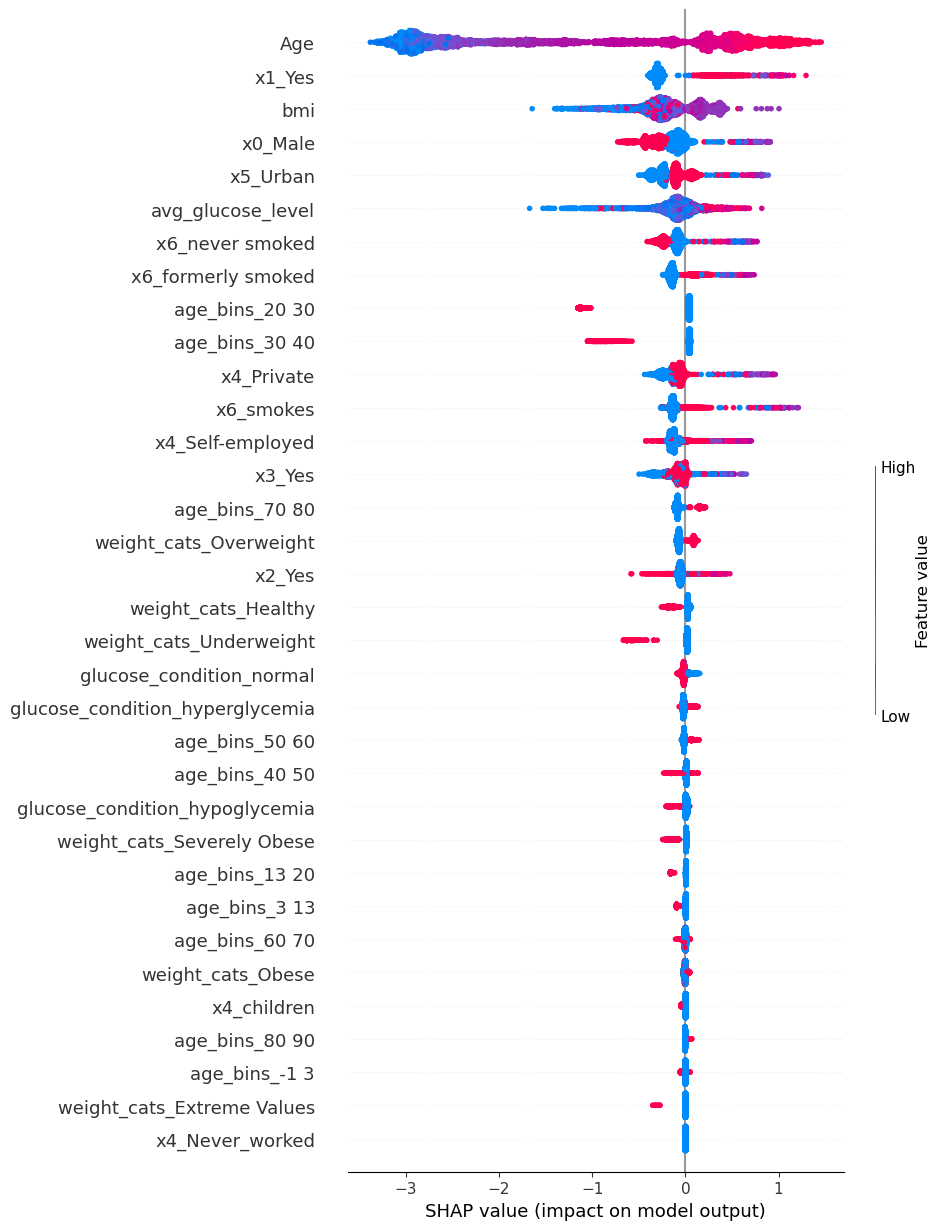

In [757]:
model = best_models[2]
print(model)
model.fit(X_train_sampled_ft, y_train_sampled)
shap_values = shap.TreeExplainer(
    model, feature_names=X_train_sampled_ft.columns).shap_values(X_train_sampled_ft)
shap.summary_plot(shap_values, X_train_sampled_ft, feature_names=X_train_sampled_ft.columns, max_display=50)

In [758]:
vals = np.abs(shap_values).mean(0)
feature_importance_cat = pd.DataFrame(list(zip(X_train_sampled_ft.columns, vals)),
                                  columns=['col_name', 'feature_importance_vals'])
feature_importance_cat.sort_values(by=['feature_importance_vals'],inplace=True)
feats_drop_cat = list(feature_importance_cat.loc[feature_importance_cat['feature_importance_vals'] <= 0.01, 'col_name'])

In [759]:
feats_drop_cat

['x4_Never_worked',
 'weight_cats_Extreme Values',
 'age_bins_-1 3',
 'age_bins_80 90',
 'x4_children',
 'weight_cats_Obese',
 'age_bins_60 70',
 'age_bins_3 13']

In [760]:
cross_val_ref.style.background_gradient(cmap='Reds')

In [761]:
cross_val_ft_1.style.background_gradient(cmap='Reds')

In [762]:
cross_val_ft_xgb = cross_validate_model(
    [best_models[0]], X_train_sampled_ft.drop(feats_drop_xgb, axis=1), y_train=y_train_sampled, pipeline=False)
cross_val_ft_xgb.style.background_gradient(cmap='Reds')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. T

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. T

In [763]:
cross_val_ft_light = cross_validate_model(
    [best_models[1]], X_train_sampled_ft.drop(feats_drop_light, axis=1), y_train=y_train_sampled, pipeline=False)
cross_val_ft_light.style.background_gradient(cmap='Reds')

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [765]:
cross_val_ft_cat = cross_validate_model(
    [best_models[2]], X_train_sampled_ft.drop(feats_drop_cat, axis=1), y_train=y_train_sampled, pipeline=False)
cross_val_ft_cat.style.background_gradient(cmap='Reds')

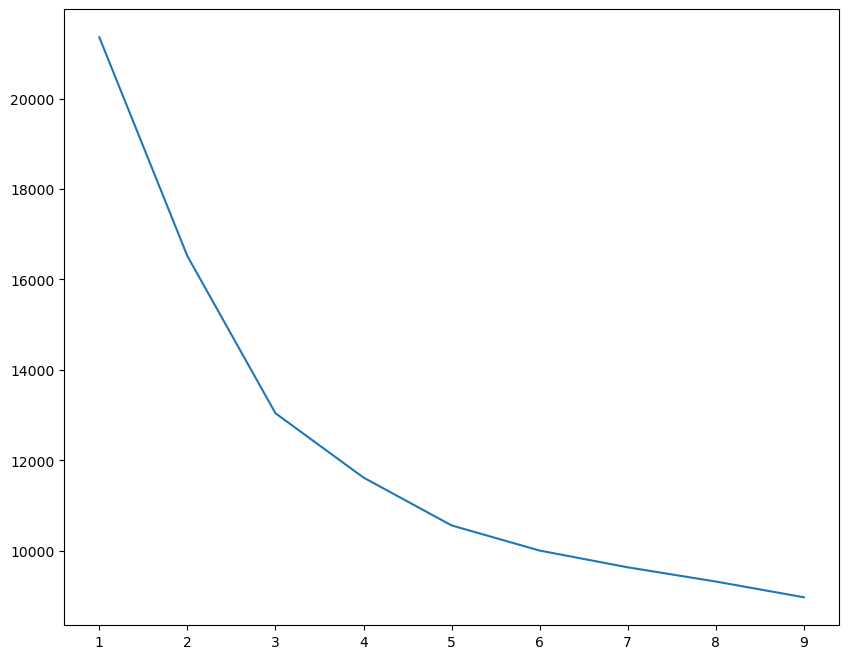

In [766]:
wcss = []

for i in range(1, 10):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=42)
    clustering.fit(X_train_sampled)
    wcss.append(clustering.inertia_)
    
ks = np.arange(1, 10)

fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(x=ks, y=wcss, ax=ax)
ax.set_xticks(ks)
plt.show()

In [767]:
def cluster_data(data):
    data_scaled = make_preprocessor(data, scaler=True).fit_transform(data)
    new_data = data.copy()
    clustering = KMeans(n_clusters=3, init='k-means++', random_state=42)
    clustering.fit(data_scaled)
    new_data['clusters'] = clustering.predict(data_scaled)
    new_data['clusters'] = new_data['clusters'].astype('category')
    return new_data

In [768]:
X_train_sampled_cat = X_train_sampled_ft.drop(feats_drop_cat, axis=1)
X_train_sampled_light = X_train_sampled_ft.drop(feats_drop_light, axis=1)

In [769]:
X_train_sampled_cat = pd.get_dummies(cluster_data(X_train_sampled_cat), drop_first=True)
X_train_sampled_light = pd.get_dummies(cluster_data(X_train_sampled_light), drop_first=True)

In [770]:
cross_val_ft_cat.style.background_gradient(cmap='Reds')

In [771]:
cross_val_ft_cat_cl = cross_validate_model(
    [best_models[2]], X_train_sampled_cat, y_train=y_train_sampled, pipeline=False)
cross_val_ft_cat_cl.style.background_gradient(cmap='Reds')

In [772]:
cross_val_ft_light.style.background_gradient(cmap='Reds')

In [773]:
cross_val_ft_light_cl = cross_validate_model(
    [best_models[1]], X_train_sampled_light, y_train=y_train_sampled, pipeline=False)
cross_val_ft_light_cl.style.background_gradient(cmap='Reds')

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [774]:
class Autofeatures:

    def __init__(self):
        self.auto_feat = AutoFeatClassifier(n_jobs=-1,
                                            transformations=("1/", "exp", "log", "abs", "sqrt", "^2", "^3"
                                                            ), verbose=True, )

    def fit(self, data_x, data_y):
        data_x_new = data_x.copy()
        data_x_new = data_x_new.fillna(data_x_new.mean())
        self.auto_feat.fit(data_x_new, data_y, )

    def transform(self, data_x, cols):
        transformed_data = self.auto_feat.transform(data_x)
        transformed_data = transformed_data.merge(data_x, on=cols)
        return transformed_data

In [775]:
auto_features = Autofeatures()

In [776]:
cols = ['Age', 'avg_glucose_level', 'bmi']
#auto_features.fit(X_train_sampled_unscaled, y_train_sampled)

In [777]:
#import pickle
#auto_feat_save = open("auto_feat_save.pickle", "wb")
#pickle.dump(auto_features, auto_feat_save)
#auto_feat_save.close()

In [778]:
import pickle
auto_feat = open("auto_feat_save.pickle", "rb")
auto_features = pickle.load(auto_feat)

In [779]:
X_train_sampled_unscaled.columns = X_train_sampled_unscaled.columns.str.replace(r'[\(\)\[\]\<\>]', '')
X_train_sampled_unscaled.columns = X_train_sampled_unscaled.columns.str.replace(',', '')

The default value of regex will change from True to False in a future version.


In [780]:
lim_cols = X_train_sampled_unscaled.columns

In [781]:
X_train_sampled_ft_auto = auto_features.transform(X_train_sampled_ft[lim_cols], cols)

[AutoFeat] Computing 33 new features.
[AutoFeat]    33/   33 new features ...done.


In [782]:
to_drop = list(X_train_sampled_ft_auto.columns[-12:])

In [783]:
X_train_sampled_ft_auto = X_train_sampled_ft_auto.drop(to_drop, axis=1)

In [784]:
X_train_sampled_ft_auto = add_features(X_train_sampled_ft_auto)

In [785]:
X_train_sampled_ft_auto = cluster_data(X_train_sampled_ft_auto)

Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.


In [786]:
X_train_sampled_ft_auto = pd.get_dummies(X_train_sampled_ft_auto, drop_first=True)

In [787]:
cross_val_ft_cat_cl.style.background_gradient(cmap='Reds')

In [788]:
X_train_sampled_ft_auto.columns = X_train_sampled_ft_auto.columns.str.replace(r'[\(\)\[\]\<\>\,]', '')

The default value of regex will change from True to False in a future version.


In [789]:
cross_val_ft_cat_cl_auto = cross_validate_model(
    [best_models[2]], X_train_sampled_ft_auto, y_train=y_train_sampled, pipeline=False)
cross_val_ft_cat_cl_auto.style.background_gradient(cmap='Reds')

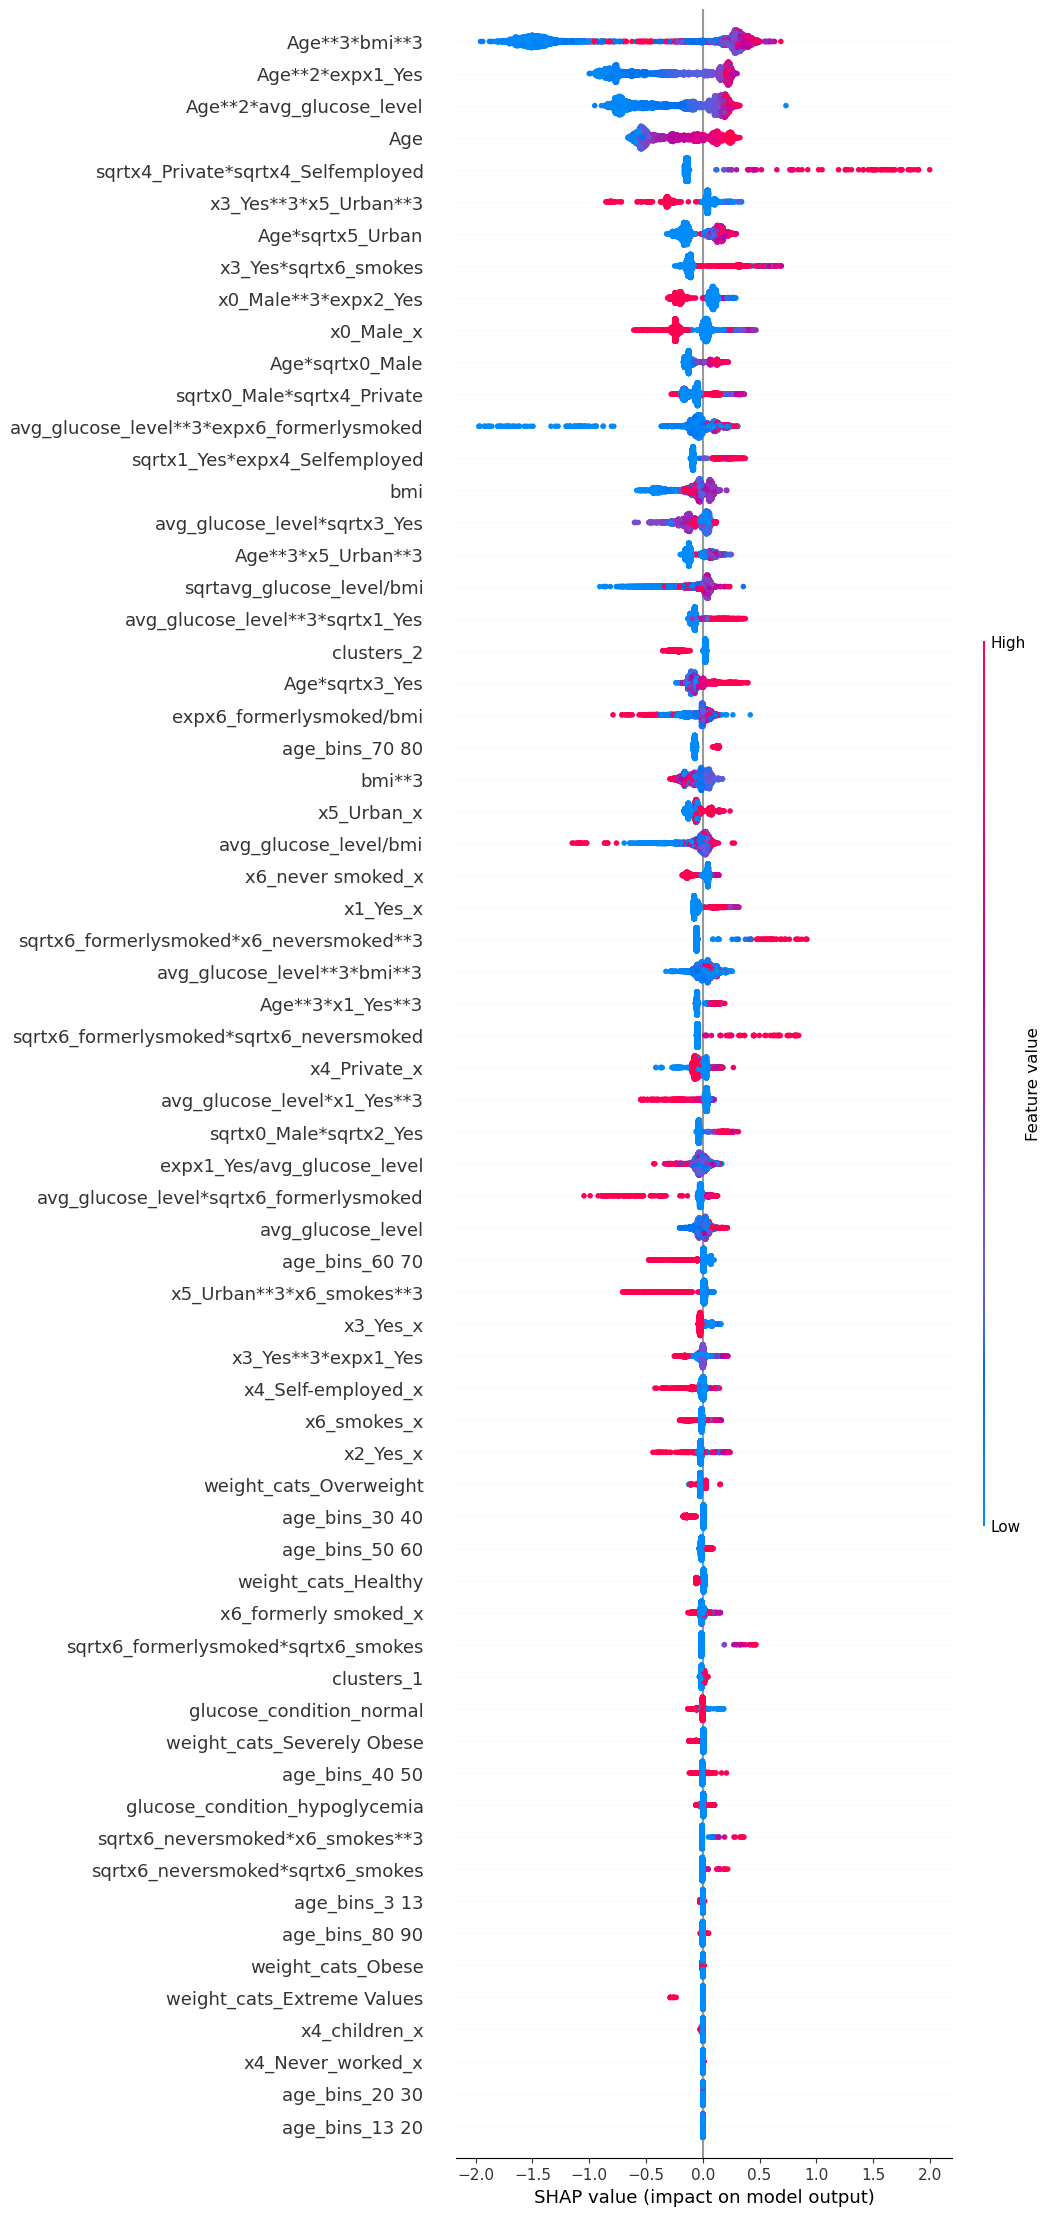

In [790]:
model = best_models[2]
print(model)
model.fit(X_train_sampled_ft_auto, y_train_sampled)
shap_values = shap.TreeExplainer(
    model, feature_names=X_train_sampled_ft_auto.columns).shap_values(X_train_sampled_ft_auto)
shap.summary_plot(shap_values, X_train_sampled_ft_auto,
                  feature_names=X_train_sampled_ft_auto.columns, max_display=100)

In [791]:
vals = np.abs(shap_values).mean(0)
feature_importance_cat = pd.DataFrame(list(zip(X_train_sampled_ft_auto.columns, vals)),
                                      columns=['col_name', 'feature_importance_vals'])
feature_importance_cat.sort_values(
    by=['feature_importance_vals'], inplace=True)
feats_drop_cat = list(
    feature_importance_cat.loc[feature_importance_cat['feature_importance_vals'] <= 0.01, 'col_name'])

In [792]:
feats_drop_cat

['age_bins_13 20',
 'age_bins_20 30',
 'x4_Never_worked_x',
 'x4_children_x',
 'weight_cats_Extreme Values',
 'weight_cats_Obese',
 'age_bins_80 90',
 'age_bins_3 13',
 'sqrtx6_neversmoked*sqrtx6_smokes',
 'sqrtx6_neversmoked*x6_smokes**3',
 'glucose_condition_hypoglycemia',
 'age_bins_40 50',
 'weight_cats_Severely Obese']

In [793]:
cross_val_ft_cat_cl.style.background_gradient(cmap='Reds')

In [794]:
cross_val_ft_cat_cl_auto.style.background_gradient(cmap='Reds')

In [795]:
cross_val_ft_cat_cl_auto_3 = cross_validate_model(
    [best_models[2]], X_train_sampled_ft_auto.drop(feats_drop_cat, axis=1), y_train=y_train_sampled, pipeline=False)
cross_val_ft_cat_cl_auto_3.style.background_gradient(cmap='Reds')

In [796]:
ft = FeatureSelector(problem_type='classification')
X_train_sampled_select = ft.fit_transform(
    X=X_train_sampled_ft_auto, y=y_train_sampled)

In [797]:
cross_val_ft_cat_cl_auto_4 = cross_validate_model(
    [best_models[2]], X_train_sampled_select, y_train=y_train_sampled,
    pipeline=False)
cross_val_ft_cat_cl_auto_4.style.background_gradient(cmap='Reds')

In [798]:
cross_val_ft_light_cl.style.background_gradient(cmap='Reds')

In [799]:
cross_val_ft_light_cl_auto = cross_validate_model(
    [best_models[1]], X_train_sampled_ft_auto, y_train=y_train_sampled, pipeline=False)
cross_val_ft_light_cl_auto.style.background_gradient(cmap='Reds')

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(force_row_wise=True, max_depth=3, random_state=42, reg_alpha=5,
               scale_pos_weight=19.551724137931036, verbosity=0)
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


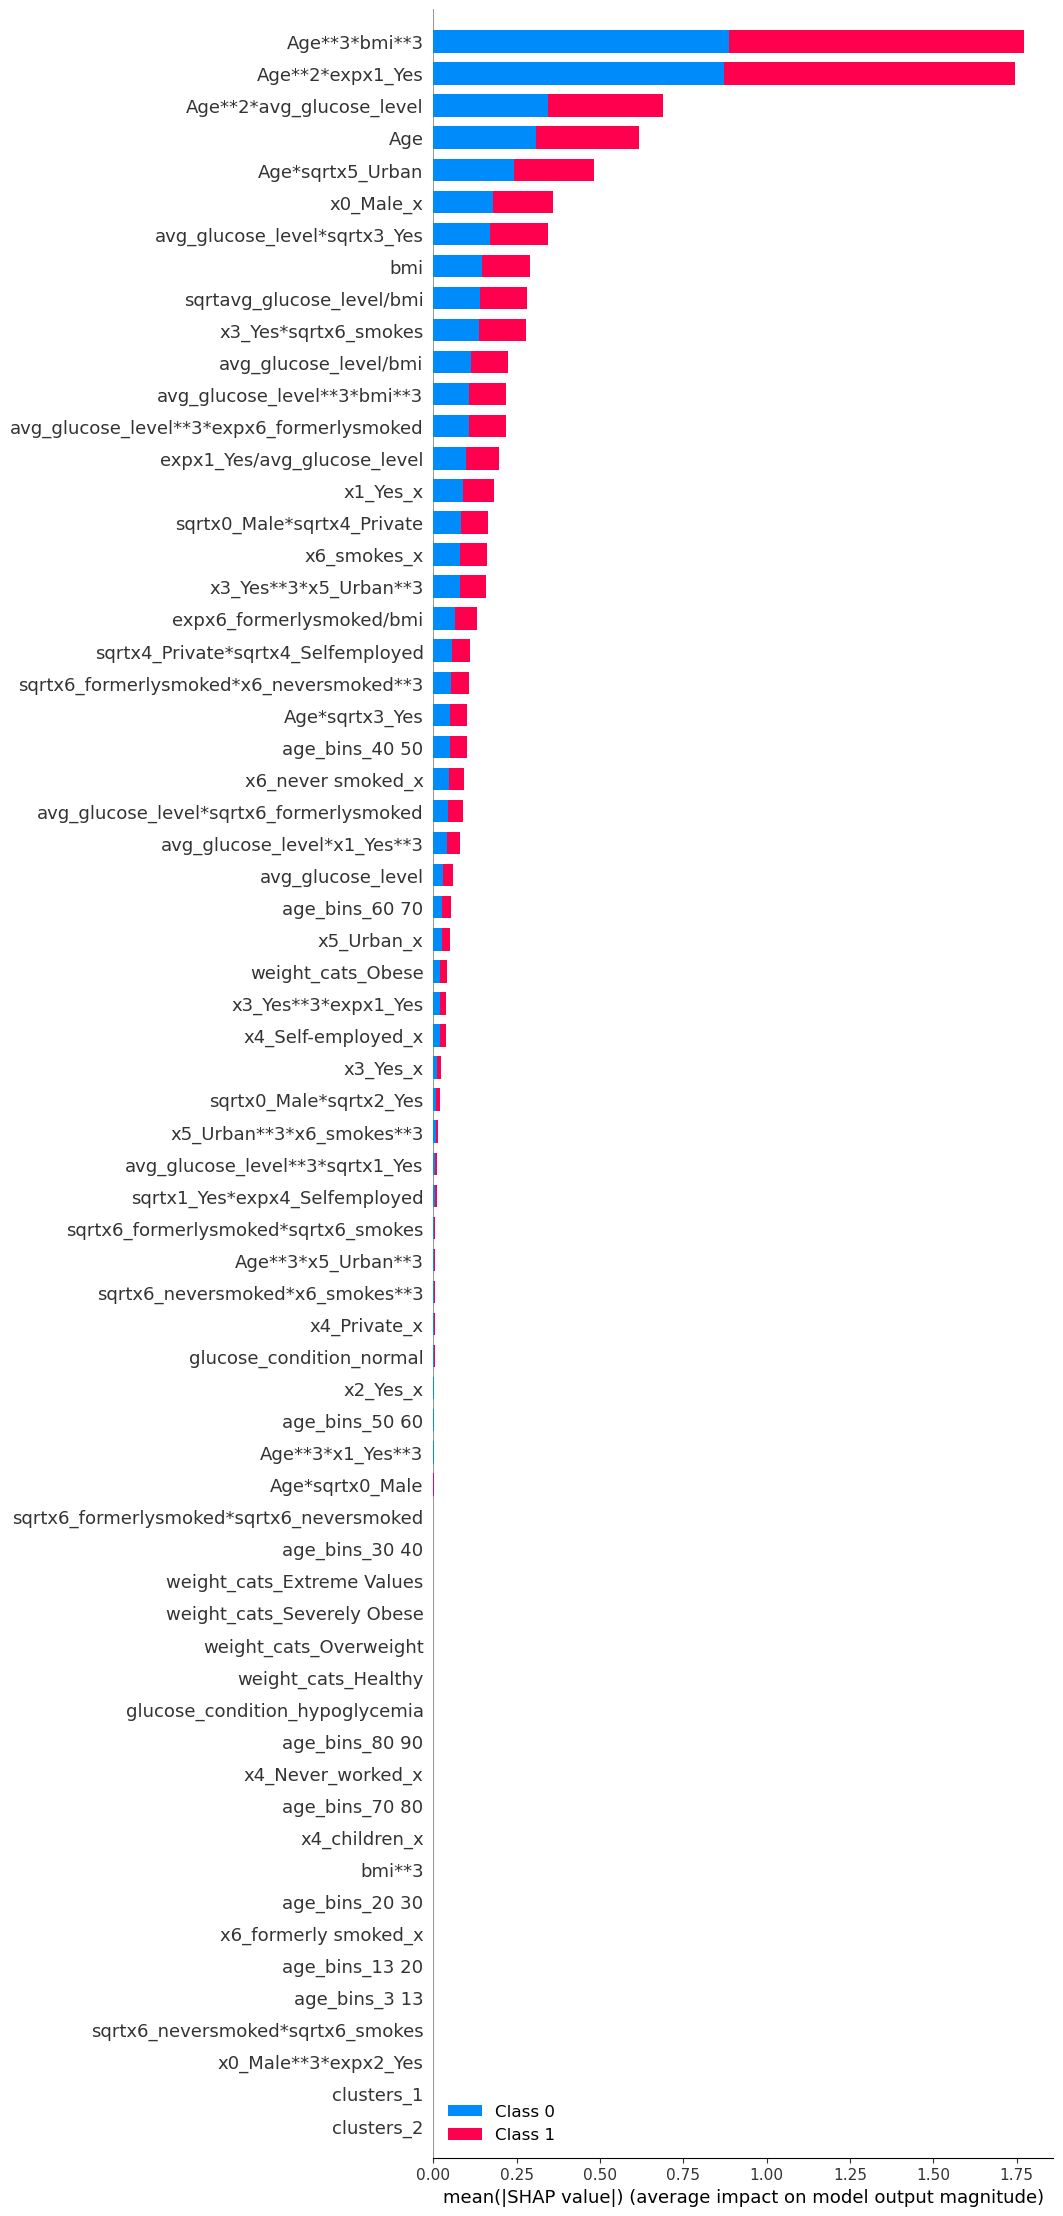

In [800]:
model = best_models[1]
print(model)
model.fit(X_train_sampled_ft_auto, y_train_sampled)
shap_values = shap.TreeExplainer(
    model, feature_names=X_train_sampled_ft_auto.columns).shap_values(X_train_sampled_ft_auto)
shap.summary_plot(shap_values, X_train_sampled_ft_auto,
                  feature_names=X_train_sampled_ft_auto.columns, max_display=100)

In [801]:
vals = np.abs(shap_values).mean(0)
feature_importance_light = pd.DataFrame(list(zip(X_train_sampled_ft_auto.columns, sum(vals))),
                                      columns=['col_name', 'feature_importance_vals'])
feature_importance_light.sort_values(
    by=['feature_importance_vals'], inplace=True)
feats_drop_light = list(
    feature_importance_light.loc[feature_importance_light['feature_importance_vals'] <= 0.01, 'col_name'])

In [802]:
feats_drop_light

['clusters_2',
 'clusters_1',
 'x0_Male**3*expx2_Yes',
 'sqrtx6_neversmoked*sqrtx6_smokes',
 'age_bins_3 13',
 'age_bins_13 20',
 'x6_formerly smoked_x',
 'age_bins_20 30',
 'bmi**3',
 'x4_children_x',
 'age_bins_70 80',
 'x4_Never_worked_x',
 'age_bins_80 90',
 'glucose_condition_hypoglycemia',
 'weight_cats_Healthy',
 'weight_cats_Overweight',
 'weight_cats_Severely Obese',
 'weight_cats_Extreme Values',
 'age_bins_30 40',
 'sqrtx6_formerlysmoked*sqrtx6_neversmoked']

In [803]:
cross_val_ft_light_cl.style.background_gradient(cmap='Reds')

In [804]:
cross_val_ft_light_cl_auto.style.background_gradient(cmap='Reds')

In [805]:
cross_val_ft_light_cl_auto_2 = cross_validate_model(
    [best_models[1]], X_train_sampled_ft_auto.drop(feats_drop_light, axis=1), y_train=y_train_sampled, pipeline=False)
cross_val_ft_light_cl_auto_2.style.background_gradient(cmap='Reds')

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [806]:
cross_val_ft_xgb_cl_auto_4 = cross_validate_model(
    [best_models[1]], X_train_sampled_select, y_train=y_train_sampled,
    pipeline=False)
cross_val_ft_xgb_cl_auto_4.style.background_gradient(cmap='Reds')

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Hyperparameter Tuning & Feature Selection

In [564]:
def randomized_tuning(classifier, params, X_train=X_train, y_train=y_train, pipeline=True, n_iters=50):
    score_table = pd.DataFrame()

    if pipeline == True:
        
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor), ('classifier', classifier)])

        clf = RandomizedSearchCV(pipeline, param_distributions=params, random_state=42,
                         n_iter=n_iters,
                                cv=10, scoring=['accuracy','recall',   
                                                'precision', 'f1',
                                                'roc_auc'], n_jobs=-1, refit=False)
        cv = clf.fit(X_train, y_train)
        return pd.DataFrame(cv.cv_results_)

    else:
        clf = RandomizedSearchCV(classifier, param_distributions=params, random_state=42,
                         n_iter=n_iters,
                                cv=10, scoring=['accuracy','recall',   
                                                'precision', 'f1',
                                                'roc_auc'], n_jobs=-1, refit=False)
        cv = clf.fit(X_train, y_train)
        return pd.DataFrame(cv.cv_results_)

In [807]:
cat_search = CatBoostClassifier(random_state=42, early_stopping_rounds=20,
               scale_pos_weight=pos_weight, verbose=False)

In [808]:
cat_params={'iterations': np.arange(10, 500, 50),
        'learning_rate': np.linspace(0.01, 0.1, 30),
        'depth': np.arange(2, 6),
        'l2_leaf_reg': np.arange(1,20,1),
        'rsm': np.linspace(0.01, 0.5, 50),
        'random_strength': np.arange(0, 15)
    }

In [810]:
cat_search.randomized_search(param_distributions=cat_params,
                             X=X_train_sampled_ft_auto, y=y_train_sampled,
                             cv=5, stratified=True, plot=True, n_iter=2000,
                             verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.339561523
bestIteration = 155


bestTest = 0.362288637
bestIteration = 203

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3219395345
bestIteration = 368


bestTest = 0.4771830567
bestIteration = 208


bestTest = 0.5160266265
bestIteration = 309


bestTest = 0.3174212857
bestIteration = 305


bestTest = 0.341732157
bestIteration = 308


bestTest = 0.6112615887
bestIteration = 9


bestTest = 0.3762188177
bestIteration = 155


bestTest = 0.3498904848
bestIteration = 307


bestTest = 0.5709623133
bestIteration = 109


bestTest = 0.378956805
bestIteration = 209


bestTest = 0.3395430365
bestIteration = 157


bestTest = 0.3138473085
bestIteration = 406


bestTest = 0.3929678814
bestIteration = 154


bestTest = 0.3110263183
bestIteration = 446


bestTest = 0.5497449946
bestIteration = 9


bestTest = 0.3079695395
bestIteration = 457


bestTest = 0.3101238713
bestIteration = 458


bestTest = 0.4499022038
bestIteration = 109


bestTest = 0.4916160381
bestItera


bestTest = 0.3346815934
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3072946108
bestIteration = 186


bestTest = 0.4102579348
bestIteration = 159


bestTest = 0.3329498615
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2911351568
bestIteration = 189


bestTest = 0.5585458186
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2933584378
bestIteration = 58

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3043307059
bestIteration = 100


bestTest = 0.5522540584
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2986197859
bestIteration = 217

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2910408116
bestIteration = 205


bestTest = 0.3353403984
bestIteration = 309


bestTest = 0.3773557746
bestIteration = 309


bestTest = 0.3913016029
bestIteration = 109

Stopped by overfitting detector  (20 


bestTest = 0.4040497486
bestIteration = 159


bestTest = 0.2996682674
bestIteration = 209


bestTest = 0.4880726725
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.302778574
bestIteration = 190


bestTest = 0.3668387535
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2890703174
bestIteration = 232


bestTest = 0.363744395
bestIteration = 309


bestTest = 0.3177089884
bestIteration = 159


bestTest = 0.2980632757
bestIteration = 209


bestTest = 0.3265042392
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2918607144
bestIteration = 164


bestTest = 0.3314530164
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2881041165
bestIteration = 327

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2916076643
bestIteration = 178


bestTest = 0.5375531867
bestIteration = 59


bestTest = 0.3128190118
bestIteration = 459


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2955832809
bestIteration = 184

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2958301979
bestIteration = 185

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3017715572
bestIteration = 133

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2893676217
bestIteration = 237


bestTest = 0.3152896525
bestIteration = 259


bestTest = 0.3088591649
bestIteration = 459

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2925560334
bestIteration = 183

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2961773083
bestIteration = 168


bestTest = 0.2923096716
bestIteration = 409

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.306870193
bestIteration = 180


bestTest = 0.5293855728
bestIteration = 9


bestTest = 0.6299528742
bestIteration = 9


bestTest = 0.5212485592
bestIteration = 9


bestTest = 0.3297691405
bestIt

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2996993929
bestIteration = 148


bestTest = 0.3296652025
bestIteration = 409

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2976941928
bestIteration = 238

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3041489324
bestIteration = 224


bestTest = 0.3863089455
bestIteration = 308


bestTest = 0.4576129361
bestIteration = 59


bestTest = 0.3722406973
bestIteration = 458


bestTest = 0.4494545838
bestIteration = 9


bestTest = 0.3284501732
bestIteration = 209


bestTest = 0.5210934465
bestIteration = 9


bestTest = 0.335545449
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2964904002
bestIteration = 220


bestTest = 0.3260262404
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2981539229
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2981217733
bestIteration

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2809005969
bestIteration = 79


bestTest = 0.2990660366
bestIteration = 158

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2851706909
bestIteration = 187

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2868061563
bestIteration = 247


bestTest = 0.3146594627
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2805870314
bestIteration = 138


bestTest = 0.3091967531
bestIteration = 57


bestTest = 0.3016508979
bestIteration = 408


bestTest = 0.304698314
bestIteration = 409


bestTest = 0.3206396748
bestIteration = 59


bestTest = 0.3059039245
bestIteration = 251


bestTest = 0.3137665776
bestIteration = 209

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3022624428
bestIteration = 222


bestTest = 0.3546956407
bestIteration = 109


bestTest = 0.3125215177
bestIteration = 258


bestTest = 0.2967273283
bestIteration = 257

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2967136605
bestIteration = 232


bestTest = 0.2946299432
bestIteration = 394

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2936954393
bestIteration = 229

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2963829434
bestIteration = 37

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2881058206
bestIteration = 150


bestTest = 0.286480329
bestIteration = 209


bestTest = 0.3005554028
bestIteration = 309

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2906602055
bestIteration = 133


bestTest = 0.3129023046
bestIteration = 159


bestTest = 0.2911644002
bestIteration = 448

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3020360667
bestIteration = 103


bestTest = 0.3503095078
bestIteration = 59


bestTest = 0.4401112195
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2970688288
bes


bestTest = 0.3543758878
bestIteration = 259


bestTest = 0.4355299157
bestIteration = 59


bestTest = 0.3596738975
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.285767898
bestIteration = 192


bestTest = 0.4848205138
bestIteration = 59


bestTest = 0.4744244426
bestIteration = 9


bestTest = 0.294419158
bestIteration = 259


bestTest = 0.3187852581
bestIteration = 308


bestTest = 0.3113271137
bestIteration = 109


bestTest = 0.3681061105
bestIteration = 259


bestTest = 0.4553499119
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2920046722
bestIteration = 158


bestTest = 0.3635430802
bestIteration = 109


bestTest = 0.3236650996
bestIteration = 59


bestTest = 0.3225665644
bestIteration = 108

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2934813699
bestIteration = 98


bestTest = 0.4100508647
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0


bestTest = 0.2994799876
bestIteration = 342


bestTest = 0.3095596677
bestIteration = 309


bestTest = 0.3815655138
bestIteration = 159


bestTest = 0.3939405099
bestIteration = 59


bestTest = 0.3736118647
bestIteration = 109


bestTest = 0.3147687617
bestIteration = 309

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2916443294
bestIteration = 135


bestTest = 0.3072807124
bestIteration = 259

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2916019891
bestIteration = 209


bestTest = 0.3030484784
bestIteration = 359

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2984805507
bestIteration = 236

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2903855622
bestIteration = 119

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2909062179
bestIteration = 251


bestTest = 0.3169455702
bestIteration = 359


bestTest = 0.3636717379
bestIteration = 59


bestTest = 0.3339641097
bestIteration = 1

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2720907802
bestIteration = 117


bestTest = 0.3238112875
bestIteration = 409


bestTest = 0.2935399626
bestIteration = 457

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2871155763
bestIteration = 176


bestTest = 0.3847850134
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2855357665
bestIteration = 146


bestTest = 0.2829653519
bestIteration = 404

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.281791331
bestIteration = 269

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.288948958
bestIteration = 215

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2965205547
bestIteration = 321


bestTest = 0.4507581546
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2892824833
bestIteration = 323


bestTest = 0.4153312934
bestIteration = 59


bestTest = 0.3184704964
best

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3037832204
bestIteration = 124


bestTest = 0.3779569667
bestIteration = 259


bestTest = 0.3070325472
bestIteration = 309


bestTest = 0.3174589658
bestIteration = 159


bestTest = 0.5844122936
bestIteration = 9


bestTest = 0.3045277998
bestIteration = 291


bestTest = 0.4011361923
bestIteration = 359


bestTest = 0.3300033876
bestIteration = 409


bestTest = 0.4183274132
bestIteration = 59


bestTest = 0.2978496229
bestIteration = 450


bestTest = 0.4610582121
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2994296633
bestIteration = 282


bestTest = 0.5177482038
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.279503416
bestIteration = 155


bestTest = 0.2977209971
bestIteration = 398


bestTest = 0.3690095873
bestIteration = 59


bestTest = 0.3045911342
bestIteration = 156


bestTest = 0.3349654527
bestIteration = 309


bestTest = 0.34723


bestTest = 0.3847951259
bestIteration = 259


bestTest = 0.6082137478
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3140375761
bestIteration = 28


bestTest = 0.4470920248
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2928389821
bestIteration = 198


bestTest = 0.3584578969
bestIteration = 59


bestTest = 0.3240591127
bestIteration = 309


bestTest = 0.4252153604
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2957452809
bestIteration = 172


bestTest = 0.4743938863
bestIteration = 9


bestTest = 0.3554036326
bestIteration = 209

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2875114947
bestIteration = 199

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2896927528
bestIteration = 91


bestTest = 0.3540280553
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2881292945
bestIteration = 2


bestTest = 0.3682372287
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2924772502
bestIteration = 195


bestTest = 0.4285973219
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2958067583
bestIteration = 151


bestTest = 0.3457557657
bestIteration = 259

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2931269132
bestIteration = 73


bestTest = 0.2959521512
bestIteration = 403

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.294168942
bestIteration = 139

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.290707589
bestIteration = 222


bestTest = 0.3444221392
bestIteration = 59


bestTest = 0.2918497971
bestIteration = 152

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2831437255
bestIteration = 179


bestTest = 0.4473594191
bestIteration = 9


bestTest = 0.3039149475
bestIteration = 259

Stopped by overfitting detector  (20 ite

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3058587467
bestIteration = 125

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2908193979
bestIteration = 172


bestTest = 0.3028255353
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2941250317
bestIteration = 154


bestTest = 0.3215813491
bestIteration = 259

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2887031647
bestIteration = 294


bestTest = 0.3543107726
bestIteration = 59


bestTest = 0.2937784125
bestIteration = 408


bestTest = 0.5718065813
bestIteration = 9


bestTest = 0.3439517522
bestIteration = 209


bestTest = 0.3391317782
bestIteration = 159


bestTest = 0.6035875256
bestIteration = 9


bestTest = 0.362548311
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2890081508
bestIteration = 329


bestTest = 0.3106035996
bestIteration = 359

Stopped by overfitting detector  (20 iterations


bestTest = 0.3251522988
bestIteration = 209

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.288867231
bestIteration = 132

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.298066445
bestIteration = 277

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3132804505
bestIteration = 30


bestTest = 0.2809747108
bestIteration = 109


bestTest = 0.2798324703
bestIteration = 206


bestTest = 0.4953024917
bestIteration = 9


bestTest = 0.3665489645
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2795532867
bestIteration = 126


bestTest = 0.4766586007
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2837862742
bestIteration = 119


bestTest = 0.3789197722
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2866427613
bestIteration = 223


bestTest = 0.5619486412
bestIteration = 9


bestTest = 0.3095648308
bestIteration = 25

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2932726443
bestIteration = 189


bestTest = 0.3309643683
bestIteration = 259


bestTest = 0.3112452286
bestIteration = 159


bestTest = 0.2871182281
bestIteration = 307


bestTest = 0.446502085
bestIteration = 9


bestTest = 0.3295011557
bestIteration = 208


bestTest = 0.4324127069
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2921068601
bestIteration = 235


bestTest = 0.5739386832
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3081292922
bestIteration = 173


bestTest = 0.383650514
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2903094008
bestIteration = 305


bestTest = 0.3586092412
bestIteration = 109


bestTest = 0.3102749022
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2961332188
bestIteration = 149


bestTest = 0.323273228
bestIteration = 359

Sto


bestTest = 0.3129213793
bestIteration = 64

Training on fold [2/5]

bestTest = 0.3125441352
bestIteration = 134

Training on fold [3/5]

bestTest = 0.270250246
bestIteration = 127

Training on fold [4/5]

bestTest = 0.286137367
bestIteration = 115



{'params': {'random_strength': 2,
  'depth': 4,
  'l2_leaf_reg': 2,
  'iterations': 210,
  'rsm': 0.4,
  'learning_rate': 0.07827586206896552},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
  

In [811]:
cross_val_ft_light_cl_auto_2 = cross_validate_model(
    [cat_search], X_train_sampled_ft_auto, y_train=y_train_sampled, pipeline=False)
cross_val_ft_light_cl_auto_2.style.background_gradient(cmap='Reds')

In [812]:
X_train_feature_test = X_train_sampled_ft_auto.copy()

In [813]:
shap_values = shap.TreeExplainer(
    cat_search, feature_names=X_train_feature_test.columns).shap_values(X_train_feature_test)

vals = np.abs(shap_values).mean(0)
feature_importance_cat = pd.DataFrame(list(zip(X_train_feature_test.columns, vals)),
                                      columns=['col_name', 'feature_importance_vals'])
feature_importance_cat.sort_values(
    by=['feature_importance_vals'], inplace=True)

In [814]:
train_log_loss = []
test_log_loss = []
train_precision = []
test_precision = []
train_recall = []
test_recall = []
for i in range(len(X_train_feature_test.columns)-2):
    shap_values = shap.TreeExplainer(
    cat_search, feature_names=X_train_feature_test.columns).shap_values(X_train_feature_test)
    
    vals = np.abs(shap_values).mean(0)
    feature_importance_cat = pd.DataFrame(list(zip(X_train_feature_test.columns, vals)),
                                      columns=['col_name', 'feature_importance_vals'])
    feature_importance_cat.sort_values(
        by=['feature_importance_vals'], inplace=True)
    drop_feat = feature_importance_cat.head(1)['col_name']    
    X_train_feature_test.drop(drop_feat, axis=1, inplace=True)
    
    cross_val_feature_test = cross_validate_model(
        [cat_search], X_train_feature_test, y_train=y_train_sampled, pipeline=False)
    train_log_loss.append(cross_val_feature_test['train_log_loss'].values[0])
    test_log_loss.append(-cross_val_feature_test['test_neg_log_loss'].values[0])
    train_precision.append(cross_val_feature_test['train_precision'].values[0])
    test_precision.append(cross_val_feature_test['test_precision'].values[0])
    train_recall.append(cross_val_feature_test['train_recall'].values[0])
    test_recall.append(cross_val_feature_test['test_recall'].values[0])

In [815]:
feature_stats = {'train_log_loss': train_log_loss,
                'test_log_loss': test_log_loss,
                'train_precision': train_precision,
                'test_precision': test_precision,
                'train_recall': train_recall,
                'test_recall': test_recall}

In [816]:
feature_drop_stats = pd.DataFrame(feature_stats)

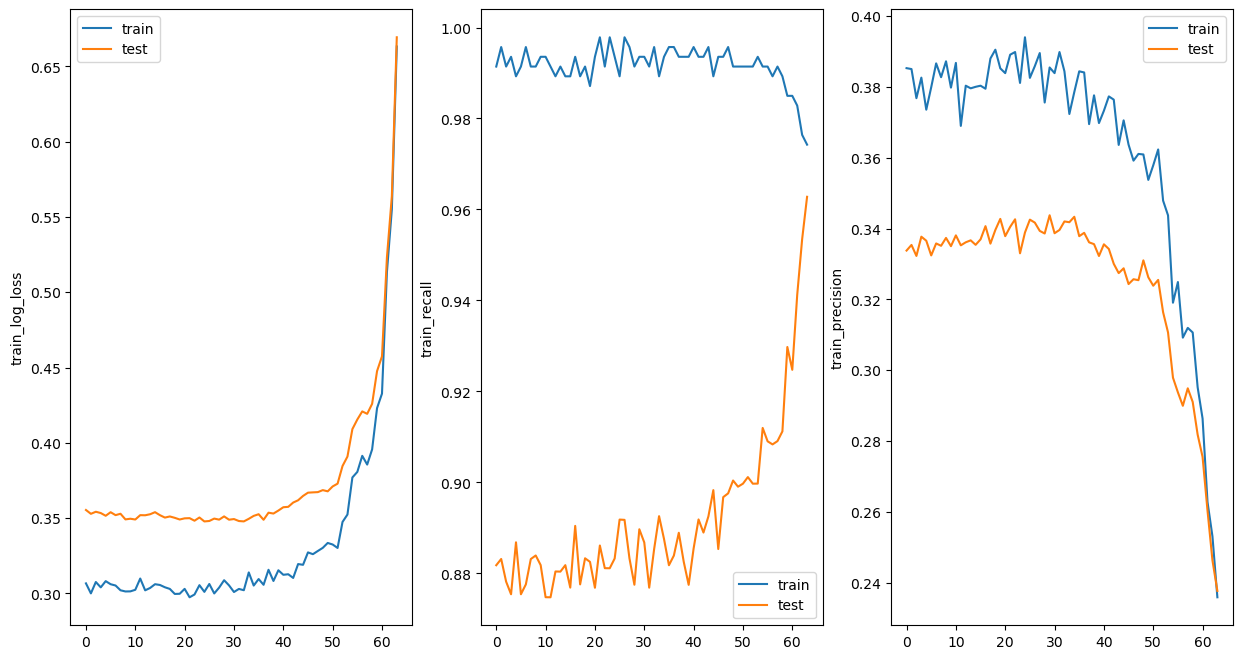

In [817]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
sns.lineplot(x=feature_drop_stats.index, y='train_log_loss', data=feature_drop_stats, ax=ax[0], label='train')
sns.lineplot(x=feature_drop_stats.index, y='test_log_loss', data=feature_drop_stats, ax=ax[0], label='test')
sns.lineplot(x=feature_drop_stats.index, y='train_recall', data=feature_drop_stats, ax=ax[1], label='train')
sns.lineplot(x=feature_drop_stats.index, y='test_recall', data=feature_drop_stats, ax=ax[1], label='test')
sns.lineplot(x=feature_drop_stats.index, y='train_precision', data=feature_drop_stats, ax=ax[2], label='train')
sns.lineplot(x=feature_drop_stats.index, y='test_precision', data=feature_drop_stats, ax=ax[2], label='test')
ax[0].legend()

In [818]:
feature_drop_stats['test_log_loss'].argmin()

24

In [819]:
feature_drop_stats['test_recall'].argmax()

63

In [820]:
feature_drop_stats['test_precision'].argmax()

29

In [821]:
X_train_feature_test = X_train_sampled_ft_auto.copy()

In [825]:
cat_search.get_params()

{'verbose': False,
 'random_state': 42,
 'scale_pos_weight': 19.551724137931036,
 'early_stopping_rounds': 20,
 'random_strength': 2,
 'depth': 4,
 'l2_leaf_reg': 2,
 'iterations': 210,
 'rsm': 0.4,
 'learning_rate': 0.07827586206896552}

In [826]:
pos_weight

19.551724137931036

In [827]:
cat_feature_select = [CatBoostClassifier(verbose=False, random_state=42,
                                scale_pos_weight=pos_weight,
                                early_stopping_rounds=20, random_strength=2,
                                depth=4, l2_leaf_reg=2,
                                iterations=210, rsm=.4,
                                learning_rate=0.07827586206896552)]

In [828]:
X_train_feature_test = X_train_sampled_ft_auto.copy()

In [829]:
for i in range(25):
    cross_val_feature_test = cross_validate_model(
    [cat_feature_select[0]], X_train_feature_test, y_train=y_train_sampled, pipeline=False)
    shap_values = shap.TreeExplainer(
    cat_feature_select[0], feature_names=X_train_feature_test.columns).shap_values(X_train_feature_test)
    
    vals = np.abs(shap_values).mean(0)
    feature_importance_cat = pd.DataFrame(list(zip(X_train_feature_test.columns, vals)),
                                      columns=['col_name', 'feature_importance_vals'])
    feature_importance_cat.sort_values(
        by=['feature_importance_vals'], inplace=True)
    drop_feat = feature_importance_cat.head(1)['col_name']    
    X_train_feature_test.drop(drop_feat, axis=1, inplace=True)
    
cross_val_feature_test = cross_validate_model(
    [cat_search], X_train_feature_test, y_train=y_train_sampled, pipeline=False)

In [830]:
cross_val_feature_test.style.background_gradient(cmap='Reds')

In [831]:
cat_search_2 = CatBoostClassifier(random_state=42, early_stopping_rounds=20,
                   scale_pos_weight=pos_weight, verbose=False)

In [832]:
cat_search_2.randomized_search(param_distributions=cat_params,
                             X=X_train_feature_test, y=y_train_sampled,
                             cv=5, stratified=True, plot=True, n_iter=2000,
                             verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3564954159
bestIteration = 159


bestTest = 0.3650164072
bestIteration = 205


bestTest = 0.3169017439
bestIteration = 459


bestTest = 0.4575333395
bestIteration = 209


bestTest = 0.5071243404
bestIteration = 309

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.335489426
bestIteration = 257


bestTest = 0.3570416067
bestIteration = 309


bestTest = 0.6208079815
bestIteration = 9


bestTest = 0.3786784644
bestIteration = 151


bestTest = 0.3502555771
bestIteration = 309


bestTest = 0.5788317674
bestIteration = 109


bestTest = 0.4211944403
bestIteration = 205


bestTest = 0.3489616051
bestIteration = 154


bestTest = 0.3270372907
bestIteration = 409


bestTest = 0.4094420334
bestIteration = 159


bestTest = 0.320054317
bestIteration = 458


bestTest = 0.5709008069
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.307604476
bestIteration = 431

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.335


bestTest = 0.3334201239
bestIteration = 159


bestTest = 0.5445862768
bestIteration = 9


bestTest = 0.3328379138
bestIteration = 105

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2897301821
bestIteration = 192


bestTest = 0.4050491782
bestIteration = 159


bestTest = 0.349925368
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2899220364
bestIteration = 203


bestTest = 0.5419672383
bestIteration = 9


bestTest = 0.2954712198
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.283524844
bestIteration = 171


bestTest = 0.568042863
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.29574916
bestIteration = 134

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2857504712
bestIteration = 196


bestTest = 0.3255951302
bestIteration = 307


bestTest = 0.3784798085
bestIteration = 309


bestTest = 0.3924586884
bestIteration = 109

Stopp


bestTest = 0.3558857325
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2966281337
bestIteration = 200


bestTest = 0.3521241928
bestIteration = 309


bestTest = 0.3144869818
bestIteration = 159


bestTest = 0.2966513202
bestIteration = 208


bestTest = 0.3288008963
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2850885247
bestIteration = 197


bestTest = 0.3331445717
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2893858282
bestIteration = 290

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2872313157
bestIteration = 186


bestTest = 0.5247915339
bestIteration = 59


bestTest = 0.307543935
bestIteration = 459

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2853483858
bestIteration = 180


bestTest = 0.5207116519
bestIteration = 9


bestTest = 0.2806014323
bestIteration = 209

Stopped by overfitting detector  (20 iterati


bestTest = 0.2933238945
bestIteration = 259


bestTest = 0.2883760934
bestIteration = 459

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2846132364
bestIteration = 172

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2762414901
bestIteration = 189


bestTest = 0.2770548748
bestIteration = 389

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2953016847
bestIteration = 208


bestTest = 0.5022520611
bestIteration = 9


bestTest = 0.6310501022
bestIteration = 9


bestTest = 0.5089022809
bestIteration = 9


bestTest = 0.3319346934
bestIteration = 108


bestTest = 0.4025734209
bestIteration = 259


bestTest = 0.561225164
bestIteration = 9


bestTest = 0.3939164592
bestIteration = 109


bestTest = 0.3264302238
bestIteration = 109


bestTest = 0.3017545895
bestIteration = 159


bestTest = 0.396071496
bestIteration = 59


bestTest = 0.3742429427
bestIteration = 209

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0


bestTest = 0.364352604
bestIteration = 309


bestTest = 0.4505218856
bestIteration = 59


bestTest = 0.3601148529
bestIteration = 459


bestTest = 0.4469388428
bestIteration = 9


bestTest = 0.326659318
bestIteration = 209


bestTest = 0.5120824689
bestIteration = 9


bestTest = 0.3253090758
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2914910825
bestIteration = 232


bestTest = 0.3117698758
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.287419608
bestIteration = 180

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2834507244
bestIteration = 181


bestTest = 0.340152956
bestIteration = 59


bestTest = 0.4419279207
bestIteration = 9


bestTest = 0.3331613352
bestIteration = 309


bestTest = 0.3236625276
bestIteration = 109


bestTest = 0.3378149574
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2875091084
bestIteration = 195


bestTest = 0.4


bestTest = 0.3124839836
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2737997708
bestIteration = 128


bestTest = 0.3103828752
bestIteration = 59


bestTest = 0.2879636287
bestIteration = 408


bestTest = 0.2914564743
bestIteration = 408


bestTest = 0.3211169685
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3124809786
bestIteration = 144


bestTest = 0.309259749
bestIteration = 207

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3013655281
bestIteration = 202


bestTest = 0.348315033
bestIteration = 109


bestTest = 0.2970068478
bestIteration = 258

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3009276685
bestIteration = 197


bestTest = 0.4029235991
bestIteration = 209

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2921615741
bestIteration = 220


bestTest = 0.3270448801
bestIteration = 258


bestTest = 0.2978103342
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2809726828
bestIteration = 198

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2834602203
bestIteration = 53

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2769404626
bestIteration = 119


bestTest = 0.2740116224
bestIteration = 208


bestTest = 0.2815716876
bestIteration = 309

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.265293035
bestIteration = 126


bestTest = 0.2918782471
bestIteration = 159


bestTest = 0.2715927857
bestIteration = 454

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2955321214
bestIteration = 98


bestTest = 0.3369268085
bestIteration = 59


bestTest = 0.4279698408
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3006990251
bestIteration = 337

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2884897333
bestIteration = 222


bestTest = 0.2969119809
best


bestTest = 0.3358284608
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2791096086
bestIteration = 156


bestTest = 0.4595250294
bestIteration = 59


bestTest = 0.4663602379
bestIteration = 9


bestTest = 0.2801790004
bestIteration = 259


bestTest = 0.3007806514
bestIteration = 309


bestTest = 0.2876517386
bestIteration = 106


bestTest = 0.3542170759
bestIteration = 259


bestTest = 0.4317685977
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2697216655
bestIteration = 159


bestTest = 0.3231378762
bestIteration = 109


bestTest = 0.3059179297
bestIteration = 58


bestTest = 0.3001930788
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.290399345
bestIteration = 152


bestTest = 0.4151117016
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2974017014
bestIteration = 235

Stopped by overfitting detector  (20 iterations wait)

b


bestTest = 0.2956701842
bestIteration = 306


bestTest = 0.3724698952
bestIteration = 159


bestTest = 0.3666969583
bestIteration = 59


bestTest = 0.3511924448
bestIteration = 109


bestTest = 0.3070236267
bestIteration = 308

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2852899471
bestIteration = 131


bestTest = 0.2959760247
bestIteration = 259

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2776732334
bestIteration = 207


bestTest = 0.2902518597
bestIteration = 359

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.284313467
bestIteration = 227

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2786178302
bestIteration = 118

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2825292599
bestIteration = 218


bestTest = 0.3067288229
bestIteration = 358


bestTest = 0.3352973662
bestIteration = 59


bestTest = 0.3295388646
bestIteration = 109


bestTest = 0.5305125516
bestIteration = 9


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2795472559
bestIteration = 207


bestTest = 0.3021185378
bestIteration = 359

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2809985155
bestIteration = 94


bestTest = 0.3155035235
bestIteration = 409


bestTest = 0.2861180507
bestIteration = 456

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.282889952
bestIteration = 168


bestTest = 0.3655253309
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2837186635
bestIteration = 147


bestTest = 0.2832942053
bestIteration = 393

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2824336233
bestIteration = 264

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2805863865
bestIteration = 233


bestTest = 0.2777825178
bestIteration = 456


bestTest = 0.4397784557
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2741065249
bes


bestTest = 0.2886723907
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2906073957
bestIteration = 219

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3093818791
bestIteration = 80

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3009872769
bestIteration = 117


bestTest = 0.3716473023
bestIteration = 259


bestTest = 0.3018551395
bestIteration = 308


bestTest = 0.3011107899
bestIteration = 159


bestTest = 0.5581275568
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2973464324
bestIteration = 282


bestTest = 0.384827812
bestIteration = 359


bestTest = 0.3176573096
bestIteration = 409


bestTest = 0.4144623628
bestIteration = 59


bestTest = 0.2947536753
bestIteration = 452


bestTest = 0.441791827
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2948153899
bestIteration = 266


bestTest = 0.5030299124
bestIteration = 9

Stop

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3042315686
bestIteration = 168


bestTest = 0.3947047629
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2943707661
bestIteration = 342

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3011236885
bestIteration = 297


bestTest = 0.3580476628
bestIteration = 259


bestTest = 0.6043276208
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3158001806
bestIteration = 37


bestTest = 0.4464197002
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.28675715
bestIteration = 187


bestTest = 0.3545670022
bestIteration = 59


bestTest = 0.316538956
bestIteration = 309


bestTest = 0.4145862872
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2912222089
bestIteration = 179


bestTest = 0.4677841534
bestIteration = 9


bestTest = 0.3398316467
bestIteration = 209

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2996069766
bestIteration = 113


bestTest = 0.3133566936
bestIteration = 259


bestTest = 0.4280203783
bestIteration = 59


bestTest = 0.2961040437
bestIteration = 393

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2910271221
bestIteration = 180


bestTest = 0.3891638959
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3022322353
bestIteration = 222


bestTest = 0.425808144
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3041375578
bestIteration = 170


bestTest = 0.3415076825
bestIteration = 258

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.283277889
bestIteration = 131


bestTest = 0.2856353463
bestIteration = 409

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2912921334
bestIteration = 133

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2865816128
best

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2935975098
bestIteration = 123


bestTest = 0.3170099639
bestIteration = 256


bestTest = 0.3422015473
bestIteration = 59


bestTest = 0.4107752387
bestIteration = 159


bestTest = 0.3046391368
bestIteration = 459

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2933189947
bestIteration = 190

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3141590307
bestIteration = 44

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3018856954
bestIteration = 121

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2838982007
bestIteration = 167


bestTest = 0.2938055865
bestIteration = 109

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2770174546
bestIteration = 172


bestTest = 0.3125035407
bestIteration = 258

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.28443329
bestIteration = 301


bestTest = 0.3396437372
bes


bestTest = 0.2854778222
bestIteration = 207


bestTest = 0.3264591203
bestIteration = 359

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2874349059
bestIteration = 96


bestTest = 0.3151791242
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2791969128
bestIteration = 141

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2847199661
bestIteration = 190


bestTest = 0.3197633761
bestIteration = 59


bestTest = 0.3018103516
bestIteration = 209


bestTest = 0.310625366
bestIteration = 209

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2895980059
bestIteration = 132

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2843428624
bestIteration = 300

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2971454278
bestIteration = 33


bestTest = 0.2772299684
bestIteration = 96


bestTest = 0.272784289
bestIteration = 197


bestTest = 0.5011123021
bestIteration


bestTest = 0.2935570431
bestIteration = 159


bestTest = 0.2842299847
bestIteration = 239

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2827961613
bestIteration = 229


bestTest = 0.3259090814
bestIteration = 459


bestTest = 0.3037228671
bestIteration = 55

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.276207213
bestIteration = 142


bestTest = 0.2933182571
bestIteration = 59


bestTest = 0.3083223874
bestIteration = 409

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2753298798
bestIteration = 195


bestTest = 0.3171460956
bestIteration = 258


bestTest = 0.2971778003
bestIteration = 159


bestTest = 0.2768944349
bestIteration = 289


bestTest = 0.4444816018
bestIteration = 9


bestTest = 0.3268018723
bestIteration = 209


bestTest = 0.4359572476
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3000350973
bestIteration = 159


bestTest = 0.5996059218
bestIteration = 9

Stopped by


bestTest = 0.3170789453
bestIteration = 459

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3258839982
bestIteration = 37


bestTest = 0.3793121969
bestIteration = 109


bestTest = 0.3216626685
bestIteration = 209


bestTest = 0.2811981269
bestIteration = 109


bestTest = 0.3027713382
bestIteration = 59

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2736269431
bestIteration = 156


bestTest = 0.2731361021
bestIteration = 306

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2799637372
bestIteration = 295

Training on fold [0/5]

bestTest = 0.3390524228
bestIteration = 100

Training on fold [1/5]

bestTest = 0.3053683918
bestIteration = 74

Training on fold [2/5]

bestTest = 0.3252030832
bestIteration = 96

Training on fold [3/5]

bestTest = 0.2721438142
bestIteration = 128

Training on fold [4/5]

bestTest = 0.2793403365
bestIteration = 105



{'params': {'random_strength': 6,
  'depth': 5,
  'l2_leaf_reg': 4,
  'iterations': 160,
  'rsm': 0.27,
  'learning_rate': 0.09689655172413791},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
 

In [833]:
cat_search.get_params()

{'verbose': False,
 'random_state': 42,
 'scale_pos_weight': 19.551724137931036,
 'early_stopping_rounds': 20,
 'random_strength': 2,
 'depth': 4,
 'l2_leaf_reg': 2,
 'iterations': 210,
 'rsm': 0.4,
 'learning_rate': 0.07827586206896552}

In [834]:
cross_val_feature_test = cross_validate_model(
    [cat_search_2], X_train_feature_test, y_train=y_train_sampled, pipeline=False)

In [835]:
cross_val_feature_test.style.background_gradient(cmap='Reds')

In [836]:
cat_search_2.fit(X_train_feature_test, y_train_sampled)

In [837]:
train_preds = cat_search_2.predict(X_train_feature_test)

In [838]:
print(classification_report(y_train_sampled,  train_preds))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89      3883
           1       0.39      0.99      0.56       466

    accuracy                           0.83      4349
   macro avg       0.69      0.90      0.73      4349
weighted avg       0.93      0.83      0.86      4349



<AxesSubplot:>

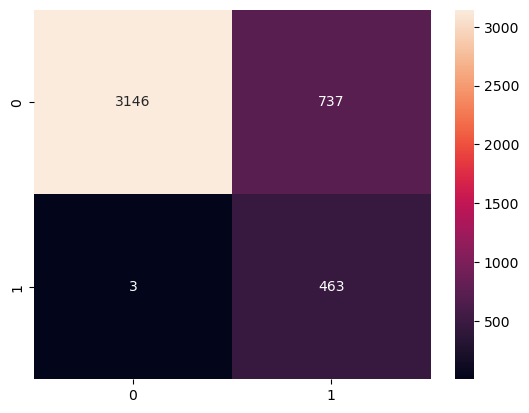

In [839]:
sns.heatmap(confusion_matrix(y_train_sampled,  train_preds), annot=True, fmt='g')

In [840]:
final_cols = X_train_feature_test.columns

In [841]:
final_cols = X_train_sampled_ft_auto.columns

In [845]:
X_test_transformed = preprocessor.transform(X_test)
cat_col_names = preprocessor.transformers_[1][1]\
.named_steps['encoder'].get_feature_names_out()
col_names = ['Age', 'avg_glucose_level', 'bmi'] + list(cat_col_names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=col_names)
lim_cols = X_train_sampled_unscaled.columns
X_test_transformed = auto_features.transform(X_test_transformed[lim_cols], cols)
X_test_transformed = add_features(X_test_transformed)
X_test_transformed = cluster_data(X_test_transformed)
X_test_transformed = pd.get_dummies(X_test_transformed)
X_test_transformed.columns = X_test_transformed.columns.str.replace(r'[\(\)\[\]\<\>\,]', '')

[AutoFeat] Computing 33 new features.
[AutoFeat]    33/   33 new features ...done.


Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
The default value of regex will change from True to False in a future version.


In [846]:
X_test_transformed = X_test_transformed[final_cols]

In [847]:
y_preds = cat_search_2.predict(X_test_transformed)

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)

<AxesSubplot:>

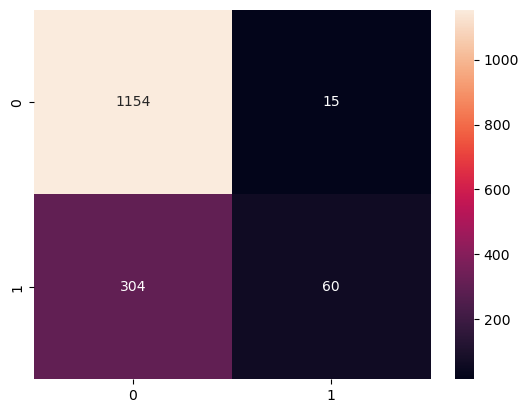

In [848]:
sns.heatmap(confusion_matrix(y_preds,  y_test), annot=True, fmt='g')

In [849]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1458
           1       0.16      0.80      0.27        75

    accuracy                           0.79      1533
   macro avg       0.58      0.80      0.58      1533
weighted avg       0.95      0.79      0.85      1533



## Hypertension

### Simple Models

In [850]:
X = stroke.drop(['stroke', 'hypertension'], axis=1)
y = stroke['hypertension']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

In [867]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [868]:
model_set_a = [LogisticRegression(random_state=42), SVC(
    random_state=42, probability=True), GaussianNB(),
               KNeighborsClassifier(n_neighbors=2)]

In [869]:
preprocessor = make_preprocessor(X_train)

In [870]:
simple_models = cross_validate_model(model_set_a)
simple_models.style.background_gradient(cmap='Reds')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [874]:
preprocessor = make_preprocessor(X_train, scaler=False)

In [875]:
tree_based = [DecisionTreeClassifier(random_state=42),
              RandomForestClassifier(random_state=42),
              AdaBoostClassifier(random_state=42),
              GradientBoostingClassifier(random_state=42), 
             XGBClassifier(random_state=42),
             LGBMClassifier(random_state=42),
             CatBoostClassifier(random_state=42)]

In [877]:
tree_models = cross_validate_model(tree_based)
tree_models.style.background_gradient(cmap='Reds')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

Learning rate set to 0.018793
0:	learn: 0.6595944	total: 4.63ms	remaining: 4.63s
1:	learn: 0.6348311	total: 6.3ms	remaining: 3.14s
2:	learn: 0.6108406	total: 7.99ms	remaining: 2.65s
3:	learn: 0.5834887	total: 9.64ms	remaining: 2.4s
4:	learn: 0.5572549	total: 11.5ms	remaining: 2.29s
5:	learn: 0.5351969	total: 13.9ms	remaining: 2.3s
6:	learn: 0.5138179	total: 15.5ms	remaining: 2.2s
7:	learn: 0.4900752	total: 17.3ms	remaining: 2.15s
8:	learn: 0.4744766	total: 18.3ms	remaining: 2.02s
9:	learn: 0.4584059	total: 19.7ms	remaining: 1.95s
10:	learn: 0.4405029	total: 21.3ms	remaining: 1.92s
11:	learn: 0.4256520	total: 22.9ms	remaining: 1.89s
12:	learn: 0.4101422	total: 24.9ms	remaining: 1.89s
13:	learn: 0.3960017	total: 26.7ms	remaining: 1.88s
14:	learn: 0.3821422	total: 28.4ms	remaining: 1.86s
15:	learn: 0.3709981	total: 30.3ms	remaining: 1.86s
16:	learn: 0.3565457	total: 32.1ms	remaining: 1.86s
17:	learn: 0.3454662	total: 34.4ms	remaining: 1.87s
18:	learn: 0.3359671	total: 36.1ms	remaining: 1.

211:	learn: 0.1287802	total: 393ms	remaining: 1.46s
212:	learn: 0.1286388	total: 394ms	remaining: 1.46s
213:	learn: 0.1285881	total: 396ms	remaining: 1.45s
214:	learn: 0.1284651	total: 398ms	remaining: 1.45s
215:	learn: 0.1283755	total: 399ms	remaining: 1.45s
216:	learn: 0.1282355	total: 401ms	remaining: 1.45s
217:	learn: 0.1281273	total: 404ms	remaining: 1.45s
218:	learn: 0.1279349	total: 406ms	remaining: 1.45s
219:	learn: 0.1277515	total: 407ms	remaining: 1.44s
220:	learn: 0.1275994	total: 409ms	remaining: 1.44s
221:	learn: 0.1274966	total: 410ms	remaining: 1.44s
222:	learn: 0.1274075	total: 412ms	remaining: 1.44s
223:	learn: 0.1272975	total: 413ms	remaining: 1.43s
224:	learn: 0.1271256	total: 415ms	remaining: 1.43s
225:	learn: 0.1270500	total: 417ms	remaining: 1.43s
226:	learn: 0.1269637	total: 419ms	remaining: 1.43s
227:	learn: 0.1268794	total: 420ms	remaining: 1.42s
228:	learn: 0.1268133	total: 422ms	remaining: 1.42s
229:	learn: 0.1266823	total: 424ms	remaining: 1.42s
230:	learn: 

430:	learn: 0.1063286	total: 788ms	remaining: 1.04s
431:	learn: 0.1062549	total: 790ms	remaining: 1.04s
432:	learn: 0.1061468	total: 791ms	remaining: 1.04s
433:	learn: 0.1061116	total: 793ms	remaining: 1.03s
434:	learn: 0.1060030	total: 795ms	remaining: 1.03s
435:	learn: 0.1058979	total: 797ms	remaining: 1.03s
436:	learn: 0.1057936	total: 799ms	remaining: 1.03s
437:	learn: 0.1056902	total: 800ms	remaining: 1.03s
438:	learn: 0.1056067	total: 802ms	remaining: 1.02s
439:	learn: 0.1055247	total: 803ms	remaining: 1.02s
440:	learn: 0.1054303	total: 805ms	remaining: 1.02s
441:	learn: 0.1053153	total: 806ms	remaining: 1.02s
442:	learn: 0.1052393	total: 807ms	remaining: 1.01s
443:	learn: 0.1051779	total: 809ms	remaining: 1.01s
444:	learn: 0.1051203	total: 810ms	remaining: 1.01s
445:	learn: 0.1050315	total: 812ms	remaining: 1.01s
446:	learn: 0.1049527	total: 814ms	remaining: 1.01s
447:	learn: 0.1048608	total: 816ms	remaining: 1s
448:	learn: 0.1047354	total: 817ms	remaining: 1s
449:	learn: 0.1046

646:	learn: 0.0901004	total: 1.18s	remaining: 645ms
647:	learn: 0.0900618	total: 1.18s	remaining: 644ms
648:	learn: 0.0899940	total: 1.19s	remaining: 642ms
649:	learn: 0.0899741	total: 1.19s	remaining: 640ms
650:	learn: 0.0899077	total: 1.19s	remaining: 638ms
651:	learn: 0.0898629	total: 1.19s	remaining: 636ms
652:	learn: 0.0898161	total: 1.19s	remaining: 634ms
653:	learn: 0.0897344	total: 1.2s	remaining: 632ms
654:	learn: 0.0896612	total: 1.2s	remaining: 630ms
655:	learn: 0.0895801	total: 1.2s	remaining: 629ms
656:	learn: 0.0895431	total: 1.2s	remaining: 627ms
657:	learn: 0.0894882	total: 1.2s	remaining: 626ms
658:	learn: 0.0894373	total: 1.2s	remaining: 623ms
659:	learn: 0.0894088	total: 1.21s	remaining: 622ms
660:	learn: 0.0893132	total: 1.21s	remaining: 620ms
661:	learn: 0.0892376	total: 1.21s	remaining: 618ms
662:	learn: 0.0891777	total: 1.21s	remaining: 617ms
663:	learn: 0.0891288	total: 1.21s	remaining: 615ms
664:	learn: 0.0890466	total: 1.22s	remaining: 613ms
665:	learn: 0.0889

848:	learn: 0.0796307	total: 1.57s	remaining: 279ms
849:	learn: 0.0796239	total: 1.57s	remaining: 277ms
850:	learn: 0.0796036	total: 1.57s	remaining: 275ms
851:	learn: 0.0795901	total: 1.58s	remaining: 274ms
852:	learn: 0.0795769	total: 1.58s	remaining: 272ms
853:	learn: 0.0795433	total: 1.58s	remaining: 270ms
854:	learn: 0.0795368	total: 1.58s	remaining: 268ms
855:	learn: 0.0794854	total: 1.58s	remaining: 266ms
856:	learn: 0.0794608	total: 1.58s	remaining: 265ms
857:	learn: 0.0794166	total: 1.59s	remaining: 263ms
858:	learn: 0.0793705	total: 1.59s	remaining: 261ms
859:	learn: 0.0793164	total: 1.59s	remaining: 259ms
860:	learn: 0.0792696	total: 1.59s	remaining: 257ms
861:	learn: 0.0792198	total: 1.59s	remaining: 255ms
862:	learn: 0.0791678	total: 1.6s	remaining: 253ms
863:	learn: 0.0791223	total: 1.6s	remaining: 252ms
864:	learn: 0.0791146	total: 1.6s	remaining: 250ms
865:	learn: 0.0790558	total: 1.6s	remaining: 248ms
866:	learn: 0.0790231	total: 1.6s	remaining: 246ms
867:	learn: 0.079

29:	learn: 0.2601052	total: 45.2ms	remaining: 1.46s
30:	learn: 0.2541974	total: 46.7ms	remaining: 1.46s
31:	learn: 0.2486762	total: 48.3ms	remaining: 1.46s
32:	learn: 0.2434109	total: 49.9ms	remaining: 1.46s
33:	learn: 0.2395013	total: 52.5ms	remaining: 1.49s
34:	learn: 0.2349525	total: 54.4ms	remaining: 1.5s
35:	learn: 0.2319786	total: 55.6ms	remaining: 1.49s
36:	learn: 0.2291255	total: 57.1ms	remaining: 1.49s
37:	learn: 0.2261918	total: 58.7ms	remaining: 1.49s
38:	learn: 0.2235067	total: 59.8ms	remaining: 1.47s
39:	learn: 0.2207281	total: 61ms	remaining: 1.46s
40:	learn: 0.2180848	total: 62.4ms	remaining: 1.46s
41:	learn: 0.2158560	total: 63.8ms	remaining: 1.46s
42:	learn: 0.2128460	total: 65.1ms	remaining: 1.45s
43:	learn: 0.2109427	total: 65.8ms	remaining: 1.43s
44:	learn: 0.2087322	total: 67.4ms	remaining: 1.43s
45:	learn: 0.2065478	total: 68.6ms	remaining: 1.42s
46:	learn: 0.2036724	total: 69.8ms	remaining: 1.42s
47:	learn: 0.2008568	total: 71.4ms	remaining: 1.42s
48:	learn: 0.19

248:	learn: 0.1239821	total: 433ms	remaining: 1.31s
249:	learn: 0.1238290	total: 435ms	remaining: 1.3s
250:	learn: 0.1237039	total: 436ms	remaining: 1.3s
251:	learn: 0.1235760	total: 438ms	remaining: 1.3s
252:	learn: 0.1234560	total: 439ms	remaining: 1.3s
253:	learn: 0.1233644	total: 441ms	remaining: 1.29s
254:	learn: 0.1232604	total: 442ms	remaining: 1.29s
255:	learn: 0.1231723	total: 444ms	remaining: 1.29s
256:	learn: 0.1230630	total: 446ms	remaining: 1.29s
257:	learn: 0.1230190	total: 447ms	remaining: 1.29s
258:	learn: 0.1229471	total: 449ms	remaining: 1.28s
259:	learn: 0.1227865	total: 450ms	remaining: 1.28s
260:	learn: 0.1226192	total: 452ms	remaining: 1.28s
261:	learn: 0.1225397	total: 461ms	remaining: 1.3s
262:	learn: 0.1224676	total: 463ms	remaining: 1.3s
263:	learn: 0.1223727	total: 464ms	remaining: 1.29s
264:	learn: 0.1222704	total: 466ms	remaining: 1.29s
265:	learn: 0.1221532	total: 468ms	remaining: 1.29s
266:	learn: 0.1220522	total: 469ms	remaining: 1.29s
267:	learn: 0.1219

474:	learn: 0.1017977	total: 829ms	remaining: 916ms
475:	learn: 0.1016653	total: 831ms	remaining: 915ms
476:	learn: 0.1015302	total: 833ms	remaining: 913ms
477:	learn: 0.1014309	total: 834ms	remaining: 911ms
478:	learn: 0.1013472	total: 836ms	remaining: 909ms
479:	learn: 0.1012379	total: 838ms	remaining: 908ms
480:	learn: 0.1011542	total: 839ms	remaining: 906ms
481:	learn: 0.1010773	total: 841ms	remaining: 904ms
482:	learn: 0.1009975	total: 842ms	remaining: 902ms
483:	learn: 0.1009406	total: 844ms	remaining: 900ms
484:	learn: 0.1008872	total: 846ms	remaining: 898ms
485:	learn: 0.1008247	total: 847ms	remaining: 896ms
486:	learn: 0.1007363	total: 849ms	remaining: 894ms
487:	learn: 0.1006490	total: 850ms	remaining: 892ms
488:	learn: 0.1005335	total: 852ms	remaining: 890ms
489:	learn: 0.1004906	total: 853ms	remaining: 888ms
490:	learn: 0.1004257	total: 855ms	remaining: 886ms
491:	learn: 0.1003471	total: 857ms	remaining: 885ms
492:	learn: 0.1002338	total: 858ms	remaining: 883ms
493:	learn: 

703:	learn: 0.0847248	total: 1.23s	remaining: 516ms
704:	learn: 0.0846837	total: 1.23s	remaining: 514ms
705:	learn: 0.0846045	total: 1.23s	remaining: 512ms
706:	learn: 0.0845212	total: 1.23s	remaining: 510ms
707:	learn: 0.0844538	total: 1.23s	remaining: 508ms
708:	learn: 0.0844099	total: 1.23s	remaining: 507ms
709:	learn: 0.0843997	total: 1.24s	remaining: 505ms
710:	learn: 0.0843608	total: 1.24s	remaining: 503ms
711:	learn: 0.0842888	total: 1.24s	remaining: 501ms
712:	learn: 0.0842283	total: 1.24s	remaining: 499ms
713:	learn: 0.0841698	total: 1.24s	remaining: 498ms
714:	learn: 0.0841003	total: 1.24s	remaining: 496ms
715:	learn: 0.0840277	total: 1.25s	remaining: 494ms
716:	learn: 0.0839713	total: 1.25s	remaining: 492ms
717:	learn: 0.0839032	total: 1.25s	remaining: 490ms
718:	learn: 0.0838489	total: 1.25s	remaining: 489ms
719:	learn: 0.0837879	total: 1.25s	remaining: 487ms
720:	learn: 0.0837330	total: 1.25s	remaining: 485ms
721:	learn: 0.0836646	total: 1.25s	remaining: 483ms
722:	learn: 

925:	learn: 0.0727708	total: 1.62s	remaining: 130ms
926:	learn: 0.0727356	total: 1.62s	remaining: 128ms
927:	learn: 0.0727133	total: 1.62s	remaining: 126ms
928:	learn: 0.0726801	total: 1.63s	remaining: 124ms
929:	learn: 0.0725989	total: 1.63s	remaining: 122ms
930:	learn: 0.0725306	total: 1.63s	remaining: 121ms
931:	learn: 0.0724639	total: 1.63s	remaining: 119ms
932:	learn: 0.0724370	total: 1.63s	remaining: 117ms
933:	learn: 0.0723948	total: 1.63s	remaining: 115ms
934:	learn: 0.0723298	total: 1.64s	remaining: 114ms
935:	learn: 0.0722773	total: 1.64s	remaining: 112ms
936:	learn: 0.0722351	total: 1.64s	remaining: 110ms
937:	learn: 0.0721819	total: 1.64s	remaining: 108ms
938:	learn: 0.0721185	total: 1.64s	remaining: 107ms
939:	learn: 0.0720873	total: 1.64s	remaining: 105ms
940:	learn: 0.0720241	total: 1.64s	remaining: 103ms
941:	learn: 0.0719629	total: 1.65s	remaining: 101ms
942:	learn: 0.0719314	total: 1.65s	remaining: 99.6ms
943:	learn: 0.0719036	total: 1.65s	remaining: 97.8ms
944:	learn

138:	learn: 0.1416101	total: 231ms	remaining: 1.43s
139:	learn: 0.1414503	total: 233ms	remaining: 1.43s
140:	learn: 0.1412548	total: 235ms	remaining: 1.43s
141:	learn: 0.1411565	total: 237ms	remaining: 1.43s
142:	learn: 0.1410006	total: 238ms	remaining: 1.43s
143:	learn: 0.1407100	total: 240ms	remaining: 1.43s
144:	learn: 0.1404854	total: 242ms	remaining: 1.43s
145:	learn: 0.1403041	total: 244ms	remaining: 1.43s
146:	learn: 0.1400583	total: 245ms	remaining: 1.42s
147:	learn: 0.1398339	total: 247ms	remaining: 1.42s
148:	learn: 0.1395632	total: 249ms	remaining: 1.42s
149:	learn: 0.1394100	total: 250ms	remaining: 1.42s
150:	learn: 0.1392336	total: 251ms	remaining: 1.41s
151:	learn: 0.1390638	total: 253ms	remaining: 1.41s
152:	learn: 0.1388597	total: 255ms	remaining: 1.41s
153:	learn: 0.1386879	total: 256ms	remaining: 1.41s
154:	learn: 0.1384961	total: 258ms	remaining: 1.41s
155:	learn: 0.1382716	total: 260ms	remaining: 1.4s
156:	learn: 0.1380368	total: 261ms	remaining: 1.4s
157:	learn: 0.

363:	learn: 0.1113524	total: 626ms	remaining: 1.09s
364:	learn: 0.1112206	total: 628ms	remaining: 1.09s
365:	learn: 0.1111453	total: 630ms	remaining: 1.09s
366:	learn: 0.1110585	total: 632ms	remaining: 1.09s
367:	learn: 0.1109867	total: 633ms	remaining: 1.09s
368:	learn: 0.1109065	total: 635ms	remaining: 1.08s
369:	learn: 0.1107588	total: 636ms	remaining: 1.08s
370:	learn: 0.1106855	total: 638ms	remaining: 1.08s
371:	learn: 0.1106127	total: 640ms	remaining: 1.08s
372:	learn: 0.1105656	total: 642ms	remaining: 1.08s
373:	learn: 0.1105122	total: 643ms	remaining: 1.08s
374:	learn: 0.1104181	total: 645ms	remaining: 1.07s
375:	learn: 0.1103547	total: 646ms	remaining: 1.07s
376:	learn: 0.1102842	total: 647ms	remaining: 1.07s
377:	learn: 0.1101548	total: 649ms	remaining: 1.07s
378:	learn: 0.1100239	total: 650ms	remaining: 1.06s
379:	learn: 0.1099526	total: 652ms	remaining: 1.06s
380:	learn: 0.1098593	total: 654ms	remaining: 1.06s
381:	learn: 0.1097028	total: 656ms	remaining: 1.06s
382:	learn: 

590:	learn: 0.0928837	total: 1.02s	remaining: 707ms
591:	learn: 0.0928310	total: 1.02s	remaining: 705ms
592:	learn: 0.0927790	total: 1.02s	remaining: 703ms
593:	learn: 0.0927096	total: 1.02s	remaining: 701ms
594:	learn: 0.0926542	total: 1.03s	remaining: 699ms
595:	learn: 0.0925875	total: 1.03s	remaining: 698ms
596:	learn: 0.0925317	total: 1.03s	remaining: 696ms
597:	learn: 0.0924986	total: 1.03s	remaining: 694ms
598:	learn: 0.0924360	total: 1.03s	remaining: 692ms
599:	learn: 0.0924093	total: 1.03s	remaining: 691ms
600:	learn: 0.0923431	total: 1.04s	remaining: 689ms
601:	learn: 0.0922727	total: 1.04s	remaining: 687ms
602:	learn: 0.0921842	total: 1.04s	remaining: 685ms
603:	learn: 0.0920676	total: 1.04s	remaining: 683ms
604:	learn: 0.0919293	total: 1.04s	remaining: 681ms
605:	learn: 0.0918386	total: 1.04s	remaining: 680ms
606:	learn: 0.0917571	total: 1.05s	remaining: 678ms
607:	learn: 0.0916843	total: 1.05s	remaining: 676ms
608:	learn: 0.0916296	total: 1.05s	remaining: 674ms
609:	learn: 

817:	learn: 0.0801596	total: 1.42s	remaining: 315ms
818:	learn: 0.0801308	total: 1.42s	remaining: 314ms
819:	learn: 0.0801123	total: 1.42s	remaining: 312ms
820:	learn: 0.0800834	total: 1.42s	remaining: 310ms
821:	learn: 0.0800280	total: 1.42s	remaining: 308ms
822:	learn: 0.0799682	total: 1.43s	remaining: 307ms
823:	learn: 0.0799291	total: 1.43s	remaining: 305ms
824:	learn: 0.0798962	total: 1.43s	remaining: 303ms
825:	learn: 0.0798584	total: 1.43s	remaining: 301ms
826:	learn: 0.0798264	total: 1.43s	remaining: 300ms
827:	learn: 0.0797618	total: 1.43s	remaining: 298ms
828:	learn: 0.0797182	total: 1.44s	remaining: 296ms
829:	learn: 0.0796764	total: 1.44s	remaining: 294ms
830:	learn: 0.0796140	total: 1.44s	remaining: 292ms
831:	learn: 0.0795562	total: 1.44s	remaining: 291ms
832:	learn: 0.0794899	total: 1.44s	remaining: 289ms
833:	learn: 0.0794500	total: 1.44s	remaining: 287ms
834:	learn: 0.0793897	total: 1.44s	remaining: 285ms
835:	learn: 0.0793648	total: 1.45s	remaining: 284ms
836:	learn: 

29:	learn: 0.2617999	total: 50ms	remaining: 1.61s
30:	learn: 0.2557376	total: 51.6ms	remaining: 1.61s
31:	learn: 0.2501251	total: 53.3ms	remaining: 1.61s
32:	learn: 0.2449021	total: 54.9ms	remaining: 1.61s
33:	learn: 0.2410377	total: 56.6ms	remaining: 1.61s
34:	learn: 0.2368191	total: 58.2ms	remaining: 1.6s
35:	learn: 0.2337943	total: 59.7ms	remaining: 1.6s
36:	learn: 0.2309035	total: 61.8ms	remaining: 1.61s
37:	learn: 0.2279579	total: 63.8ms	remaining: 1.61s
38:	learn: 0.2252340	total: 65.2ms	remaining: 1.6s
39:	learn: 0.2224030	total: 66.4ms	remaining: 1.59s
40:	learn: 0.2195340	total: 68ms	remaining: 1.59s
41:	learn: 0.2172276	total: 69.6ms	remaining: 1.59s
42:	learn: 0.2141481	total: 71ms	remaining: 1.58s
43:	learn: 0.2122135	total: 71.9ms	remaining: 1.56s
44:	learn: 0.2092194	total: 73.5ms	remaining: 1.56s
45:	learn: 0.2064909	total: 75.4ms	remaining: 1.56s
46:	learn: 0.2039171	total: 77.3ms	remaining: 1.57s
47:	learn: 0.2013528	total: 79ms	remaining: 1.57s
48:	learn: 0.1986939	to

260:	learn: 0.1222854	total: 446ms	remaining: 1.26s
261:	learn: 0.1221934	total: 448ms	remaining: 1.26s
262:	learn: 0.1220983	total: 449ms	remaining: 1.26s
263:	learn: 0.1220140	total: 451ms	remaining: 1.26s
264:	learn: 0.1219094	total: 453ms	remaining: 1.26s
265:	learn: 0.1217812	total: 455ms	remaining: 1.25s
266:	learn: 0.1216763	total: 456ms	remaining: 1.25s
267:	learn: 0.1215443	total: 458ms	remaining: 1.25s
268:	learn: 0.1214451	total: 459ms	remaining: 1.25s
269:	learn: 0.1213310	total: 461ms	remaining: 1.25s
270:	learn: 0.1211856	total: 463ms	remaining: 1.24s
271:	learn: 0.1210920	total: 464ms	remaining: 1.24s
272:	learn: 0.1209492	total: 465ms	remaining: 1.24s
273:	learn: 0.1208748	total: 467ms	remaining: 1.24s
274:	learn: 0.1207892	total: 468ms	remaining: 1.23s
275:	learn: 0.1206856	total: 470ms	remaining: 1.23s
276:	learn: 0.1206075	total: 471ms	remaining: 1.23s
277:	learn: 0.1204936	total: 472ms	remaining: 1.23s
278:	learn: 0.1203499	total: 474ms	remaining: 1.23s
279:	learn: 

493:	learn: 0.1012230	total: 842ms	remaining: 863ms
494:	learn: 0.1011585	total: 844ms	remaining: 861ms
495:	learn: 0.1010931	total: 845ms	remaining: 859ms
496:	learn: 0.1010032	total: 847ms	remaining: 857ms
497:	learn: 0.1008881	total: 848ms	remaining: 855ms
498:	learn: 0.1007877	total: 850ms	remaining: 853ms
499:	learn: 0.1006736	total: 851ms	remaining: 851ms
500:	learn: 0.1005977	total: 853ms	remaining: 850ms
501:	learn: 0.1005218	total: 855ms	remaining: 848ms
502:	learn: 0.1004776	total: 857ms	remaining: 846ms
503:	learn: 0.1004465	total: 858ms	remaining: 845ms
504:	learn: 0.1003771	total: 860ms	remaining: 843ms
505:	learn: 0.1003064	total: 861ms	remaining: 841ms
506:	learn: 0.1002310	total: 863ms	remaining: 839ms
507:	learn: 0.1001517	total: 864ms	remaining: 837ms
508:	learn: 0.1000918	total: 866ms	remaining: 835ms
509:	learn: 0.0999625	total: 867ms	remaining: 833ms
510:	learn: 0.0999017	total: 869ms	remaining: 831ms
511:	learn: 0.0997646	total: 870ms	remaining: 830ms
512:	learn: 

744:	learn: 0.0840876	total: 1.22s	remaining: 418ms
745:	learn: 0.0840536	total: 1.22s	remaining: 416ms
746:	learn: 0.0839772	total: 1.22s	remaining: 415ms
747:	learn: 0.0839332	total: 1.23s	remaining: 413ms
748:	learn: 0.0838764	total: 1.23s	remaining: 411ms
749:	learn: 0.0838057	total: 1.23s	remaining: 410ms
750:	learn: 0.0837406	total: 1.23s	remaining: 408ms
751:	learn: 0.0836392	total: 1.23s	remaining: 406ms
752:	learn: 0.0835635	total: 1.23s	remaining: 405ms
753:	learn: 0.0835427	total: 1.23s	remaining: 403ms
754:	learn: 0.0834797	total: 1.24s	remaining: 401ms
755:	learn: 0.0834347	total: 1.24s	remaining: 400ms
756:	learn: 0.0833793	total: 1.24s	remaining: 398ms
757:	learn: 0.0833062	total: 1.24s	remaining: 396ms
758:	learn: 0.0832793	total: 1.24s	remaining: 395ms
759:	learn: 0.0832111	total: 1.24s	remaining: 393ms
760:	learn: 0.0831848	total: 1.25s	remaining: 391ms
761:	learn: 0.0831238	total: 1.25s	remaining: 390ms
762:	learn: 0.0830730	total: 1.25s	remaining: 388ms
763:	learn: 

979:	learn: 0.0728164	total: 1.62s	remaining: 33ms
980:	learn: 0.0727977	total: 1.62s	remaining: 31.4ms
981:	learn: 0.0727737	total: 1.62s	remaining: 29.7ms
982:	learn: 0.0727047	total: 1.62s	remaining: 28.1ms
983:	learn: 0.0726746	total: 1.62s	remaining: 26.4ms
984:	learn: 0.0726500	total: 1.63s	remaining: 24.8ms
985:	learn: 0.0726209	total: 1.63s	remaining: 23.1ms
986:	learn: 0.0725972	total: 1.63s	remaining: 21.5ms
987:	learn: 0.0725684	total: 1.63s	remaining: 19.8ms
988:	learn: 0.0725080	total: 1.63s	remaining: 18.2ms
989:	learn: 0.0724896	total: 1.63s	remaining: 16.5ms
990:	learn: 0.0724680	total: 1.64s	remaining: 14.9ms
991:	learn: 0.0724069	total: 1.64s	remaining: 13.2ms
992:	learn: 0.0723832	total: 1.64s	remaining: 11.5ms
993:	learn: 0.0723600	total: 1.64s	remaining: 9.9ms
994:	learn: 0.0723321	total: 1.64s	remaining: 8.25ms
995:	learn: 0.0722868	total: 1.64s	remaining: 6.6ms
996:	learn: 0.0722607	total: 1.64s	remaining: 4.95ms
997:	learn: 0.0722342	total: 1.65s	remaining: 3.3m

195:	learn: 0.1280922	total: 331ms	remaining: 1.36s
196:	learn: 0.1279608	total: 333ms	remaining: 1.36s
197:	learn: 0.1278788	total: 335ms	remaining: 1.35s
198:	learn: 0.1277473	total: 336ms	remaining: 1.35s
199:	learn: 0.1275774	total: 338ms	remaining: 1.35s
200:	learn: 0.1274030	total: 340ms	remaining: 1.35s
201:	learn: 0.1273161	total: 341ms	remaining: 1.35s
202:	learn: 0.1271450	total: 343ms	remaining: 1.35s
203:	learn: 0.1269850	total: 345ms	remaining: 1.34s
204:	learn: 0.1268055	total: 346ms	remaining: 1.34s
205:	learn: 0.1266453	total: 348ms	remaining: 1.34s
206:	learn: 0.1264764	total: 349ms	remaining: 1.34s
207:	learn: 0.1263300	total: 351ms	remaining: 1.34s
208:	learn: 0.1260976	total: 353ms	remaining: 1.33s
209:	learn: 0.1259156	total: 355ms	remaining: 1.33s
210:	learn: 0.1257228	total: 356ms	remaining: 1.33s
211:	learn: 0.1255474	total: 358ms	remaining: 1.33s
212:	learn: 0.1254675	total: 360ms	remaining: 1.33s
213:	learn: 0.1253590	total: 362ms	remaining: 1.33s
214:	learn: 

424:	learn: 0.1036038	total: 726ms	remaining: 983ms
425:	learn: 0.1035447	total: 728ms	remaining: 981ms
426:	learn: 0.1034570	total: 730ms	remaining: 980ms
427:	learn: 0.1033613	total: 732ms	remaining: 978ms
428:	learn: 0.1032843	total: 733ms	remaining: 976ms
429:	learn: 0.1031578	total: 735ms	remaining: 974ms
430:	learn: 0.1031145	total: 737ms	remaining: 973ms
431:	learn: 0.1030623	total: 738ms	remaining: 971ms
432:	learn: 0.1028735	total: 740ms	remaining: 969ms
433:	learn: 0.1027795	total: 741ms	remaining: 967ms
434:	learn: 0.1027226	total: 743ms	remaining: 965ms
435:	learn: 0.1025755	total: 745ms	remaining: 963ms
436:	learn: 0.1024856	total: 747ms	remaining: 962ms
437:	learn: 0.1023986	total: 748ms	remaining: 960ms
438:	learn: 0.1022689	total: 750ms	remaining: 959ms
439:	learn: 0.1022221	total: 752ms	remaining: 957ms
440:	learn: 0.1021477	total: 754ms	remaining: 955ms
441:	learn: 0.1020505	total: 755ms	remaining: 954ms
442:	learn: 0.1019662	total: 757ms	remaining: 952ms
443:	learn: 

652:	learn: 0.0853935	total: 1.12s	remaining: 596ms
653:	learn: 0.0853381	total: 1.12s	remaining: 594ms
654:	learn: 0.0852764	total: 1.12s	remaining: 592ms
655:	learn: 0.0852414	total: 1.13s	remaining: 591ms
656:	learn: 0.0851642	total: 1.13s	remaining: 589ms
657:	learn: 0.0850687	total: 1.13s	remaining: 587ms
658:	learn: 0.0850025	total: 1.13s	remaining: 585ms
659:	learn: 0.0849246	total: 1.13s	remaining: 584ms
660:	learn: 0.0848521	total: 1.13s	remaining: 582ms
661:	learn: 0.0847765	total: 1.14s	remaining: 580ms
662:	learn: 0.0847303	total: 1.14s	remaining: 578ms
663:	learn: 0.0846215	total: 1.14s	remaining: 576ms
664:	learn: 0.0845880	total: 1.14s	remaining: 575ms
665:	learn: 0.0845313	total: 1.14s	remaining: 573ms
666:	learn: 0.0844717	total: 1.14s	remaining: 571ms
667:	learn: 0.0844232	total: 1.15s	remaining: 570ms
668:	learn: 0.0843899	total: 1.15s	remaining: 569ms
669:	learn: 0.0843086	total: 1.15s	remaining: 567ms
670:	learn: 0.0842508	total: 1.15s	remaining: 565ms
671:	learn: 

881:	learn: 0.0728333	total: 1.52s	remaining: 203ms
882:	learn: 0.0727765	total: 1.52s	remaining: 201ms
883:	learn: 0.0727605	total: 1.52s	remaining: 200ms
884:	learn: 0.0726900	total: 1.52s	remaining: 198ms
885:	learn: 0.0726555	total: 1.53s	remaining: 197ms
886:	learn: 0.0726219	total: 1.53s	remaining: 196ms
887:	learn: 0.0725894	total: 1.54s	remaining: 194ms
888:	learn: 0.0725473	total: 1.54s	remaining: 192ms
889:	learn: 0.0724737	total: 1.54s	remaining: 190ms
890:	learn: 0.0724225	total: 1.54s	remaining: 188ms
891:	learn: 0.0723643	total: 1.54s	remaining: 187ms
892:	learn: 0.0723340	total: 1.55s	remaining: 186ms
893:	learn: 0.0722846	total: 1.55s	remaining: 184ms
894:	learn: 0.0722432	total: 1.56s	remaining: 183ms
895:	learn: 0.0722291	total: 1.56s	remaining: 181ms
896:	learn: 0.0721742	total: 1.56s	remaining: 179ms
897:	learn: 0.0721005	total: 1.56s	remaining: 177ms
898:	learn: 0.0720579	total: 1.56s	remaining: 176ms
899:	learn: 0.0719414	total: 1.56s	remaining: 174ms
900:	learn: 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


86:	learn: 0.1594391	total: 141ms	remaining: 1.47s
87:	learn: 0.1589686	total: 142ms	remaining: 1.47s
88:	learn: 0.1587000	total: 143ms	remaining: 1.47s
89:	learn: 0.1580975	total: 145ms	remaining: 1.46s
90:	learn: 0.1575894	total: 146ms	remaining: 1.46s
91:	learn: 0.1569973	total: 148ms	remaining: 1.46s
92:	learn: 0.1565247	total: 149ms	remaining: 1.46s
93:	learn: 0.1558646	total: 151ms	remaining: 1.46s
94:	learn: 0.1554805	total: 153ms	remaining: 1.46s
95:	learn: 0.1550917	total: 155ms	remaining: 1.46s
96:	learn: 0.1548381	total: 157ms	remaining: 1.46s
97:	learn: 0.1545042	total: 158ms	remaining: 1.46s
98:	learn: 0.1541298	total: 160ms	remaining: 1.45s
99:	learn: 0.1536261	total: 161ms	remaining: 1.45s
100:	learn: 0.1532288	total: 163ms	remaining: 1.45s
101:	learn: 0.1528636	total: 165ms	remaining: 1.45s
102:	learn: 0.1523942	total: 166ms	remaining: 1.45s
103:	learn: 0.1520718	total: 168ms	remaining: 1.45s
104:	learn: 0.1516283	total: 170ms	remaining: 1.45s
105:	learn: 0.1513264	tota

311:	learn: 0.1156543	total: 536ms	remaining: 1.18s
312:	learn: 0.1154869	total: 538ms	remaining: 1.18s
313:	learn: 0.1153707	total: 539ms	remaining: 1.18s
314:	learn: 0.1152773	total: 541ms	remaining: 1.18s
315:	learn: 0.1151055	total: 543ms	remaining: 1.17s
316:	learn: 0.1149991	total: 544ms	remaining: 1.17s
317:	learn: 0.1149487	total: 546ms	remaining: 1.17s
318:	learn: 0.1147978	total: 548ms	remaining: 1.17s
319:	learn: 0.1146876	total: 549ms	remaining: 1.17s
320:	learn: 0.1145426	total: 551ms	remaining: 1.17s
321:	learn: 0.1144492	total: 553ms	remaining: 1.16s
322:	learn: 0.1143069	total: 554ms	remaining: 1.16s
323:	learn: 0.1141594	total: 555ms	remaining: 1.16s
324:	learn: 0.1140740	total: 557ms	remaining: 1.16s
325:	learn: 0.1140192	total: 559ms	remaining: 1.15s
326:	learn: 0.1139347	total: 560ms	remaining: 1.15s
327:	learn: 0.1137299	total: 562ms	remaining: 1.15s
328:	learn: 0.1135820	total: 564ms	remaining: 1.15s
329:	learn: 0.1135059	total: 566ms	remaining: 1.15s
330:	learn: 

538:	learn: 0.0952878	total: 932ms	remaining: 797ms
539:	learn: 0.0951907	total: 934ms	remaining: 796ms
540:	learn: 0.0950911	total: 936ms	remaining: 794ms
541:	learn: 0.0950331	total: 937ms	remaining: 792ms
542:	learn: 0.0949783	total: 939ms	remaining: 790ms
543:	learn: 0.0949155	total: 941ms	remaining: 788ms
544:	learn: 0.0948426	total: 942ms	remaining: 787ms
545:	learn: 0.0947061	total: 944ms	remaining: 785ms
546:	learn: 0.0945887	total: 945ms	remaining: 783ms
547:	learn: 0.0944704	total: 947ms	remaining: 781ms
548:	learn: 0.0943853	total: 949ms	remaining: 779ms
549:	learn: 0.0943063	total: 950ms	remaining: 777ms
550:	learn: 0.0942476	total: 952ms	remaining: 776ms
551:	learn: 0.0941940	total: 954ms	remaining: 774ms
552:	learn: 0.0941399	total: 956ms	remaining: 772ms
553:	learn: 0.0940350	total: 957ms	remaining: 771ms
554:	learn: 0.0939244	total: 959ms	remaining: 769ms
555:	learn: 0.0938329	total: 961ms	remaining: 767ms
556:	learn: 0.0937308	total: 962ms	remaining: 766ms
557:	learn: 

718:	learn: 0.0825594	total: 1.31s	remaining: 512ms
719:	learn: 0.0825014	total: 1.31s	remaining: 510ms
720:	learn: 0.0824536	total: 1.31s	remaining: 508ms
721:	learn: 0.0824241	total: 1.31s	remaining: 506ms
722:	learn: 0.0823706	total: 1.32s	remaining: 504ms
723:	learn: 0.0823256	total: 1.32s	remaining: 502ms
724:	learn: 0.0822377	total: 1.32s	remaining: 501ms
725:	learn: 0.0821768	total: 1.32s	remaining: 499ms
726:	learn: 0.0821333	total: 1.32s	remaining: 497ms
727:	learn: 0.0820864	total: 1.32s	remaining: 495ms
728:	learn: 0.0820423	total: 1.33s	remaining: 493ms
729:	learn: 0.0819405	total: 1.33s	remaining: 492ms
730:	learn: 0.0818612	total: 1.33s	remaining: 490ms
731:	learn: 0.0818119	total: 1.33s	remaining: 488ms
732:	learn: 0.0817362	total: 1.33s	remaining: 486ms
733:	learn: 0.0816942	total: 1.33s	remaining: 484ms
734:	learn: 0.0816464	total: 1.34s	remaining: 482ms
735:	learn: 0.0815959	total: 1.34s	remaining: 480ms
736:	learn: 0.0815548	total: 1.34s	remaining: 478ms
737:	learn: 

943:	learn: 0.0721345	total: 1.71s	remaining: 101ms
944:	learn: 0.0721091	total: 1.71s	remaining: 99.4ms
945:	learn: 0.0720642	total: 1.71s	remaining: 97.6ms
946:	learn: 0.0720158	total: 1.71s	remaining: 95.8ms
947:	learn: 0.0719965	total: 1.71s	remaining: 94ms
948:	learn: 0.0719699	total: 1.71s	remaining: 92.2ms
949:	learn: 0.0719179	total: 1.72s	remaining: 90.3ms
950:	learn: 0.0718953	total: 1.72s	remaining: 88.5ms
951:	learn: 0.0718720	total: 1.72s	remaining: 86.7ms
952:	learn: 0.0718487	total: 1.72s	remaining: 84.9ms
953:	learn: 0.0718191	total: 1.72s	remaining: 83.1ms
954:	learn: 0.0717785	total: 1.73s	remaining: 81.3ms
955:	learn: 0.0717598	total: 1.73s	remaining: 79.5ms
956:	learn: 0.0717322	total: 1.73s	remaining: 77.7ms
957:	learn: 0.0716743	total: 1.73s	remaining: 75.9ms
958:	learn: 0.0716450	total: 1.73s	remaining: 74.1ms
959:	learn: 0.0716218	total: 1.73s	remaining: 72.3ms
960:	learn: 0.0715713	total: 1.74s	remaining: 70.5ms
961:	learn: 0.0715457	total: 1.74s	remaining: 68.

158:	learn: 0.1337298	total: 267ms	remaining: 1.41s
159:	learn: 0.1335948	total: 269ms	remaining: 1.41s
160:	learn: 0.1333401	total: 270ms	remaining: 1.41s
161:	learn: 0.1331026	total: 272ms	remaining: 1.41s
162:	learn: 0.1329868	total: 274ms	remaining: 1.41s
163:	learn: 0.1327726	total: 275ms	remaining: 1.4s
164:	learn: 0.1326752	total: 277ms	remaining: 1.4s
165:	learn: 0.1325062	total: 279ms	remaining: 1.4s
166:	learn: 0.1323928	total: 280ms	remaining: 1.4s
167:	learn: 0.1322853	total: 282ms	remaining: 1.4s
168:	learn: 0.1321764	total: 284ms	remaining: 1.4s
169:	learn: 0.1319546	total: 286ms	remaining: 1.4s
170:	learn: 0.1316780	total: 288ms	remaining: 1.39s
171:	learn: 0.1315364	total: 289ms	remaining: 1.39s
172:	learn: 0.1314172	total: 291ms	remaining: 1.39s
173:	learn: 0.1312854	total: 293ms	remaining: 1.39s
174:	learn: 0.1311322	total: 295ms	remaining: 1.39s
175:	learn: 0.1309707	total: 297ms	remaining: 1.39s
176:	learn: 0.1307723	total: 299ms	remaining: 1.39s
177:	learn: 0.13067

386:	learn: 0.1061018	total: 664ms	remaining: 1.05s
387:	learn: 0.1060438	total: 666ms	remaining: 1.05s
388:	learn: 0.1059828	total: 667ms	remaining: 1.05s
389:	learn: 0.1058552	total: 669ms	remaining: 1.05s
390:	learn: 0.1057575	total: 671ms	remaining: 1.04s
391:	learn: 0.1056031	total: 673ms	remaining: 1.04s
392:	learn: 0.1055130	total: 674ms	remaining: 1.04s
393:	learn: 0.1053901	total: 676ms	remaining: 1.04s
394:	learn: 0.1053531	total: 678ms	remaining: 1.04s
395:	learn: 0.1053220	total: 680ms	remaining: 1.04s
396:	learn: 0.1051975	total: 681ms	remaining: 1.03s
397:	learn: 0.1051389	total: 683ms	remaining: 1.03s
398:	learn: 0.1050681	total: 685ms	remaining: 1.03s
399:	learn: 0.1049833	total: 687ms	remaining: 1.03s
400:	learn: 0.1049156	total: 689ms	remaining: 1.03s
401:	learn: 0.1048292	total: 691ms	remaining: 1.03s
402:	learn: 0.1047121	total: 692ms	remaining: 1.02s
403:	learn: 0.1045798	total: 694ms	remaining: 1.02s
404:	learn: 0.1044525	total: 696ms	remaining: 1.02s
405:	learn: 

612:	learn: 0.0876051	total: 1.06s	remaining: 669ms
613:	learn: 0.0875362	total: 1.06s	remaining: 668ms
614:	learn: 0.0875110	total: 1.06s	remaining: 666ms
615:	learn: 0.0874022	total: 1.06s	remaining: 664ms
616:	learn: 0.0872849	total: 1.07s	remaining: 662ms
617:	learn: 0.0872505	total: 1.07s	remaining: 660ms
618:	learn: 0.0871790	total: 1.07s	remaining: 658ms
619:	learn: 0.0870984	total: 1.07s	remaining: 657ms
620:	learn: 0.0870616	total: 1.07s	remaining: 655ms
621:	learn: 0.0869770	total: 1.07s	remaining: 653ms
622:	learn: 0.0869373	total: 1.08s	remaining: 652ms
623:	learn: 0.0868939	total: 1.08s	remaining: 650ms
624:	learn: 0.0868118	total: 1.08s	remaining: 648ms
625:	learn: 0.0867430	total: 1.08s	remaining: 646ms
626:	learn: 0.0866504	total: 1.08s	remaining: 645ms
627:	learn: 0.0865645	total: 1.08s	remaining: 643ms
628:	learn: 0.0864956	total: 1.09s	remaining: 641ms
629:	learn: 0.0864287	total: 1.09s	remaining: 639ms
630:	learn: 0.0863415	total: 1.09s	remaining: 638ms
631:	learn: 

839:	learn: 0.0740538	total: 1.46s	remaining: 278ms
840:	learn: 0.0739865	total: 1.46s	remaining: 276ms
841:	learn: 0.0739392	total: 1.46s	remaining: 274ms
842:	learn: 0.0738895	total: 1.46s	remaining: 273ms
843:	learn: 0.0738465	total: 1.47s	remaining: 271ms
844:	learn: 0.0737986	total: 1.47s	remaining: 269ms
845:	learn: 0.0737405	total: 1.47s	remaining: 267ms
846:	learn: 0.0736844	total: 1.47s	remaining: 266ms
847:	learn: 0.0736089	total: 1.47s	remaining: 264ms
848:	learn: 0.0735577	total: 1.47s	remaining: 262ms
849:	learn: 0.0735102	total: 1.48s	remaining: 261ms
850:	learn: 0.0734451	total: 1.48s	remaining: 259ms
851:	learn: 0.0733909	total: 1.48s	remaining: 257ms
852:	learn: 0.0733364	total: 1.48s	remaining: 255ms
853:	learn: 0.0733245	total: 1.48s	remaining: 254ms
854:	learn: 0.0732688	total: 1.48s	remaining: 252ms
855:	learn: 0.0732242	total: 1.49s	remaining: 250ms
856:	learn: 0.0731960	total: 1.49s	remaining: 248ms
857:	learn: 0.0731358	total: 1.49s	remaining: 247ms
858:	learn: 

54:	learn: 0.1877910	total: 85.7ms	remaining: 1.47s
55:	learn: 0.1864911	total: 87.5ms	remaining: 1.48s
56:	learn: 0.1853256	total: 89.4ms	remaining: 1.48s
57:	learn: 0.1837404	total: 91.1ms	remaining: 1.48s
58:	learn: 0.1823476	total: 92.7ms	remaining: 1.48s
59:	learn: 0.1814517	total: 94ms	remaining: 1.47s
60:	learn: 0.1800356	total: 95.5ms	remaining: 1.47s
61:	learn: 0.1785818	total: 97.1ms	remaining: 1.47s
62:	learn: 0.1773879	total: 98.8ms	remaining: 1.47s
63:	learn: 0.1760450	total: 101ms	remaining: 1.47s
64:	learn: 0.1746702	total: 102ms	remaining: 1.47s
65:	learn: 0.1735222	total: 104ms	remaining: 1.47s
66:	learn: 0.1724237	total: 106ms	remaining: 1.47s
67:	learn: 0.1715783	total: 107ms	remaining: 1.47s
68:	learn: 0.1707013	total: 108ms	remaining: 1.46s
69:	learn: 0.1696355	total: 110ms	remaining: 1.46s
70:	learn: 0.1685255	total: 111ms	remaining: 1.45s
71:	learn: 0.1677087	total: 113ms	remaining: 1.45s
72:	learn: 0.1670136	total: 115ms	remaining: 1.46s
73:	learn: 0.1660916	tot

282:	learn: 0.1181799	total: 482ms	remaining: 1.22s
283:	learn: 0.1180683	total: 484ms	remaining: 1.22s
284:	learn: 0.1179207	total: 486ms	remaining: 1.22s
285:	learn: 0.1177716	total: 487ms	remaining: 1.22s
286:	learn: 0.1176329	total: 489ms	remaining: 1.21s
287:	learn: 0.1175429	total: 490ms	remaining: 1.21s
288:	learn: 0.1174275	total: 492ms	remaining: 1.21s
289:	learn: 0.1172683	total: 494ms	remaining: 1.21s
290:	learn: 0.1171729	total: 496ms	remaining: 1.21s
291:	learn: 0.1170938	total: 498ms	remaining: 1.21s
292:	learn: 0.1169815	total: 499ms	remaining: 1.2s
293:	learn: 0.1168443	total: 501ms	remaining: 1.2s
294:	learn: 0.1167614	total: 503ms	remaining: 1.2s
295:	learn: 0.1166871	total: 504ms	remaining: 1.2s
296:	learn: 0.1165871	total: 506ms	remaining: 1.2s
297:	learn: 0.1164493	total: 508ms	remaining: 1.2s
298:	learn: 0.1163566	total: 510ms	remaining: 1.2s
299:	learn: 0.1162610	total: 512ms	remaining: 1.19s
300:	learn: 0.1161514	total: 513ms	remaining: 1.19s
301:	learn: 0.11603

501:	learn: 0.0981445	total: 863ms	remaining: 856ms
502:	learn: 0.0980844	total: 864ms	remaining: 854ms
503:	learn: 0.0980142	total: 866ms	remaining: 852ms
504:	learn: 0.0979251	total: 868ms	remaining: 850ms
505:	learn: 0.0978662	total: 869ms	remaining: 849ms
506:	learn: 0.0977437	total: 871ms	remaining: 847ms
507:	learn: 0.0976473	total: 873ms	remaining: 845ms
508:	learn: 0.0975844	total: 875ms	remaining: 844ms
509:	learn: 0.0975008	total: 876ms	remaining: 842ms
510:	learn: 0.0973926	total: 878ms	remaining: 840ms
511:	learn: 0.0973196	total: 880ms	remaining: 839ms
512:	learn: 0.0972690	total: 882ms	remaining: 837ms
513:	learn: 0.0971814	total: 884ms	remaining: 836ms
514:	learn: 0.0970793	total: 885ms	remaining: 834ms
515:	learn: 0.0969754	total: 887ms	remaining: 832ms
516:	learn: 0.0969190	total: 889ms	remaining: 830ms
517:	learn: 0.0968447	total: 890ms	remaining: 828ms
518:	learn: 0.0967865	total: 892ms	remaining: 827ms
519:	learn: 0.0967066	total: 894ms	remaining: 825ms
520:	learn: 

726:	learn: 0.0842390	total: 1.26s	remaining: 472ms
727:	learn: 0.0841926	total: 1.26s	remaining: 471ms
728:	learn: 0.0841410	total: 1.26s	remaining: 469ms
729:	learn: 0.0840395	total: 1.26s	remaining: 467ms
730:	learn: 0.0839959	total: 1.26s	remaining: 465ms
731:	learn: 0.0839843	total: 1.27s	remaining: 464ms
732:	learn: 0.0839725	total: 1.27s	remaining: 462ms
733:	learn: 0.0839109	total: 1.27s	remaining: 460ms
734:	learn: 0.0838928	total: 1.27s	remaining: 458ms
735:	learn: 0.0838463	total: 1.27s	remaining: 457ms
736:	learn: 0.0837881	total: 1.27s	remaining: 455ms
737:	learn: 0.0837586	total: 1.28s	remaining: 453ms
738:	learn: 0.0837206	total: 1.28s	remaining: 452ms
739:	learn: 0.0836228	total: 1.28s	remaining: 450ms
740:	learn: 0.0835857	total: 1.28s	remaining: 448ms
741:	learn: 0.0835628	total: 1.28s	remaining: 446ms
742:	learn: 0.0834914	total: 1.29s	remaining: 445ms
743:	learn: 0.0834629	total: 1.29s	remaining: 443ms
744:	learn: 0.0833689	total: 1.29s	remaining: 441ms
745:	learn: 

951:	learn: 0.0737008	total: 1.65s	remaining: 83.4ms
952:	learn: 0.0736853	total: 1.66s	remaining: 81.7ms
953:	learn: 0.0736103	total: 1.66s	remaining: 80ms
954:	learn: 0.0735883	total: 1.66s	remaining: 78.2ms
955:	learn: 0.0735503	total: 1.66s	remaining: 76.5ms
956:	learn: 0.0735443	total: 1.66s	remaining: 74.7ms
957:	learn: 0.0734684	total: 1.67s	remaining: 73ms
958:	learn: 0.0734415	total: 1.67s	remaining: 71.3ms
959:	learn: 0.0733921	total: 1.67s	remaining: 69.5ms
960:	learn: 0.0733519	total: 1.67s	remaining: 67.8ms
961:	learn: 0.0732779	total: 1.67s	remaining: 66.1ms
962:	learn: 0.0732627	total: 1.67s	remaining: 64.3ms
963:	learn: 0.0731965	total: 1.68s	remaining: 62.6ms
964:	learn: 0.0731569	total: 1.68s	remaining: 60.9ms
965:	learn: 0.0731142	total: 1.68s	remaining: 59.1ms
966:	learn: 0.0730992	total: 1.68s	remaining: 57.4ms
967:	learn: 0.0730394	total: 1.68s	remaining: 55.7ms
968:	learn: 0.0730079	total: 1.69s	remaining: 53.9ms
969:	learn: 0.0729419	total: 1.69s	remaining: 52.2

158:	learn: 0.1379785	total: 277ms	remaining: 1.46s
159:	learn: 0.1378892	total: 279ms	remaining: 1.46s
160:	learn: 0.1375687	total: 280ms	remaining: 1.46s
161:	learn: 0.1373597	total: 282ms	remaining: 1.46s
162:	learn: 0.1371790	total: 283ms	remaining: 1.45s
163:	learn: 0.1369917	total: 285ms	remaining: 1.45s
164:	learn: 0.1367820	total: 287ms	remaining: 1.45s
165:	learn: 0.1366406	total: 289ms	remaining: 1.45s
166:	learn: 0.1364573	total: 291ms	remaining: 1.45s
167:	learn: 0.1362927	total: 293ms	remaining: 1.45s
168:	learn: 0.1360126	total: 295ms	remaining: 1.45s
169:	learn: 0.1358602	total: 297ms	remaining: 1.45s
170:	learn: 0.1355923	total: 298ms	remaining: 1.45s
171:	learn: 0.1353925	total: 300ms	remaining: 1.44s
172:	learn: 0.1351836	total: 302ms	remaining: 1.44s
173:	learn: 0.1349251	total: 303ms	remaining: 1.44s
174:	learn: 0.1347489	total: 305ms	remaining: 1.44s
175:	learn: 0.1346303	total: 307ms	remaining: 1.44s
176:	learn: 0.1345103	total: 308ms	remaining: 1.43s
177:	learn: 

385:	learn: 0.1103874	total: 674ms	remaining: 1.07s
386:	learn: 0.1102640	total: 675ms	remaining: 1.07s
387:	learn: 0.1101005	total: 677ms	remaining: 1.07s
388:	learn: 0.1100476	total: 679ms	remaining: 1.06s
389:	learn: 0.1099714	total: 680ms	remaining: 1.06s
390:	learn: 0.1098673	total: 682ms	remaining: 1.06s
391:	learn: 0.1097850	total: 684ms	remaining: 1.06s
392:	learn: 0.1096550	total: 686ms	remaining: 1.06s
393:	learn: 0.1095726	total: 688ms	remaining: 1.06s
394:	learn: 0.1094929	total: 689ms	remaining: 1.06s
395:	learn: 0.1094323	total: 691ms	remaining: 1.05s
396:	learn: 0.1093725	total: 693ms	remaining: 1.05s
397:	learn: 0.1091773	total: 695ms	remaining: 1.05s
398:	learn: 0.1090673	total: 697ms	remaining: 1.05s
399:	learn: 0.1090116	total: 698ms	remaining: 1.05s
400:	learn: 0.1089499	total: 701ms	remaining: 1.05s
401:	learn: 0.1088107	total: 702ms	remaining: 1.04s
402:	learn: 0.1087209	total: 704ms	remaining: 1.04s
403:	learn: 0.1086469	total: 706ms	remaining: 1.04s
404:	learn: 

613:	learn: 0.0916561	total: 1.07s	remaining: 674ms
614:	learn: 0.0915558	total: 1.07s	remaining: 672ms
615:	learn: 0.0915102	total: 1.07s	remaining: 670ms
616:	learn: 0.0914475	total: 1.08s	remaining: 668ms
617:	learn: 0.0913333	total: 1.08s	remaining: 666ms
618:	learn: 0.0912759	total: 1.08s	remaining: 665ms
619:	learn: 0.0912005	total: 1.08s	remaining: 664ms
620:	learn: 0.0911618	total: 1.08s	remaining: 662ms
621:	learn: 0.0911003	total: 1.08s	remaining: 660ms
622:	learn: 0.0910149	total: 1.09s	remaining: 658ms
623:	learn: 0.0909105	total: 1.09s	remaining: 656ms
624:	learn: 0.0908434	total: 1.09s	remaining: 654ms
625:	learn: 0.0907902	total: 1.09s	remaining: 653ms
626:	learn: 0.0907421	total: 1.09s	remaining: 651ms
627:	learn: 0.0906597	total: 1.09s	remaining: 649ms
628:	learn: 0.0906169	total: 1.1s	remaining: 647ms
629:	learn: 0.0905621	total: 1.1s	remaining: 646ms
630:	learn: 0.0904959	total: 1.1s	remaining: 644ms
631:	learn: 0.0904492	total: 1.1s	remaining: 642ms
632:	learn: 0.09

836:	learn: 0.0785678	total: 1.46s	remaining: 285ms
837:	learn: 0.0785238	total: 1.46s	remaining: 283ms
838:	learn: 0.0784872	total: 1.47s	remaining: 281ms
839:	learn: 0.0784610	total: 1.47s	remaining: 279ms
840:	learn: 0.0784345	total: 1.47s	remaining: 278ms
841:	learn: 0.0783820	total: 1.47s	remaining: 276ms
842:	learn: 0.0782994	total: 1.47s	remaining: 274ms
843:	learn: 0.0782306	total: 1.47s	remaining: 272ms
844:	learn: 0.0782021	total: 1.47s	remaining: 271ms
845:	learn: 0.0781589	total: 1.48s	remaining: 269ms
846:	learn: 0.0781335	total: 1.48s	remaining: 267ms
847:	learn: 0.0780974	total: 1.48s	remaining: 265ms
848:	learn: 0.0780533	total: 1.48s	remaining: 263ms
849:	learn: 0.0780010	total: 1.48s	remaining: 262ms
850:	learn: 0.0779737	total: 1.49s	remaining: 260ms
851:	learn: 0.0779289	total: 1.49s	remaining: 258ms
852:	learn: 0.0778692	total: 1.49s	remaining: 257ms
853:	learn: 0.0778151	total: 1.49s	remaining: 255ms
854:	learn: 0.0777449	total: 1.49s	remaining: 253ms
855:	learn: 

48:	learn: 0.1994936	total: 79.8ms	remaining: 1.55s
49:	learn: 0.1977694	total: 81.5ms	remaining: 1.55s
50:	learn: 0.1955284	total: 83ms	remaining: 1.54s
51:	learn: 0.1939421	total: 84.6ms	remaining: 1.54s
52:	learn: 0.1919989	total: 85.6ms	remaining: 1.53s
53:	learn: 0.1901098	total: 87.2ms	remaining: 1.53s
54:	learn: 0.1881060	total: 89.1ms	remaining: 1.53s
55:	learn: 0.1869106	total: 90.8ms	remaining: 1.53s
56:	learn: 0.1857249	total: 92.6ms	remaining: 1.53s
57:	learn: 0.1841856	total: 94.5ms	remaining: 1.53s
58:	learn: 0.1827006	total: 96.4ms	remaining: 1.54s
59:	learn: 0.1818100	total: 97.4ms	remaining: 1.52s
60:	learn: 0.1804967	total: 99.5ms	remaining: 1.53s
61:	learn: 0.1790578	total: 101ms	remaining: 1.53s
62:	learn: 0.1775232	total: 103ms	remaining: 1.53s
63:	learn: 0.1761972	total: 104ms	remaining: 1.53s
64:	learn: 0.1750116	total: 106ms	remaining: 1.53s
65:	learn: 0.1739376	total: 108ms	remaining: 1.53s
66:	learn: 0.1729124	total: 110ms	remaining: 1.53s
67:	learn: 0.1718675

273:	learn: 0.1204445	total: 476ms	remaining: 1.26s
274:	learn: 0.1202915	total: 478ms	remaining: 1.26s
275:	learn: 0.1201979	total: 479ms	remaining: 1.26s
276:	learn: 0.1201112	total: 481ms	remaining: 1.25s
277:	learn: 0.1199833	total: 483ms	remaining: 1.25s
278:	learn: 0.1199076	total: 485ms	remaining: 1.25s
279:	learn: 0.1198198	total: 486ms	remaining: 1.25s
280:	learn: 0.1197210	total: 488ms	remaining: 1.25s
281:	learn: 0.1196410	total: 489ms	remaining: 1.25s
282:	learn: 0.1195939	total: 491ms	remaining: 1.24s
283:	learn: 0.1194906	total: 492ms	remaining: 1.24s
284:	learn: 0.1194037	total: 494ms	remaining: 1.24s
285:	learn: 0.1192427	total: 495ms	remaining: 1.24s
286:	learn: 0.1191436	total: 496ms	remaining: 1.23s
287:	learn: 0.1190598	total: 498ms	remaining: 1.23s
288:	learn: 0.1189530	total: 500ms	remaining: 1.23s
289:	learn: 0.1188166	total: 502ms	remaining: 1.23s
290:	learn: 0.1187296	total: 503ms	remaining: 1.23s
291:	learn: 0.1185822	total: 505ms	remaining: 1.22s
292:	learn: 

502:	learn: 0.0996195	total: 870ms	remaining: 860ms
503:	learn: 0.0995144	total: 872ms	remaining: 858ms
504:	learn: 0.0994422	total: 874ms	remaining: 856ms
505:	learn: 0.0993616	total: 876ms	remaining: 855ms
506:	learn: 0.0993110	total: 877ms	remaining: 853ms
507:	learn: 0.0992467	total: 879ms	remaining: 851ms
508:	learn: 0.0991237	total: 880ms	remaining: 849ms
509:	learn: 0.0990713	total: 882ms	remaining: 848ms
510:	learn: 0.0990282	total: 884ms	remaining: 846ms
511:	learn: 0.0989861	total: 887ms	remaining: 845ms
512:	learn: 0.0988640	total: 888ms	remaining: 843ms
513:	learn: 0.0988011	total: 890ms	remaining: 842ms
514:	learn: 0.0987762	total: 892ms	remaining: 840ms
515:	learn: 0.0986344	total: 893ms	remaining: 838ms
516:	learn: 0.0985351	total: 895ms	remaining: 836ms
517:	learn: 0.0984737	total: 897ms	remaining: 835ms
518:	learn: 0.0983691	total: 899ms	remaining: 833ms
519:	learn: 0.0982296	total: 900ms	remaining: 831ms
520:	learn: 0.0981516	total: 902ms	remaining: 829ms
521:	learn: 

725:	learn: 0.0848363	total: 1.27s	remaining: 478ms
726:	learn: 0.0847851	total: 1.27s	remaining: 476ms
727:	learn: 0.0847715	total: 1.27s	remaining: 475ms
728:	learn: 0.0847218	total: 1.27s	remaining: 473ms
729:	learn: 0.0846735	total: 1.27s	remaining: 471ms
730:	learn: 0.0846157	total: 1.27s	remaining: 469ms
731:	learn: 0.0845460	total: 1.28s	remaining: 468ms
732:	learn: 0.0845189	total: 1.28s	remaining: 466ms
733:	learn: 0.0844338	total: 1.28s	remaining: 464ms
734:	learn: 0.0843716	total: 1.28s	remaining: 462ms
735:	learn: 0.0843367	total: 1.28s	remaining: 461ms
736:	learn: 0.0843031	total: 1.28s	remaining: 459ms
737:	learn: 0.0842395	total: 1.29s	remaining: 457ms
738:	learn: 0.0841705	total: 1.29s	remaining: 455ms
739:	learn: 0.0840879	total: 1.29s	remaining: 454ms
740:	learn: 0.0840086	total: 1.29s	remaining: 452ms
741:	learn: 0.0839337	total: 1.29s	remaining: 450ms
742:	learn: 0.0838825	total: 1.3s	remaining: 449ms
743:	learn: 0.0838175	total: 1.3s	remaining: 447ms
744:	learn: 0.

949:	learn: 0.0735648	total: 1.66s	remaining: 87.6ms
950:	learn: 0.0735493	total: 1.67s	remaining: 85.8ms
951:	learn: 0.0734844	total: 1.67s	remaining: 84.1ms
952:	learn: 0.0734115	total: 1.67s	remaining: 82.3ms
953:	learn: 0.0733261	total: 1.67s	remaining: 80.6ms
954:	learn: 0.0733013	total: 1.67s	remaining: 78.8ms
955:	learn: 0.0732708	total: 1.67s	remaining: 77.1ms
956:	learn: 0.0732198	total: 1.68s	remaining: 75.3ms
957:	learn: 0.0731783	total: 1.68s	remaining: 73.6ms
958:	learn: 0.0730930	total: 1.68s	remaining: 71.8ms
959:	learn: 0.0730198	total: 1.68s	remaining: 70.1ms
960:	learn: 0.0730081	total: 1.68s	remaining: 68.3ms
961:	learn: 0.0729405	total: 1.69s	remaining: 66.6ms
962:	learn: 0.0728579	total: 1.69s	remaining: 64.8ms
963:	learn: 0.0728340	total: 1.69s	remaining: 63.1ms
964:	learn: 0.0728189	total: 1.69s	remaining: 61.4ms
965:	learn: 0.0727230	total: 1.69s	remaining: 59.6ms
966:	learn: 0.0726634	total: 1.69s	remaining: 57.8ms
967:	learn: 0.0725909	total: 1.7s	remaining: 5

162:	learn: 0.1358991	total: 276ms	remaining: 1.42s
163:	learn: 0.1357283	total: 278ms	remaining: 1.42s
164:	learn: 0.1355485	total: 280ms	remaining: 1.42s
165:	learn: 0.1354059	total: 282ms	remaining: 1.42s
166:	learn: 0.1352707	total: 284ms	remaining: 1.42s
167:	learn: 0.1351444	total: 287ms	remaining: 1.42s
168:	learn: 0.1349343	total: 289ms	remaining: 1.42s
169:	learn: 0.1347398	total: 290ms	remaining: 1.42s
170:	learn: 0.1345687	total: 292ms	remaining: 1.41s
171:	learn: 0.1344144	total: 294ms	remaining: 1.41s
172:	learn: 0.1341858	total: 295ms	remaining: 1.41s
173:	learn: 0.1339458	total: 297ms	remaining: 1.41s
174:	learn: 0.1337394	total: 298ms	remaining: 1.41s
175:	learn: 0.1335636	total: 301ms	remaining: 1.41s
176:	learn: 0.1334579	total: 303ms	remaining: 1.41s
177:	learn: 0.1332425	total: 304ms	remaining: 1.41s
178:	learn: 0.1330695	total: 306ms	remaining: 1.4s
179:	learn: 0.1329016	total: 308ms	remaining: 1.4s
180:	learn: 0.1327837	total: 309ms	remaining: 1.4s
181:	learn: 0.1

388:	learn: 0.1074563	total: 673ms	remaining: 1.06s
389:	learn: 0.1073824	total: 674ms	remaining: 1.05s
390:	learn: 0.1073152	total: 676ms	remaining: 1.05s
391:	learn: 0.1071951	total: 678ms	remaining: 1.05s
392:	learn: 0.1071190	total: 679ms	remaining: 1.05s
393:	learn: 0.1070627	total: 681ms	remaining: 1.05s
394:	learn: 0.1069819	total: 683ms	remaining: 1.05s
395:	learn: 0.1069406	total: 685ms	remaining: 1.04s
396:	learn: 0.1068532	total: 686ms	remaining: 1.04s
397:	learn: 0.1067402	total: 688ms	remaining: 1.04s
398:	learn: 0.1066322	total: 689ms	remaining: 1.04s
399:	learn: 0.1064398	total: 691ms	remaining: 1.03s
400:	learn: 0.1062807	total: 692ms	remaining: 1.03s
401:	learn: 0.1062152	total: 694ms	remaining: 1.03s
402:	learn: 0.1060963	total: 696ms	remaining: 1.03s
403:	learn: 0.1059961	total: 697ms	remaining: 1.03s
404:	learn: 0.1059045	total: 699ms	remaining: 1.03s
405:	learn: 0.1058006	total: 701ms	remaining: 1.02s
406:	learn: 0.1056699	total: 703ms	remaining: 1.02s
407:	learn: 

613:	learn: 0.0889079	total: 1.07s	remaining: 672ms
614:	learn: 0.0888317	total: 1.07s	remaining: 670ms
615:	learn: 0.0887870	total: 1.07s	remaining: 669ms
616:	learn: 0.0887166	total: 1.07s	remaining: 667ms
617:	learn: 0.0886290	total: 1.08s	remaining: 665ms
618:	learn: 0.0885878	total: 1.08s	remaining: 664ms
619:	learn: 0.0885479	total: 1.08s	remaining: 662ms
620:	learn: 0.0884757	total: 1.08s	remaining: 660ms
621:	learn: 0.0884262	total: 1.08s	remaining: 659ms
622:	learn: 0.0883867	total: 1.08s	remaining: 657ms
623:	learn: 0.0883357	total: 1.09s	remaining: 655ms
624:	learn: 0.0882694	total: 1.09s	remaining: 654ms
625:	learn: 0.0881900	total: 1.09s	remaining: 652ms
626:	learn: 0.0881475	total: 1.09s	remaining: 650ms
627:	learn: 0.0881138	total: 1.09s	remaining: 648ms
628:	learn: 0.0880509	total: 1.1s	remaining: 647ms
629:	learn: 0.0879608	total: 1.1s	remaining: 645ms
630:	learn: 0.0879054	total: 1.1s	remaining: 643ms
631:	learn: 0.0878499	total: 1.1s	remaining: 642ms
632:	learn: 0.08

835:	learn: 0.0765926	total: 1.47s	remaining: 288ms
836:	learn: 0.0765135	total: 1.47s	remaining: 286ms
837:	learn: 0.0763937	total: 1.47s	remaining: 284ms
838:	learn: 0.0762949	total: 1.47s	remaining: 282ms
839:	learn: 0.0762122	total: 1.47s	remaining: 281ms
840:	learn: 0.0761757	total: 1.47s	remaining: 279ms
841:	learn: 0.0761335	total: 1.48s	remaining: 277ms
842:	learn: 0.0760662	total: 1.48s	remaining: 275ms
843:	learn: 0.0759897	total: 1.48s	remaining: 273ms
844:	learn: 0.0759187	total: 1.48s	remaining: 272ms
845:	learn: 0.0758866	total: 1.48s	remaining: 270ms
846:	learn: 0.0758401	total: 1.48s	remaining: 268ms
847:	learn: 0.0758054	total: 1.49s	remaining: 266ms
848:	learn: 0.0757827	total: 1.49s	remaining: 265ms
849:	learn: 0.0757473	total: 1.49s	remaining: 263ms
850:	learn: 0.0756586	total: 1.49s	remaining: 261ms
851:	learn: 0.0756416	total: 1.49s	remaining: 259ms
852:	learn: 0.0755849	total: 1.5s	remaining: 258ms
853:	learn: 0.0755380	total: 1.5s	remaining: 256ms
854:	learn: 0.

50:	learn: 0.1964165	total: 82.2ms	remaining: 1.53s
51:	learn: 0.1949874	total: 84.1ms	remaining: 1.53s
52:	learn: 0.1930476	total: 85.1ms	remaining: 1.52s
53:	learn: 0.1911207	total: 87.8ms	remaining: 1.54s
54:	learn: 0.1889000	total: 89.6ms	remaining: 1.54s
55:	learn: 0.1872117	total: 91.2ms	remaining: 1.54s
56:	learn: 0.1860901	total: 92.8ms	remaining: 1.53s
57:	learn: 0.1846003	total: 94.3ms	remaining: 1.53s
58:	learn: 0.1829404	total: 95.8ms	remaining: 1.53s
59:	learn: 0.1820616	total: 97.1ms	remaining: 1.52s
60:	learn: 0.1806207	total: 98.8ms	remaining: 1.52s
61:	learn: 0.1791987	total: 101ms	remaining: 1.52s
62:	learn: 0.1780427	total: 103ms	remaining: 1.53s
63:	learn: 0.1767176	total: 105ms	remaining: 1.54s
64:	learn: 0.1755484	total: 107ms	remaining: 1.54s
65:	learn: 0.1744599	total: 109ms	remaining: 1.54s
66:	learn: 0.1733886	total: 110ms	remaining: 1.54s
67:	learn: 0.1725019	total: 112ms	remaining: 1.53s
68:	learn: 0.1717881	total: 114ms	remaining: 1.53s
69:	learn: 0.1707440

274:	learn: 0.1204866	total: 479ms	remaining: 1.26s
275:	learn: 0.1204282	total: 480ms	remaining: 1.26s
276:	learn: 0.1203120	total: 482ms	remaining: 1.26s
277:	learn: 0.1201430	total: 484ms	remaining: 1.25s
278:	learn: 0.1200212	total: 485ms	remaining: 1.25s
279:	learn: 0.1198924	total: 487ms	remaining: 1.25s
280:	learn: 0.1197343	total: 488ms	remaining: 1.25s
281:	learn: 0.1196390	total: 490ms	remaining: 1.25s
282:	learn: 0.1195224	total: 492ms	remaining: 1.25s
283:	learn: 0.1193758	total: 493ms	remaining: 1.24s
284:	learn: 0.1192541	total: 495ms	remaining: 1.24s
285:	learn: 0.1191179	total: 497ms	remaining: 1.24s
286:	learn: 0.1189341	total: 498ms	remaining: 1.24s
287:	learn: 0.1188248	total: 499ms	remaining: 1.23s
288:	learn: 0.1186945	total: 501ms	remaining: 1.23s
289:	learn: 0.1184822	total: 502ms	remaining: 1.23s
290:	learn: 0.1184182	total: 504ms	remaining: 1.23s
291:	learn: 0.1182847	total: 506ms	remaining: 1.23s
292:	learn: 0.1181573	total: 507ms	remaining: 1.22s
293:	learn: 

500:	learn: 0.0994470	total: 875ms	remaining: 871ms
501:	learn: 0.0993805	total: 876ms	remaining: 869ms
502:	learn: 0.0993297	total: 878ms	remaining: 868ms
503:	learn: 0.0992637	total: 880ms	remaining: 866ms
504:	learn: 0.0991741	total: 882ms	remaining: 864ms
505:	learn: 0.0990878	total: 883ms	remaining: 862ms
506:	learn: 0.0989923	total: 885ms	remaining: 860ms
507:	learn: 0.0988841	total: 886ms	remaining: 858ms
508:	learn: 0.0987650	total: 888ms	remaining: 857ms
509:	learn: 0.0986857	total: 890ms	remaining: 855ms
510:	learn: 0.0985832	total: 891ms	remaining: 853ms
511:	learn: 0.0984573	total: 893ms	remaining: 851ms
512:	learn: 0.0983725	total: 895ms	remaining: 850ms
513:	learn: 0.0982773	total: 896ms	remaining: 848ms
514:	learn: 0.0981958	total: 898ms	remaining: 846ms
515:	learn: 0.0981289	total: 900ms	remaining: 844ms
516:	learn: 0.0980562	total: 901ms	remaining: 842ms
517:	learn: 0.0979975	total: 903ms	remaining: 841ms
518:	learn: 0.0979291	total: 905ms	remaining: 839ms
519:	learn: 

726:	learn: 0.0844222	total: 1.27s	remaining: 478ms
727:	learn: 0.0843525	total: 1.27s	remaining: 476ms
728:	learn: 0.0842897	total: 1.27s	remaining: 474ms
729:	learn: 0.0842238	total: 1.28s	remaining: 472ms
730:	learn: 0.0841681	total: 1.28s	remaining: 470ms
731:	learn: 0.0841063	total: 1.28s	remaining: 469ms
732:	learn: 0.0840388	total: 1.28s	remaining: 467ms
733:	learn: 0.0839907	total: 1.28s	remaining: 465ms
734:	learn: 0.0839001	total: 1.28s	remaining: 464ms
735:	learn: 0.0838298	total: 1.29s	remaining: 462ms
736:	learn: 0.0837853	total: 1.29s	remaining: 460ms
737:	learn: 0.0837294	total: 1.29s	remaining: 458ms
738:	learn: 0.0836729	total: 1.29s	remaining: 457ms
739:	learn: 0.0836204	total: 1.29s	remaining: 455ms
740:	learn: 0.0835737	total: 1.3s	remaining: 453ms
741:	learn: 0.0835194	total: 1.3s	remaining: 451ms
742:	learn: 0.0834681	total: 1.3s	remaining: 450ms
743:	learn: 0.0834295	total: 1.3s	remaining: 448ms
744:	learn: 0.0833990	total: 1.3s	remaining: 446ms
745:	learn: 0.083

950:	learn: 0.0729180	total: 1.67s	remaining: 86ms
951:	learn: 0.0728317	total: 1.67s	remaining: 84.2ms
952:	learn: 0.0727573	total: 1.67s	remaining: 82.4ms
953:	learn: 0.0727115	total: 1.67s	remaining: 80.7ms
954:	learn: 0.0726576	total: 1.68s	remaining: 78.9ms
955:	learn: 0.0726156	total: 1.68s	remaining: 77.2ms
956:	learn: 0.0725927	total: 1.68s	remaining: 75.4ms
957:	learn: 0.0725318	total: 1.68s	remaining: 73.7ms
958:	learn: 0.0724726	total: 1.68s	remaining: 71.9ms
959:	learn: 0.0724537	total: 1.68s	remaining: 70.2ms
960:	learn: 0.0724016	total: 1.69s	remaining: 68.4ms
961:	learn: 0.0723637	total: 1.69s	remaining: 66.7ms
962:	learn: 0.0722919	total: 1.69s	remaining: 64.9ms
963:	learn: 0.0722441	total: 1.69s	remaining: 63.1ms
964:	learn: 0.0722004	total: 1.69s	remaining: 61.4ms
965:	learn: 0.0721646	total: 1.69s	remaining: 59.6ms
966:	learn: 0.0721425	total: 1.7s	remaining: 57.9ms
967:	learn: 0.0721026	total: 1.7s	remaining: 56.1ms
968:	learn: 0.0720506	total: 1.7s	remaining: 54.4m

159:	learn: 0.1365400	total: 276ms	remaining: 1.45s
160:	learn: 0.1363334	total: 278ms	remaining: 1.45s
161:	learn: 0.1360084	total: 280ms	remaining: 1.45s
162:	learn: 0.1358457	total: 282ms	remaining: 1.45s
163:	learn: 0.1357006	total: 283ms	remaining: 1.44s
164:	learn: 0.1354911	total: 285ms	remaining: 1.44s
165:	learn: 0.1353729	total: 286ms	remaining: 1.44s
166:	learn: 0.1351983	total: 288ms	remaining: 1.44s
167:	learn: 0.1349930	total: 289ms	remaining: 1.43s
168:	learn: 0.1347853	total: 291ms	remaining: 1.43s
169:	learn: 0.1346187	total: 293ms	remaining: 1.43s
170:	learn: 0.1344564	total: 295ms	remaining: 1.43s
171:	learn: 0.1342265	total: 297ms	remaining: 1.43s
172:	learn: 0.1340535	total: 299ms	remaining: 1.43s
173:	learn: 0.1338535	total: 300ms	remaining: 1.43s
174:	learn: 0.1337124	total: 302ms	remaining: 1.42s
175:	learn: 0.1335841	total: 304ms	remaining: 1.42s
176:	learn: 0.1334052	total: 305ms	remaining: 1.42s
177:	learn: 0.1332644	total: 307ms	remaining: 1.42s
178:	learn: 

401:	learn: 0.1083737	total: 672ms	remaining: 1s
402:	learn: 0.1082809	total: 674ms	remaining: 998ms
403:	learn: 0.1081249	total: 675ms	remaining: 996ms
404:	learn: 0.1080611	total: 677ms	remaining: 994ms
405:	learn: 0.1080381	total: 678ms	remaining: 992ms
406:	learn: 0.1079322	total: 679ms	remaining: 990ms
407:	learn: 0.1078861	total: 681ms	remaining: 987ms
408:	learn: 0.1077907	total: 682ms	remaining: 986ms
409:	learn: 0.1077358	total: 684ms	remaining: 984ms
410:	learn: 0.1076020	total: 685ms	remaining: 982ms
411:	learn: 0.1075294	total: 687ms	remaining: 980ms
412:	learn: 0.1074363	total: 689ms	remaining: 979ms
413:	learn: 0.1073213	total: 691ms	remaining: 978ms
414:	learn: 0.1071947	total: 693ms	remaining: 977ms
415:	learn: 0.1070548	total: 694ms	remaining: 975ms
416:	learn: 0.1070324	total: 696ms	remaining: 973ms
417:	learn: 0.1069722	total: 698ms	remaining: 972ms
418:	learn: 0.1069112	total: 699ms	remaining: 970ms
419:	learn: 0.1067918	total: 701ms	remaining: 968ms
420:	learn: 0.1

647:	learn: 0.0879604	total: 1.07s	remaining: 580ms
648:	learn: 0.0879048	total: 1.07s	remaining: 578ms
649:	learn: 0.0878423	total: 1.07s	remaining: 577ms
650:	learn: 0.0877681	total: 1.07s	remaining: 575ms
651:	learn: 0.0877067	total: 1.07s	remaining: 573ms
652:	learn: 0.0876353	total: 1.07s	remaining: 572ms
653:	learn: 0.0875231	total: 1.08s	remaining: 570ms
654:	learn: 0.0874464	total: 1.08s	remaining: 568ms
655:	learn: 0.0873783	total: 1.08s	remaining: 567ms
656:	learn: 0.0873223	total: 1.08s	remaining: 565ms
657:	learn: 0.0872679	total: 1.08s	remaining: 563ms
658:	learn: 0.0871981	total: 1.08s	remaining: 562ms
659:	learn: 0.0871276	total: 1.09s	remaining: 560ms
660:	learn: 0.0870750	total: 1.09s	remaining: 558ms
661:	learn: 0.0869572	total: 1.09s	remaining: 557ms
662:	learn: 0.0869037	total: 1.09s	remaining: 555ms
663:	learn: 0.0868259	total: 1.09s	remaining: 554ms
664:	learn: 0.0867424	total: 1.09s	remaining: 552ms
665:	learn: 0.0866945	total: 1.1s	remaining: 550ms
666:	learn: 0

875:	learn: 0.0744691	total: 1.46s	remaining: 207ms
876:	learn: 0.0744415	total: 1.47s	remaining: 206ms
877:	learn: 0.0743802	total: 1.47s	remaining: 204ms
878:	learn: 0.0743438	total: 1.47s	remaining: 202ms
879:	learn: 0.0742838	total: 1.47s	remaining: 201ms
880:	learn: 0.0742186	total: 1.47s	remaining: 199ms
881:	learn: 0.0741411	total: 1.48s	remaining: 197ms
882:	learn: 0.0740689	total: 1.48s	remaining: 196ms
883:	learn: 0.0740349	total: 1.48s	remaining: 194ms
884:	learn: 0.0740018	total: 1.48s	remaining: 193ms
885:	learn: 0.0739390	total: 1.48s	remaining: 191ms
886:	learn: 0.0739084	total: 1.48s	remaining: 189ms
887:	learn: 0.0738720	total: 1.49s	remaining: 187ms
888:	learn: 0.0738317	total: 1.49s	remaining: 186ms
889:	learn: 0.0737899	total: 1.49s	remaining: 184ms
890:	learn: 0.0737470	total: 1.49s	remaining: 182ms
891:	learn: 0.0736725	total: 1.49s	remaining: 181ms
892:	learn: 0.0736152	total: 1.49s	remaining: 179ms
893:	learn: 0.0735921	total: 1.5s	remaining: 177ms
894:	learn: 0

84:	learn: 0.1588320	total: 138ms	remaining: 1.49s
85:	learn: 0.1582425	total: 140ms	remaining: 1.49s
86:	learn: 0.1577816	total: 142ms	remaining: 1.49s
87:	learn: 0.1572450	total: 143ms	remaining: 1.49s
88:	learn: 0.1567468	total: 145ms	remaining: 1.49s
89:	learn: 0.1562577	total: 147ms	remaining: 1.49s
90:	learn: 0.1556077	total: 149ms	remaining: 1.49s
91:	learn: 0.1551218	total: 150ms	remaining: 1.49s
92:	learn: 0.1545877	total: 152ms	remaining: 1.48s
93:	learn: 0.1542706	total: 154ms	remaining: 1.48s
94:	learn: 0.1537651	total: 155ms	remaining: 1.48s
95:	learn: 0.1535347	total: 158ms	remaining: 1.49s
96:	learn: 0.1531754	total: 159ms	remaining: 1.48s
97:	learn: 0.1525617	total: 161ms	remaining: 1.48s
98:	learn: 0.1520931	total: 163ms	remaining: 1.48s
99:	learn: 0.1518282	total: 165ms	remaining: 1.49s
100:	learn: 0.1513620	total: 167ms	remaining: 1.49s
101:	learn: 0.1509857	total: 170ms	remaining: 1.49s
102:	learn: 0.1505483	total: 172ms	remaining: 1.49s
103:	learn: 0.1501526	total:

307:	learn: 0.1164443	total: 533ms	remaining: 1.2s
308:	learn: 0.1163056	total: 535ms	remaining: 1.2s
309:	learn: 0.1162623	total: 537ms	remaining: 1.19s
310:	learn: 0.1162139	total: 538ms	remaining: 1.19s
311:	learn: 0.1160820	total: 540ms	remaining: 1.19s
312:	learn: 0.1159843	total: 542ms	remaining: 1.19s
313:	learn: 0.1158260	total: 543ms	remaining: 1.19s
314:	learn: 0.1156958	total: 545ms	remaining: 1.19s
315:	learn: 0.1155994	total: 547ms	remaining: 1.18s
316:	learn: 0.1155188	total: 549ms	remaining: 1.18s
317:	learn: 0.1155042	total: 550ms	remaining: 1.18s
318:	learn: 0.1153591	total: 553ms	remaining: 1.18s
319:	learn: 0.1152860	total: 554ms	remaining: 1.18s
320:	learn: 0.1151841	total: 556ms	remaining: 1.18s
321:	learn: 0.1150572	total: 558ms	remaining: 1.18s
322:	learn: 0.1148775	total: 560ms	remaining: 1.17s
323:	learn: 0.1147783	total: 562ms	remaining: 1.17s
324:	learn: 0.1147031	total: 563ms	remaining: 1.17s
325:	learn: 0.1146709	total: 566ms	remaining: 1.17s
326:	learn: 0.

537:	learn: 0.0953882	total: 931ms	remaining: 799ms
538:	learn: 0.0952723	total: 933ms	remaining: 798ms
539:	learn: 0.0952066	total: 934ms	remaining: 796ms
540:	learn: 0.0951694	total: 935ms	remaining: 794ms
541:	learn: 0.0951176	total: 937ms	remaining: 792ms
542:	learn: 0.0950733	total: 938ms	remaining: 790ms
543:	learn: 0.0949846	total: 940ms	remaining: 788ms
544:	learn: 0.0948685	total: 941ms	remaining: 786ms
545:	learn: 0.0947843	total: 943ms	remaining: 784ms
546:	learn: 0.0947030	total: 944ms	remaining: 782ms
547:	learn: 0.0946564	total: 946ms	remaining: 780ms
548:	learn: 0.0946182	total: 948ms	remaining: 779ms
549:	learn: 0.0945853	total: 950ms	remaining: 777ms
550:	learn: 0.0944828	total: 951ms	remaining: 775ms
551:	learn: 0.0944050	total: 953ms	remaining: 773ms
552:	learn: 0.0943507	total: 954ms	remaining: 771ms
553:	learn: 0.0942316	total: 956ms	remaining: 770ms
554:	learn: 0.0942062	total: 958ms	remaining: 768ms
555:	learn: 0.0941284	total: 960ms	remaining: 767ms
556:	learn: 

761:	learn: 0.0814845	total: 1.33s	remaining: 414ms
762:	learn: 0.0814245	total: 1.33s	remaining: 413ms
763:	learn: 0.0814008	total: 1.33s	remaining: 411ms
764:	learn: 0.0813722	total: 1.33s	remaining: 409ms
765:	learn: 0.0813023	total: 1.33s	remaining: 407ms
766:	learn: 0.0812345	total: 1.33s	remaining: 406ms
767:	learn: 0.0811691	total: 1.34s	remaining: 404ms
768:	learn: 0.0811476	total: 1.34s	remaining: 402ms
769:	learn: 0.0810916	total: 1.34s	remaining: 400ms
770:	learn: 0.0810459	total: 1.34s	remaining: 399ms
771:	learn: 0.0809999	total: 1.34s	remaining: 397ms
772:	learn: 0.0809326	total: 1.34s	remaining: 395ms
773:	learn: 0.0808673	total: 1.35s	remaining: 393ms
774:	learn: 0.0807881	total: 1.35s	remaining: 392ms
775:	learn: 0.0807538	total: 1.35s	remaining: 390ms
776:	learn: 0.0806919	total: 1.35s	remaining: 388ms
777:	learn: 0.0806584	total: 1.35s	remaining: 386ms
778:	learn: 0.0806034	total: 1.36s	remaining: 385ms
779:	learn: 0.0805521	total: 1.36s	remaining: 383ms
780:	learn: 

981:	learn: 0.0713489	total: 1.72s	remaining: 31.6ms
982:	learn: 0.0713308	total: 1.72s	remaining: 29.8ms
983:	learn: 0.0712615	total: 1.73s	remaining: 28.1ms
984:	learn: 0.0711874	total: 1.73s	remaining: 26.3ms
985:	learn: 0.0711181	total: 1.73s	remaining: 24.6ms
986:	learn: 0.0710399	total: 1.73s	remaining: 22.8ms
987:	learn: 0.0709606	total: 1.73s	remaining: 21ms
988:	learn: 0.0709386	total: 1.73s	remaining: 19.3ms
989:	learn: 0.0708941	total: 1.74s	remaining: 17.5ms
990:	learn: 0.0708764	total: 1.74s	remaining: 15.8ms
991:	learn: 0.0708592	total: 1.74s	remaining: 14ms
992:	learn: 0.0708153	total: 1.74s	remaining: 12.3ms
993:	learn: 0.0707789	total: 1.74s	remaining: 10.5ms
994:	learn: 0.0707071	total: 1.74s	remaining: 8.77ms
995:	learn: 0.0706361	total: 1.75s	remaining: 7.01ms
996:	learn: 0.0706182	total: 1.75s	remaining: 5.26ms
997:	learn: 0.0705698	total: 1.75s	remaining: 3.51ms
998:	learn: 0.0705473	total: 1.75s	remaining: 1.75ms
999:	learn: 0.0705203	total: 1.75s	remaining: 0us


199:	learn: 0.1305533	total: 334ms	remaining: 1.34s
200:	learn: 0.1304685	total: 336ms	remaining: 1.34s
201:	learn: 0.1303562	total: 338ms	remaining: 1.34s
202:	learn: 0.1302291	total: 340ms	remaining: 1.33s
203:	learn: 0.1300911	total: 342ms	remaining: 1.33s
204:	learn: 0.1299117	total: 343ms	remaining: 1.33s
205:	learn: 0.1298300	total: 345ms	remaining: 1.33s
206:	learn: 0.1296973	total: 347ms	remaining: 1.33s
207:	learn: 0.1295115	total: 348ms	remaining: 1.32s
208:	learn: 0.1293609	total: 350ms	remaining: 1.32s
209:	learn: 0.1291724	total: 352ms	remaining: 1.32s
210:	learn: 0.1289925	total: 354ms	remaining: 1.32s
211:	learn: 0.1289212	total: 356ms	remaining: 1.32s
212:	learn: 0.1287571	total: 357ms	remaining: 1.32s
213:	learn: 0.1286456	total: 359ms	remaining: 1.32s
214:	learn: 0.1285072	total: 361ms	remaining: 1.32s
215:	learn: 0.1283419	total: 363ms	remaining: 1.31s
216:	learn: 0.1281926	total: 364ms	remaining: 1.31s
217:	learn: 0.1280838	total: 366ms	remaining: 1.31s
218:	learn: 

425:	learn: 0.1072840	total: 729ms	remaining: 983ms
426:	learn: 0.1072095	total: 731ms	remaining: 981ms
427:	learn: 0.1070809	total: 733ms	remaining: 979ms
428:	learn: 0.1070001	total: 734ms	remaining: 977ms
429:	learn: 0.1068873	total: 736ms	remaining: 976ms
430:	learn: 0.1067511	total: 738ms	remaining: 974ms
431:	learn: 0.1067083	total: 739ms	remaining: 972ms
432:	learn: 0.1065753	total: 741ms	remaining: 970ms
433:	learn: 0.1064978	total: 743ms	remaining: 969ms
434:	learn: 0.1064068	total: 745ms	remaining: 967ms
435:	learn: 0.1063057	total: 747ms	remaining: 966ms
436:	learn: 0.1061553	total: 748ms	remaining: 964ms
437:	learn: 0.1060663	total: 750ms	remaining: 962ms
438:	learn: 0.1060172	total: 752ms	remaining: 961ms
439:	learn: 0.1059341	total: 753ms	remaining: 959ms
440:	learn: 0.1058762	total: 755ms	remaining: 957ms
441:	learn: 0.1057485	total: 757ms	remaining: 955ms
442:	learn: 0.1056677	total: 758ms	remaining: 954ms
443:	learn: 0.1055389	total: 760ms	remaining: 952ms
444:	learn: 

650:	learn: 0.0902315	total: 1.12s	remaining: 603ms
651:	learn: 0.0901424	total: 1.13s	remaining: 601ms
652:	learn: 0.0900459	total: 1.13s	remaining: 600ms
653:	learn: 0.0899727	total: 1.13s	remaining: 598ms
654:	learn: 0.0898899	total: 1.13s	remaining: 596ms
655:	learn: 0.0898326	total: 1.13s	remaining: 594ms
656:	learn: 0.0897791	total: 1.13s	remaining: 593ms
657:	learn: 0.0897465	total: 1.14s	remaining: 591ms
658:	learn: 0.0896774	total: 1.14s	remaining: 589ms
659:	learn: 0.0896089	total: 1.14s	remaining: 588ms
660:	learn: 0.0895261	total: 1.14s	remaining: 586ms
661:	learn: 0.0894805	total: 1.14s	remaining: 584ms
662:	learn: 0.0894511	total: 1.15s	remaining: 583ms
663:	learn: 0.0893887	total: 1.15s	remaining: 581ms
664:	learn: 0.0893422	total: 1.15s	remaining: 579ms
665:	learn: 0.0892295	total: 1.15s	remaining: 578ms
666:	learn: 0.0892094	total: 1.15s	remaining: 576ms
667:	learn: 0.0891011	total: 1.16s	remaining: 574ms
668:	learn: 0.0890077	total: 1.16s	remaining: 573ms
669:	learn: 

872:	learn: 0.0773820	total: 1.52s	remaining: 221ms
873:	learn: 0.0773466	total: 1.52s	remaining: 219ms
874:	learn: 0.0773296	total: 1.52s	remaining: 218ms
875:	learn: 0.0773035	total: 1.52s	remaining: 216ms
876:	learn: 0.0772401	total: 1.53s	remaining: 214ms
877:	learn: 0.0772221	total: 1.53s	remaining: 212ms
878:	learn: 0.0771651	total: 1.53s	remaining: 211ms
879:	learn: 0.0771408	total: 1.53s	remaining: 209ms
880:	learn: 0.0771073	total: 1.53s	remaining: 207ms
881:	learn: 0.0770520	total: 1.54s	remaining: 206ms
882:	learn: 0.0769834	total: 1.54s	remaining: 204ms
883:	learn: 0.0769231	total: 1.54s	remaining: 202ms
884:	learn: 0.0768467	total: 1.54s	remaining: 200ms
885:	learn: 0.0768067	total: 1.54s	remaining: 199ms
886:	learn: 0.0767485	total: 1.54s	remaining: 197ms
887:	learn: 0.0767192	total: 1.55s	remaining: 195ms
888:	learn: 0.0766547	total: 1.55s	remaining: 193ms
889:	learn: 0.0765822	total: 1.55s	remaining: 192ms
890:	learn: 0.0765162	total: 1.55s	remaining: 190ms
891:	learn: 

84:	learn: 0.1588081	total: 141ms	remaining: 1.52s
85:	learn: 0.1582121	total: 143ms	remaining: 1.52s
86:	learn: 0.1576010	total: 145ms	remaining: 1.52s
87:	learn: 0.1570224	total: 146ms	remaining: 1.52s
88:	learn: 0.1563493	total: 148ms	remaining: 1.52s
89:	learn: 0.1558575	total: 150ms	remaining: 1.51s
90:	learn: 0.1552603	total: 152ms	remaining: 1.51s
91:	learn: 0.1547028	total: 153ms	remaining: 1.51s
92:	learn: 0.1541841	total: 155ms	remaining: 1.51s
93:	learn: 0.1538734	total: 157ms	remaining: 1.51s
94:	learn: 0.1534649	total: 159ms	remaining: 1.51s
95:	learn: 0.1532925	total: 160ms	remaining: 1.51s
96:	learn: 0.1528087	total: 162ms	remaining: 1.51s
97:	learn: 0.1521936	total: 164ms	remaining: 1.51s
98:	learn: 0.1516815	total: 166ms	remaining: 1.51s
99:	learn: 0.1513502	total: 168ms	remaining: 1.51s
100:	learn: 0.1509342	total: 170ms	remaining: 1.51s
101:	learn: 0.1506905	total: 172ms	remaining: 1.52s
102:	learn: 0.1503947	total: 174ms	remaining: 1.52s
103:	learn: 0.1499735	total:

308:	learn: 0.1151295	total: 537ms	remaining: 1.2s
309:	learn: 0.1150202	total: 539ms	remaining: 1.2s
310:	learn: 0.1149514	total: 541ms	remaining: 1.2s
311:	learn: 0.1148226	total: 542ms	remaining: 1.2s
312:	learn: 0.1147002	total: 544ms	remaining: 1.19s
313:	learn: 0.1145774	total: 546ms	remaining: 1.19s
314:	learn: 0.1144967	total: 548ms	remaining: 1.19s
315:	learn: 0.1144274	total: 549ms	remaining: 1.19s
316:	learn: 0.1143290	total: 551ms	remaining: 1.19s
317:	learn: 0.1142418	total: 553ms	remaining: 1.19s
318:	learn: 0.1141041	total: 554ms	remaining: 1.18s
319:	learn: 0.1139716	total: 556ms	remaining: 1.18s
320:	learn: 0.1138554	total: 558ms	remaining: 1.18s
321:	learn: 0.1137704	total: 559ms	remaining: 1.18s
322:	learn: 0.1136253	total: 561ms	remaining: 1.18s
323:	learn: 0.1135646	total: 562ms	remaining: 1.17s
324:	learn: 0.1134738	total: 564ms	remaining: 1.17s
325:	learn: 0.1133952	total: 565ms	remaining: 1.17s
326:	learn: 0.1133156	total: 567ms	remaining: 1.17s
327:	learn: 0.11

537:	learn: 0.0952382	total: 934ms	remaining: 802ms
538:	learn: 0.0951420	total: 936ms	remaining: 801ms
539:	learn: 0.0950725	total: 939ms	remaining: 800ms
540:	learn: 0.0950203	total: 940ms	remaining: 798ms
541:	learn: 0.0949482	total: 942ms	remaining: 796ms
542:	learn: 0.0949041	total: 943ms	remaining: 794ms
543:	learn: 0.0947643	total: 945ms	remaining: 792ms
544:	learn: 0.0947159	total: 947ms	remaining: 791ms
545:	learn: 0.0946560	total: 948ms	remaining: 789ms
546:	learn: 0.0945815	total: 950ms	remaining: 787ms
547:	learn: 0.0944517	total: 952ms	remaining: 785ms
548:	learn: 0.0943757	total: 954ms	remaining: 783ms
549:	learn: 0.0943103	total: 955ms	remaining: 782ms
550:	learn: 0.0942155	total: 958ms	remaining: 780ms
551:	learn: 0.0941481	total: 960ms	remaining: 779ms
552:	learn: 0.0941042	total: 962ms	remaining: 777ms
553:	learn: 0.0940335	total: 963ms	remaining: 776ms
554:	learn: 0.0939611	total: 965ms	remaining: 774ms
555:	learn: 0.0938861	total: 967ms	remaining: 772ms
556:	learn: 

762:	learn: 0.0820592	total: 1.33s	remaining: 413ms
763:	learn: 0.0819849	total: 1.33s	remaining: 412ms
764:	learn: 0.0819446	total: 1.33s	remaining: 410ms
765:	learn: 0.0818764	total: 1.33s	remaining: 408ms
766:	learn: 0.0818384	total: 1.34s	remaining: 406ms
767:	learn: 0.0817972	total: 1.34s	remaining: 405ms
768:	learn: 0.0817459	total: 1.34s	remaining: 403ms
769:	learn: 0.0816837	total: 1.34s	remaining: 401ms
770:	learn: 0.0816716	total: 1.34s	remaining: 399ms
771:	learn: 0.0816325	total: 1.35s	remaining: 398ms
772:	learn: 0.0816038	total: 1.35s	remaining: 396ms
773:	learn: 0.0815784	total: 1.35s	remaining: 394ms
774:	learn: 0.0815308	total: 1.35s	remaining: 393ms
775:	learn: 0.0814712	total: 1.35s	remaining: 391ms
776:	learn: 0.0814100	total: 1.35s	remaining: 389ms
777:	learn: 0.0813088	total: 1.36s	remaining: 387ms
778:	learn: 0.0812510	total: 1.36s	remaining: 385ms
779:	learn: 0.0812105	total: 1.36s	remaining: 384ms
780:	learn: 0.0811557	total: 1.36s	remaining: 382ms
781:	learn: 

990:	learn: 0.0717508	total: 1.73s	remaining: 15.7ms
991:	learn: 0.0717081	total: 1.73s	remaining: 14ms
992:	learn: 0.0716671	total: 1.73s	remaining: 12.2ms
993:	learn: 0.0716025	total: 1.73s	remaining: 10.5ms
994:	learn: 0.0715644	total: 1.74s	remaining: 8.72ms
995:	learn: 0.0715230	total: 1.74s	remaining: 6.98ms
996:	learn: 0.0714833	total: 1.74s	remaining: 5.23ms
997:	learn: 0.0714625	total: 1.74s	remaining: 3.49ms
998:	learn: 0.0714248	total: 1.74s	remaining: 1.74ms
999:	learn: 0.0713736	total: 1.75s	remaining: 0us
Learning rate set to 0.017966
0:	learn: 0.6610357	total: 1.75ms	remaining: 1.75s
1:	learn: 0.6372255	total: 3.15ms	remaining: 1.57s
2:	learn: 0.6140567	total: 4.52ms	remaining: 1.5s
3:	learn: 0.5876567	total: 5.83ms	remaining: 1.45s
4:	learn: 0.5614534	total: 7.19ms	remaining: 1.43s
5:	learn: 0.5402669	total: 8.53ms	remaining: 1.41s
6:	learn: 0.5195012	total: 10.2ms	remaining: 1.45s
7:	learn: 0.4960695	total: 11.9ms	remaining: 1.47s
8:	learn: 0.4808172	total: 12.8ms	rema

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


92:	learn: 0.1528071	total: 151ms	remaining: 1.47s
93:	learn: 0.1522137	total: 152ms	remaining: 1.47s
94:	learn: 0.1518590	total: 154ms	remaining: 1.47s
95:	learn: 0.1515213	total: 155ms	remaining: 1.46s
96:	learn: 0.1511686	total: 157ms	remaining: 1.46s
97:	learn: 0.1509106	total: 159ms	remaining: 1.46s
98:	learn: 0.1505169	total: 161ms	remaining: 1.46s
99:	learn: 0.1501725	total: 162ms	remaining: 1.46s
100:	learn: 0.1498555	total: 164ms	remaining: 1.46s
101:	learn: 0.1494828	total: 165ms	remaining: 1.46s
102:	learn: 0.1491752	total: 167ms	remaining: 1.46s
103:	learn: 0.1487124	total: 169ms	remaining: 1.45s
104:	learn: 0.1483220	total: 171ms	remaining: 1.45s
105:	learn: 0.1480173	total: 172ms	remaining: 1.45s
106:	learn: 0.1478178	total: 174ms	remaining: 1.45s
107:	learn: 0.1474517	total: 176ms	remaining: 1.45s
108:	learn: 0.1469954	total: 177ms	remaining: 1.45s
109:	learn: 0.1466187	total: 179ms	remaining: 1.45s
110:	learn: 0.1464199	total: 181ms	remaining: 1.45s
111:	learn: 0.146078

320:	learn: 0.1146767	total: 545ms	remaining: 1.15s
321:	learn: 0.1145599	total: 547ms	remaining: 1.15s
322:	learn: 0.1144692	total: 549ms	remaining: 1.15s
323:	learn: 0.1143363	total: 550ms	remaining: 1.15s
324:	learn: 0.1142492	total: 552ms	remaining: 1.15s
325:	learn: 0.1141299	total: 553ms	remaining: 1.14s
326:	learn: 0.1140001	total: 555ms	remaining: 1.14s
327:	learn: 0.1139406	total: 556ms	remaining: 1.14s
328:	learn: 0.1138611	total: 558ms	remaining: 1.14s
329:	learn: 0.1137581	total: 560ms	remaining: 1.14s
330:	learn: 0.1136645	total: 561ms	remaining: 1.13s
331:	learn: 0.1136051	total: 563ms	remaining: 1.13s
332:	learn: 0.1135398	total: 565ms	remaining: 1.13s
333:	learn: 0.1134065	total: 566ms	remaining: 1.13s
334:	learn: 0.1132981	total: 568ms	remaining: 1.13s
335:	learn: 0.1131879	total: 570ms	remaining: 1.13s
336:	learn: 0.1130956	total: 571ms	remaining: 1.12s
337:	learn: 0.1129813	total: 573ms	remaining: 1.12s
338:	learn: 0.1129309	total: 575ms	remaining: 1.12s
339:	learn: 

546:	learn: 0.0946400	total: 941ms	remaining: 779ms
547:	learn: 0.0945723	total: 943ms	remaining: 777ms
548:	learn: 0.0944950	total: 944ms	remaining: 776ms
549:	learn: 0.0943992	total: 946ms	remaining: 774ms
550:	learn: 0.0943644	total: 948ms	remaining: 773ms
551:	learn: 0.0942702	total: 950ms	remaining: 771ms
552:	learn: 0.0941723	total: 951ms	remaining: 769ms
553:	learn: 0.0940562	total: 953ms	remaining: 767ms
554:	learn: 0.0939906	total: 955ms	remaining: 766ms
555:	learn: 0.0939111	total: 957ms	remaining: 764ms
556:	learn: 0.0937934	total: 959ms	remaining: 763ms
557:	learn: 0.0937510	total: 960ms	remaining: 761ms
558:	learn: 0.0936670	total: 962ms	remaining: 759ms
559:	learn: 0.0935990	total: 964ms	remaining: 757ms
560:	learn: 0.0935017	total: 966ms	remaining: 756ms
561:	learn: 0.0934353	total: 967ms	remaining: 754ms
562:	learn: 0.0933745	total: 969ms	remaining: 752ms
563:	learn: 0.0932753	total: 971ms	remaining: 751ms
564:	learn: 0.0932065	total: 973ms	remaining: 749ms
565:	learn: 

770:	learn: 0.0810363	total: 1.33s	remaining: 397ms
771:	learn: 0.0809717	total: 1.34s	remaining: 395ms
772:	learn: 0.0808937	total: 1.34s	remaining: 393ms
773:	learn: 0.0808467	total: 1.34s	remaining: 392ms
774:	learn: 0.0807924	total: 1.34s	remaining: 390ms
775:	learn: 0.0807474	total: 1.34s	remaining: 388ms
776:	learn: 0.0806882	total: 1.34s	remaining: 386ms
777:	learn: 0.0805957	total: 1.35s	remaining: 384ms
778:	learn: 0.0805637	total: 1.35s	remaining: 383ms
779:	learn: 0.0805211	total: 1.35s	remaining: 381ms
780:	learn: 0.0804895	total: 1.35s	remaining: 379ms
781:	learn: 0.0804508	total: 1.35s	remaining: 378ms
782:	learn: 0.0804070	total: 1.35s	remaining: 376ms
783:	learn: 0.0803173	total: 1.36s	remaining: 374ms
784:	learn: 0.0802494	total: 1.36s	remaining: 372ms
785:	learn: 0.0801890	total: 1.36s	remaining: 371ms
786:	learn: 0.0801483	total: 1.36s	remaining: 369ms
787:	learn: 0.0801053	total: 1.36s	remaining: 367ms
788:	learn: 0.0800734	total: 1.37s	remaining: 365ms
789:	learn: 

994:	learn: 0.0695605	total: 1.73s	remaining: 8.69ms
995:	learn: 0.0695289	total: 1.73s	remaining: 6.96ms
996:	learn: 0.0694553	total: 1.73s	remaining: 5.22ms
997:	learn: 0.0694248	total: 1.74s	remaining: 3.48ms
998:	learn: 0.0693576	total: 1.74s	remaining: 1.74ms
999:	learn: 0.0693145	total: 1.74s	remaining: 0us
Learning rate set to 0.017966
0:	learn: 0.6615037	total: 1.59ms	remaining: 1.59s
1:	learn: 0.6376721	total: 2.97ms	remaining: 1.48s
2:	learn: 0.6146247	total: 4.33ms	remaining: 1.44s
3:	learn: 0.5880150	total: 6.08ms	remaining: 1.51s
4:	learn: 0.5627128	total: 7.68ms	remaining: 1.53s
5:	learn: 0.5413522	total: 9.36ms	remaining: 1.55s
6:	learn: 0.5208153	total: 11ms	remaining: 1.56s
7:	learn: 0.4974889	total: 12.8ms	remaining: 1.58s
8:	learn: 0.4821599	total: 13.7ms	remaining: 1.51s
9:	learn: 0.4664597	total: 15ms	remaining: 1.49s
10:	learn: 0.4496547	total: 16.9ms	remaining: 1.52s
11:	learn: 0.4350047	total: 18.4ms	remaining: 1.51s
12:	learn: 0.4198967	total: 20.3ms	remaining:

194:	learn: 0.1294162	total: 336ms	remaining: 1.39s
195:	learn: 0.1293257	total: 338ms	remaining: 1.39s
196:	learn: 0.1292105	total: 340ms	remaining: 1.38s
197:	learn: 0.1290483	total: 341ms	remaining: 1.38s
198:	learn: 0.1289455	total: 343ms	remaining: 1.38s
199:	learn: 0.1288613	total: 345ms	remaining: 1.38s
200:	learn: 0.1287339	total: 347ms	remaining: 1.38s
201:	learn: 0.1285378	total: 348ms	remaining: 1.38s
202:	learn: 0.1283672	total: 350ms	remaining: 1.37s
203:	learn: 0.1283063	total: 352ms	remaining: 1.37s
204:	learn: 0.1281861	total: 354ms	remaining: 1.37s
205:	learn: 0.1280331	total: 355ms	remaining: 1.37s
206:	learn: 0.1277144	total: 357ms	remaining: 1.37s
207:	learn: 0.1275430	total: 359ms	remaining: 1.37s
208:	learn: 0.1273814	total: 361ms	remaining: 1.37s
209:	learn: 0.1271916	total: 363ms	remaining: 1.36s
210:	learn: 0.1270840	total: 364ms	remaining: 1.36s
211:	learn: 0.1269601	total: 367ms	remaining: 1.36s
212:	learn: 0.1267761	total: 369ms	remaining: 1.36s
213:	learn: 

420:	learn: 0.1053697	total: 730ms	remaining: 1s
421:	learn: 0.1052873	total: 732ms	remaining: 1s
422:	learn: 0.1051983	total: 733ms	remaining: 1s
423:	learn: 0.1050938	total: 735ms	remaining: 998ms
424:	learn: 0.1050111	total: 736ms	remaining: 996ms
425:	learn: 0.1049312	total: 738ms	remaining: 994ms
426:	learn: 0.1048102	total: 740ms	remaining: 993ms
427:	learn: 0.1047437	total: 741ms	remaining: 991ms
428:	learn: 0.1046656	total: 743ms	remaining: 989ms
429:	learn: 0.1046048	total: 745ms	remaining: 988ms
430:	learn: 0.1044941	total: 747ms	remaining: 986ms
431:	learn: 0.1044247	total: 749ms	remaining: 984ms
432:	learn: 0.1043207	total: 750ms	remaining: 982ms
433:	learn: 0.1042690	total: 752ms	remaining: 980ms
434:	learn: 0.1041877	total: 753ms	remaining: 979ms
435:	learn: 0.1041824	total: 754ms	remaining: 976ms
436:	learn: 0.1041069	total: 756ms	remaining: 974ms
437:	learn: 0.1040302	total: 758ms	remaining: 973ms
438:	learn: 0.1039565	total: 760ms	remaining: 971ms
439:	learn: 0.1038994

648:	learn: 0.0883816	total: 1.13s	remaining: 610ms
649:	learn: 0.0883111	total: 1.13s	remaining: 608ms
650:	learn: 0.0882208	total: 1.13s	remaining: 606ms
651:	learn: 0.0881497	total: 1.13s	remaining: 604ms
652:	learn: 0.0880824	total: 1.13s	remaining: 603ms
653:	learn: 0.0880460	total: 1.14s	remaining: 601ms
654:	learn: 0.0879961	total: 1.14s	remaining: 599ms
655:	learn: 0.0879188	total: 1.14s	remaining: 598ms
656:	learn: 0.0878675	total: 1.14s	remaining: 596ms
657:	learn: 0.0878040	total: 1.14s	remaining: 594ms
658:	learn: 0.0877642	total: 1.14s	remaining: 592ms
659:	learn: 0.0876825	total: 1.15s	remaining: 591ms
660:	learn: 0.0875731	total: 1.15s	remaining: 589ms
661:	learn: 0.0875454	total: 1.15s	remaining: 587ms
662:	learn: 0.0874663	total: 1.15s	remaining: 585ms
663:	learn: 0.0874011	total: 1.15s	remaining: 584ms
664:	learn: 0.0873243	total: 1.16s	remaining: 582ms
665:	learn: 0.0872504	total: 1.16s	remaining: 580ms
666:	learn: 0.0871776	total: 1.16s	remaining: 578ms
667:	learn: 

868:	learn: 0.0750688	total: 1.52s	remaining: 229ms
869:	learn: 0.0749985	total: 1.52s	remaining: 227ms
870:	learn: 0.0749822	total: 1.52s	remaining: 225ms
871:	learn: 0.0749021	total: 1.52s	remaining: 223ms
872:	learn: 0.0748291	total: 1.52s	remaining: 222ms
873:	learn: 0.0747825	total: 1.52s	remaining: 220ms
874:	learn: 0.0747454	total: 1.53s	remaining: 218ms
875:	learn: 0.0746954	total: 1.53s	remaining: 216ms
876:	learn: 0.0746326	total: 1.53s	remaining: 215ms
877:	learn: 0.0745927	total: 1.53s	remaining: 213ms
878:	learn: 0.0745263	total: 1.53s	remaining: 211ms
879:	learn: 0.0744877	total: 1.53s	remaining: 209ms
880:	learn: 0.0744446	total: 1.54s	remaining: 208ms
881:	learn: 0.0743904	total: 1.54s	remaining: 206ms
882:	learn: 0.0743667	total: 1.54s	remaining: 204ms
883:	learn: 0.0743045	total: 1.54s	remaining: 202ms
884:	learn: 0.0742802	total: 1.54s	remaining: 201ms
885:	learn: 0.0742527	total: 1.54s	remaining: 199ms
886:	learn: 0.0742140	total: 1.55s	remaining: 197ms
887:	learn: 

85:	learn: 0.1565875	total: 133ms	remaining: 1.41s
86:	learn: 0.1561976	total: 135ms	remaining: 1.42s
87:	learn: 0.1555959	total: 137ms	remaining: 1.42s
88:	learn: 0.1550314	total: 138ms	remaining: 1.42s
89:	learn: 0.1547336	total: 140ms	remaining: 1.42s
90:	learn: 0.1543100	total: 142ms	remaining: 1.42s
91:	learn: 0.1539372	total: 143ms	remaining: 1.41s
92:	learn: 0.1536569	total: 144ms	remaining: 1.41s
93:	learn: 0.1535257	total: 145ms	remaining: 1.4s
94:	learn: 0.1528444	total: 147ms	remaining: 1.4s
95:	learn: 0.1523924	total: 149ms	remaining: 1.4s
96:	learn: 0.1519232	total: 151ms	remaining: 1.4s
97:	learn: 0.1516869	total: 152ms	remaining: 1.4s
98:	learn: 0.1513540	total: 154ms	remaining: 1.4s
99:	learn: 0.1510004	total: 157ms	remaining: 1.41s
100:	learn: 0.1505816	total: 158ms	remaining: 1.41s
101:	learn: 0.1501530	total: 160ms	remaining: 1.41s
102:	learn: 0.1497793	total: 161ms	remaining: 1.4s
103:	learn: 0.1492479	total: 163ms	remaining: 1.4s
104:	learn: 0.1489008	total: 165ms	

314:	learn: 0.1147373	total: 529ms	remaining: 1.15s
315:	learn: 0.1146224	total: 531ms	remaining: 1.15s
316:	learn: 0.1144854	total: 533ms	remaining: 1.15s
317:	learn: 0.1143789	total: 534ms	remaining: 1.15s
318:	learn: 0.1143269	total: 536ms	remaining: 1.14s
319:	learn: 0.1142565	total: 537ms	remaining: 1.14s
320:	learn: 0.1141392	total: 539ms	remaining: 1.14s
321:	learn: 0.1140298	total: 540ms	remaining: 1.14s
322:	learn: 0.1138954	total: 542ms	remaining: 1.14s
323:	learn: 0.1137775	total: 544ms	remaining: 1.14s
324:	learn: 0.1136584	total: 546ms	remaining: 1.13s
325:	learn: 0.1135837	total: 548ms	remaining: 1.13s
326:	learn: 0.1134747	total: 549ms	remaining: 1.13s
327:	learn: 0.1133812	total: 551ms	remaining: 1.13s
328:	learn: 0.1132812	total: 553ms	remaining: 1.13s
329:	learn: 0.1131667	total: 554ms	remaining: 1.13s
330:	learn: 0.1130870	total: 556ms	remaining: 1.12s
331:	learn: 0.1130006	total: 558ms	remaining: 1.12s
332:	learn: 0.1129119	total: 560ms	remaining: 1.12s
333:	learn: 

539:	learn: 0.0947061	total: 925ms	remaining: 788ms
540:	learn: 0.0946683	total: 926ms	remaining: 786ms
541:	learn: 0.0945773	total: 928ms	remaining: 784ms
542:	learn: 0.0945166	total: 930ms	remaining: 783ms
543:	learn: 0.0943798	total: 932ms	remaining: 781ms
544:	learn: 0.0943554	total: 933ms	remaining: 779ms
545:	learn: 0.0942985	total: 935ms	remaining: 778ms
546:	learn: 0.0941778	total: 937ms	remaining: 776ms
547:	learn: 0.0940723	total: 939ms	remaining: 774ms
548:	learn: 0.0940095	total: 940ms	remaining: 773ms
549:	learn: 0.0939252	total: 942ms	remaining: 771ms
550:	learn: 0.0938546	total: 944ms	remaining: 769ms
551:	learn: 0.0937885	total: 946ms	remaining: 767ms
552:	learn: 0.0937017	total: 947ms	remaining: 766ms
553:	learn: 0.0936200	total: 949ms	remaining: 764ms
554:	learn: 0.0935607	total: 950ms	remaining: 762ms
555:	learn: 0.0934957	total: 952ms	remaining: 760ms
556:	learn: 0.0934189	total: 954ms	remaining: 759ms
557:	learn: 0.0933272	total: 955ms	remaining: 757ms
558:	learn: 

767:	learn: 0.0800260	total: 1.32s	remaining: 399ms
768:	learn: 0.0799355	total: 1.32s	remaining: 397ms
769:	learn: 0.0799024	total: 1.32s	remaining: 395ms
770:	learn: 0.0798167	total: 1.32s	remaining: 394ms
771:	learn: 0.0797736	total: 1.33s	remaining: 392ms
772:	learn: 0.0797188	total: 1.33s	remaining: 390ms
773:	learn: 0.0796261	total: 1.33s	remaining: 389ms
774:	learn: 0.0795620	total: 1.33s	remaining: 387ms
775:	learn: 0.0795451	total: 1.33s	remaining: 385ms
776:	learn: 0.0794911	total: 1.34s	remaining: 383ms
777:	learn: 0.0794490	total: 1.34s	remaining: 382ms
778:	learn: 0.0794114	total: 1.34s	remaining: 380ms
779:	learn: 0.0793741	total: 1.34s	remaining: 378ms
780:	learn: 0.0793312	total: 1.34s	remaining: 377ms
781:	learn: 0.0792625	total: 1.34s	remaining: 375ms
782:	learn: 0.0792263	total: 1.35s	remaining: 373ms
783:	learn: 0.0791736	total: 1.35s	remaining: 372ms
784:	learn: 0.0791630	total: 1.35s	remaining: 370ms
785:	learn: 0.0791228	total: 1.35s	remaining: 368ms
786:	learn: 

992:	learn: 0.0689318	total: 1.72s	remaining: 12.1ms
993:	learn: 0.0688846	total: 1.72s	remaining: 10.4ms
994:	learn: 0.0688012	total: 1.72s	remaining: 8.64ms
995:	learn: 0.0687928	total: 1.72s	remaining: 6.91ms
996:	learn: 0.0687711	total: 1.72s	remaining: 5.18ms
997:	learn: 0.0687255	total: 1.72s	remaining: 3.45ms
998:	learn: 0.0686873	total: 1.73s	remaining: 1.73ms
999:	learn: 0.0686342	total: 1.73s	remaining: 0us
Learning rate set to 0.017968
0:	learn: 0.6615117	total: 1.69ms	remaining: 1.69s
1:	learn: 0.6376875	total: 3.34ms	remaining: 1.67s
2:	learn: 0.6145018	total: 4.83ms	remaining: 1.61s
3:	learn: 0.5881808	total: 6.25ms	remaining: 1.55s
4:	learn: 0.5630676	total: 7.72ms	remaining: 1.54s
5:	learn: 0.5414811	total: 9.1ms	remaining: 1.51s
6:	learn: 0.5200433	total: 10.4ms	remaining: 1.47s
7:	learn: 0.4971487	total: 11.8ms	remaining: 1.47s
8:	learn: 0.4818698	total: 12.8ms	remaining: 1.41s
9:	learn: 0.4660730	total: 14.4ms	remaining: 1.42s
10:	learn: 0.4489632	total: 16ms	remaini

207:	learn: 0.1291259	total: 352ms	remaining: 1.34s
208:	learn: 0.1290188	total: 354ms	remaining: 1.34s
209:	learn: 0.1289081	total: 356ms	remaining: 1.34s
210:	learn: 0.1287875	total: 357ms	remaining: 1.34s
211:	learn: 0.1285889	total: 359ms	remaining: 1.33s
212:	learn: 0.1284925	total: 361ms	remaining: 1.33s
213:	learn: 0.1282534	total: 363ms	remaining: 1.33s
214:	learn: 0.1281430	total: 365ms	remaining: 1.33s
215:	learn: 0.1280536	total: 366ms	remaining: 1.33s
216:	learn: 0.1279389	total: 368ms	remaining: 1.33s
217:	learn: 0.1278247	total: 370ms	remaining: 1.33s
218:	learn: 0.1277189	total: 372ms	remaining: 1.33s
219:	learn: 0.1275637	total: 374ms	remaining: 1.32s
220:	learn: 0.1274391	total: 375ms	remaining: 1.32s
221:	learn: 0.1273763	total: 377ms	remaining: 1.32s
222:	learn: 0.1271679	total: 378ms	remaining: 1.32s
223:	learn: 0.1270164	total: 380ms	remaining: 1.32s
224:	learn: 0.1268561	total: 382ms	remaining: 1.31s
225:	learn: 0.1267275	total: 383ms	remaining: 1.31s
226:	learn: 

435:	learn: 0.1055038	total: 750ms	remaining: 971ms
436:	learn: 0.1054033	total: 752ms	remaining: 969ms
437:	learn: 0.1053341	total: 754ms	remaining: 967ms
438:	learn: 0.1052524	total: 755ms	remaining: 965ms
439:	learn: 0.1051913	total: 757ms	remaining: 963ms
440:	learn: 0.1050798	total: 759ms	remaining: 962ms
441:	learn: 0.1049814	total: 760ms	remaining: 960ms
442:	learn: 0.1049077	total: 762ms	remaining: 958ms
443:	learn: 0.1048999	total: 763ms	remaining: 955ms
444:	learn: 0.1048284	total: 765ms	remaining: 954ms
445:	learn: 0.1047484	total: 766ms	remaining: 952ms
446:	learn: 0.1046034	total: 768ms	remaining: 950ms
447:	learn: 0.1045188	total: 770ms	remaining: 948ms
448:	learn: 0.1044135	total: 771ms	remaining: 947ms
449:	learn: 0.1043056	total: 773ms	remaining: 945ms
450:	learn: 0.1042285	total: 775ms	remaining: 943ms
451:	learn: 0.1041399	total: 777ms	remaining: 942ms
452:	learn: 0.1040409	total: 778ms	remaining: 940ms
453:	learn: 0.1039660	total: 780ms	remaining: 938ms
454:	learn: 

661:	learn: 0.0877309	total: 1.15s	remaining: 586ms
662:	learn: 0.0876499	total: 1.15s	remaining: 584ms
663:	learn: 0.0875884	total: 1.15s	remaining: 582ms
664:	learn: 0.0875342	total: 1.15s	remaining: 581ms
665:	learn: 0.0874866	total: 1.15s	remaining: 579ms
666:	learn: 0.0874428	total: 1.16s	remaining: 577ms
667:	learn: 0.0873167	total: 1.16s	remaining: 575ms
668:	learn: 0.0872473	total: 1.16s	remaining: 574ms
669:	learn: 0.0872041	total: 1.16s	remaining: 572ms
670:	learn: 0.0871253	total: 1.16s	remaining: 571ms
671:	learn: 0.0870718	total: 1.17s	remaining: 569ms
672:	learn: 0.0870165	total: 1.17s	remaining: 568ms
673:	learn: 0.0869576	total: 1.17s	remaining: 566ms
674:	learn: 0.0869070	total: 1.17s	remaining: 564ms
675:	learn: 0.0868261	total: 1.17s	remaining: 563ms
676:	learn: 0.0867602	total: 1.18s	remaining: 561ms
677:	learn: 0.0866675	total: 1.18s	remaining: 559ms
678:	learn: 0.0866038	total: 1.18s	remaining: 557ms
679:	learn: 0.0865554	total: 1.18s	remaining: 556ms
680:	learn: 

884:	learn: 0.0753999	total: 1.54s	remaining: 201ms
885:	learn: 0.0753443	total: 1.54s	remaining: 199ms
886:	learn: 0.0753143	total: 1.55s	remaining: 197ms
887:	learn: 0.0752807	total: 1.55s	remaining: 195ms
888:	learn: 0.0752658	total: 1.55s	remaining: 194ms
889:	learn: 0.0752277	total: 1.55s	remaining: 192ms
890:	learn: 0.0751782	total: 1.55s	remaining: 190ms
891:	learn: 0.0751532	total: 1.55s	remaining: 188ms
892:	learn: 0.0751183	total: 1.56s	remaining: 187ms
893:	learn: 0.0750387	total: 1.56s	remaining: 185ms
894:	learn: 0.0749636	total: 1.56s	remaining: 183ms
895:	learn: 0.0748948	total: 1.56s	remaining: 181ms
896:	learn: 0.0748409	total: 1.56s	remaining: 180ms
897:	learn: 0.0748042	total: 1.57s	remaining: 178ms
898:	learn: 0.0747775	total: 1.57s	remaining: 176ms
899:	learn: 0.0747011	total: 1.57s	remaining: 174ms
900:	learn: 0.0746711	total: 1.57s	remaining: 173ms
901:	learn: 0.0746103	total: 1.57s	remaining: 171ms
902:	learn: 0.0745754	total: 1.57s	remaining: 169ms
903:	learn: 

95:	learn: 0.1520726	total: 161ms	remaining: 1.51s
96:	learn: 0.1516438	total: 163ms	remaining: 1.51s
97:	learn: 0.1513869	total: 165ms	remaining: 1.51s
98:	learn: 0.1511674	total: 166ms	remaining: 1.51s
99:	learn: 0.1506572	total: 168ms	remaining: 1.51s
100:	learn: 0.1501518	total: 170ms	remaining: 1.51s
101:	learn: 0.1497438	total: 172ms	remaining: 1.51s
102:	learn: 0.1494749	total: 173ms	remaining: 1.51s
103:	learn: 0.1491630	total: 175ms	remaining: 1.51s
104:	learn: 0.1488700	total: 177ms	remaining: 1.51s
105:	learn: 0.1484909	total: 178ms	remaining: 1.5s
106:	learn: 0.1481941	total: 180ms	remaining: 1.5s
107:	learn: 0.1478358	total: 182ms	remaining: 1.5s
108:	learn: 0.1476215	total: 183ms	remaining: 1.5s
109:	learn: 0.1472834	total: 185ms	remaining: 1.5s
110:	learn: 0.1469992	total: 187ms	remaining: 1.49s
111:	learn: 0.1467788	total: 188ms	remaining: 1.49s
112:	learn: 0.1465551	total: 190ms	remaining: 1.49s
113:	learn: 0.1462145	total: 192ms	remaining: 1.49s
114:	learn: 0.1459079	

325:	learn: 0.1147514	total: 557ms	remaining: 1.15s
326:	learn: 0.1146326	total: 559ms	remaining: 1.15s
327:	learn: 0.1145070	total: 560ms	remaining: 1.15s
328:	learn: 0.1143859	total: 562ms	remaining: 1.15s
329:	learn: 0.1141754	total: 564ms	remaining: 1.14s
330:	learn: 0.1140789	total: 565ms	remaining: 1.14s
331:	learn: 0.1139996	total: 567ms	remaining: 1.14s
332:	learn: 0.1138995	total: 569ms	remaining: 1.14s
333:	learn: 0.1137996	total: 571ms	remaining: 1.14s
334:	learn: 0.1136357	total: 573ms	remaining: 1.14s
335:	learn: 0.1135836	total: 575ms	remaining: 1.14s
336:	learn: 0.1135041	total: 576ms	remaining: 1.13s
337:	learn: 0.1134018	total: 578ms	remaining: 1.13s
338:	learn: 0.1133024	total: 580ms	remaining: 1.13s
339:	learn: 0.1132371	total: 582ms	remaining: 1.13s
340:	learn: 0.1131027	total: 584ms	remaining: 1.13s
341:	learn: 0.1130045	total: 585ms	remaining: 1.13s
342:	learn: 0.1128349	total: 587ms	remaining: 1.12s
343:	learn: 0.1128267	total: 588ms	remaining: 1.12s
344:	learn: 

544:	learn: 0.0946314	total: 951ms	remaining: 794ms
545:	learn: 0.0945595	total: 953ms	remaining: 792ms
546:	learn: 0.0944680	total: 955ms	remaining: 791ms
547:	learn: 0.0943770	total: 957ms	remaining: 789ms
548:	learn: 0.0942820	total: 959ms	remaining: 787ms
549:	learn: 0.0942309	total: 961ms	remaining: 786ms
550:	learn: 0.0942091	total: 962ms	remaining: 784ms
551:	learn: 0.0941550	total: 964ms	remaining: 783ms
552:	learn: 0.0940555	total: 966ms	remaining: 781ms
553:	learn: 0.0939856	total: 968ms	remaining: 779ms
554:	learn: 0.0939481	total: 969ms	remaining: 777ms
555:	learn: 0.0938661	total: 971ms	remaining: 776ms
556:	learn: 0.0937546	total: 973ms	remaining: 774ms
557:	learn: 0.0936978	total: 975ms	remaining: 772ms
558:	learn: 0.0936062	total: 976ms	remaining: 770ms
559:	learn: 0.0935321	total: 978ms	remaining: 768ms
560:	learn: 0.0934537	total: 980ms	remaining: 767ms
561:	learn: 0.0934000	total: 982ms	remaining: 765ms
562:	learn: 0.0932856	total: 983ms	remaining: 763ms
563:	learn: 

764:	learn: 0.0816343	total: 1.34s	remaining: 413ms
765:	learn: 0.0816050	total: 1.35s	remaining: 412ms
766:	learn: 0.0815322	total: 1.35s	remaining: 410ms
767:	learn: 0.0814599	total: 1.35s	remaining: 408ms
768:	learn: 0.0814530	total: 1.35s	remaining: 406ms
769:	learn: 0.0814206	total: 1.35s	remaining: 405ms
770:	learn: 0.0814025	total: 1.35s	remaining: 403ms
771:	learn: 0.0813221	total: 1.36s	remaining: 401ms
772:	learn: 0.0812702	total: 1.36s	remaining: 399ms
773:	learn: 0.0811518	total: 1.36s	remaining: 397ms
774:	learn: 0.0810850	total: 1.36s	remaining: 396ms
775:	learn: 0.0810092	total: 1.36s	remaining: 394ms
776:	learn: 0.0809597	total: 1.37s	remaining: 392ms
777:	learn: 0.0809313	total: 1.37s	remaining: 390ms
778:	learn: 0.0808674	total: 1.37s	remaining: 389ms
779:	learn: 0.0808355	total: 1.37s	remaining: 387ms
780:	learn: 0.0808174	total: 1.37s	remaining: 385ms
781:	learn: 0.0807996	total: 1.38s	remaining: 384ms
782:	learn: 0.0807153	total: 1.38s	remaining: 382ms
783:	learn: 

988:	learn: 0.0705633	total: 1.74s	remaining: 19.4ms
989:	learn: 0.0705423	total: 1.74s	remaining: 17.6ms
990:	learn: 0.0705101	total: 1.75s	remaining: 15.8ms
991:	learn: 0.0704675	total: 1.75s	remaining: 14.1ms
992:	learn: 0.0704362	total: 1.75s	remaining: 12.3ms
993:	learn: 0.0703964	total: 1.75s	remaining: 10.6ms
994:	learn: 0.0703419	total: 1.75s	remaining: 8.8ms
995:	learn: 0.0702163	total: 1.75s	remaining: 7.04ms
996:	learn: 0.0701965	total: 1.75s	remaining: 5.28ms
997:	learn: 0.0701572	total: 1.76s	remaining: 3.52ms
998:	learn: 0.0701367	total: 1.76s	remaining: 1.76ms
999:	learn: 0.0701173	total: 1.76s	remaining: 0us
Learning rate set to 0.017966
0:	learn: 0.6614345	total: 1.86ms	remaining: 1.86s
1:	learn: 0.6375510	total: 3.55ms	remaining: 1.77s
2:	learn: 0.6142637	total: 5.04ms	remaining: 1.67s
3:	learn: 0.5879022	total: 6.32ms	remaining: 1.57s
4:	learn: 0.5625015	total: 7.73ms	remaining: 1.54s
5:	learn: 0.5409299	total: 9.12ms	remaining: 1.51s
6:	learn: 0.5202608	total: 10.5m

214:	learn: 0.1272069	total: 346ms	remaining: 1.26s
215:	learn: 0.1270961	total: 348ms	remaining: 1.26s
216:	learn: 0.1269946	total: 349ms	remaining: 1.26s
217:	learn: 0.1268948	total: 351ms	remaining: 1.26s
218:	learn: 0.1267263	total: 352ms	remaining: 1.25s
219:	learn: 0.1265349	total: 354ms	remaining: 1.25s
220:	learn: 0.1264152	total: 355ms	remaining: 1.25s
221:	learn: 0.1262359	total: 357ms	remaining: 1.25s
222:	learn: 0.1261546	total: 358ms	remaining: 1.25s
223:	learn: 0.1259983	total: 360ms	remaining: 1.25s
224:	learn: 0.1259137	total: 361ms	remaining: 1.24s
225:	learn: 0.1257928	total: 363ms	remaining: 1.24s
226:	learn: 0.1255989	total: 364ms	remaining: 1.24s
227:	learn: 0.1254944	total: 366ms	remaining: 1.24s
228:	learn: 0.1253951	total: 367ms	remaining: 1.24s
229:	learn: 0.1252964	total: 369ms	remaining: 1.23s
230:	learn: 0.1250575	total: 370ms	remaining: 1.23s
231:	learn: 0.1249034	total: 372ms	remaining: 1.23s
232:	learn: 0.1247546	total: 373ms	remaining: 1.23s
233:	learn: 

466:	learn: 0.1016175	total: 742ms	remaining: 847ms
467:	learn: 0.1015384	total: 744ms	remaining: 846ms
468:	learn: 0.1014639	total: 745ms	remaining: 844ms
469:	learn: 0.1013798	total: 747ms	remaining: 842ms
470:	learn: 0.1012754	total: 749ms	remaining: 841ms
471:	learn: 0.1012127	total: 750ms	remaining: 839ms
472:	learn: 0.1011775	total: 752ms	remaining: 838ms
473:	learn: 0.1010872	total: 754ms	remaining: 837ms
474:	learn: 0.1009831	total: 755ms	remaining: 835ms
475:	learn: 0.1009471	total: 757ms	remaining: 834ms
476:	learn: 0.1008484	total: 759ms	remaining: 832ms
477:	learn: 0.1007659	total: 761ms	remaining: 831ms
478:	learn: 0.1006521	total: 762ms	remaining: 829ms
479:	learn: 0.1005850	total: 764ms	remaining: 828ms
480:	learn: 0.1005362	total: 766ms	remaining: 826ms
481:	learn: 0.1004985	total: 767ms	remaining: 825ms
482:	learn: 0.1004228	total: 769ms	remaining: 823ms
483:	learn: 0.1003296	total: 771ms	remaining: 822ms
484:	learn: 0.1002554	total: 773ms	remaining: 821ms
485:	learn: 

695:	learn: 0.0844867	total: 1.14s	remaining: 497ms
696:	learn: 0.0844271	total: 1.14s	remaining: 496ms
697:	learn: 0.0843769	total: 1.14s	remaining: 494ms
698:	learn: 0.0843161	total: 1.14s	remaining: 493ms
699:	learn: 0.0842369	total: 1.15s	remaining: 491ms
700:	learn: 0.0841512	total: 1.15s	remaining: 489ms
701:	learn: 0.0841184	total: 1.15s	remaining: 488ms
702:	learn: 0.0840389	total: 1.15s	remaining: 486ms
703:	learn: 0.0839876	total: 1.15s	remaining: 485ms
704:	learn: 0.0839105	total: 1.15s	remaining: 483ms
705:	learn: 0.0838405	total: 1.16s	remaining: 481ms
706:	learn: 0.0838174	total: 1.16s	remaining: 480ms
707:	learn: 0.0837660	total: 1.16s	remaining: 478ms
708:	learn: 0.0836772	total: 1.16s	remaining: 477ms
709:	learn: 0.0836520	total: 1.16s	remaining: 475ms
710:	learn: 0.0836023	total: 1.16s	remaining: 473ms
711:	learn: 0.0835527	total: 1.17s	remaining: 472ms
712:	learn: 0.0834752	total: 1.17s	remaining: 470ms
713:	learn: 0.0834168	total: 1.17s	remaining: 469ms
714:	learn: 

919:	learn: 0.0727623	total: 1.53s	remaining: 133ms
920:	learn: 0.0727118	total: 1.53s	remaining: 132ms
921:	learn: 0.0726700	total: 1.54s	remaining: 130ms
922:	learn: 0.0726313	total: 1.54s	remaining: 128ms
923:	learn: 0.0726155	total: 1.54s	remaining: 127ms
924:	learn: 0.0725616	total: 1.54s	remaining: 125ms
925:	learn: 0.0725293	total: 1.54s	remaining: 123ms
926:	learn: 0.0725211	total: 1.54s	remaining: 122ms
927:	learn: 0.0724605	total: 1.55s	remaining: 120ms
928:	learn: 0.0724277	total: 1.55s	remaining: 118ms
929:	learn: 0.0723680	total: 1.55s	remaining: 117ms
930:	learn: 0.0723106	total: 1.55s	remaining: 115ms
931:	learn: 0.0722861	total: 1.55s	remaining: 113ms
932:	learn: 0.0722749	total: 1.55s	remaining: 112ms
933:	learn: 0.0722397	total: 1.56s	remaining: 110ms
934:	learn: 0.0722053	total: 1.56s	remaining: 108ms
935:	learn: 0.0721393	total: 1.56s	remaining: 107ms
936:	learn: 0.0720848	total: 1.56s	remaining: 105ms
937:	learn: 0.0720361	total: 1.56s	remaining: 103ms
938:	learn: 

135:	learn: 0.1405704	total: 224ms	remaining: 1.42s
136:	learn: 0.1403644	total: 225ms	remaining: 1.42s
137:	learn: 0.1401682	total: 227ms	remaining: 1.42s
138:	learn: 0.1399332	total: 229ms	remaining: 1.42s
139:	learn: 0.1397335	total: 230ms	remaining: 1.41s
140:	learn: 0.1395304	total: 232ms	remaining: 1.41s
141:	learn: 0.1393056	total: 233ms	remaining: 1.41s
142:	learn: 0.1391081	total: 235ms	remaining: 1.41s
143:	learn: 0.1389741	total: 236ms	remaining: 1.41s
144:	learn: 0.1387735	total: 238ms	remaining: 1.4s
145:	learn: 0.1385326	total: 240ms	remaining: 1.4s
146:	learn: 0.1382907	total: 242ms	remaining: 1.41s
147:	learn: 0.1380359	total: 244ms	remaining: 1.4s
148:	learn: 0.1379376	total: 245ms	remaining: 1.4s
149:	learn: 0.1379141	total: 246ms	remaining: 1.4s
150:	learn: 0.1377911	total: 248ms	remaining: 1.39s
151:	learn: 0.1375727	total: 249ms	remaining: 1.39s
152:	learn: 0.1374407	total: 251ms	remaining: 1.39s
153:	learn: 0.1371934	total: 252ms	remaining: 1.39s
154:	learn: 0.136

369:	learn: 0.1106341	total: 619ms	remaining: 1.05s
370:	learn: 0.1105413	total: 621ms	remaining: 1.05s
371:	learn: 0.1103481	total: 623ms	remaining: 1.05s
372:	learn: 0.1102440	total: 625ms	remaining: 1.05s
373:	learn: 0.1101453	total: 627ms	remaining: 1.05s
374:	learn: 0.1100589	total: 629ms	remaining: 1.05s
375:	learn: 0.1100088	total: 630ms	remaining: 1.04s
376:	learn: 0.1099496	total: 632ms	remaining: 1.04s
377:	learn: 0.1098988	total: 634ms	remaining: 1.04s
378:	learn: 0.1098459	total: 636ms	remaining: 1.04s
379:	learn: 0.1097198	total: 638ms	remaining: 1.04s
380:	learn: 0.1096340	total: 640ms	remaining: 1.04s
381:	learn: 0.1095625	total: 641ms	remaining: 1.04s
382:	learn: 0.1094539	total: 643ms	remaining: 1.03s
383:	learn: 0.1093411	total: 645ms	remaining: 1.03s
384:	learn: 0.1092273	total: 646ms	remaining: 1.03s
385:	learn: 0.1091511	total: 648ms	remaining: 1.03s
386:	learn: 0.1090863	total: 650ms	remaining: 1.03s
387:	learn: 0.1090103	total: 651ms	remaining: 1.03s
388:	learn: 

595:	learn: 0.0921660	total: 1.01s	remaining: 688ms
596:	learn: 0.0920975	total: 1.02s	remaining: 687ms
597:	learn: 0.0920682	total: 1.02s	remaining: 685ms
598:	learn: 0.0919992	total: 1.02s	remaining: 684ms
599:	learn: 0.0918742	total: 1.02s	remaining: 682ms
600:	learn: 0.0917846	total: 1.02s	remaining: 680ms
601:	learn: 0.0917041	total: 1.03s	remaining: 679ms
602:	learn: 0.0916650	total: 1.03s	remaining: 677ms
603:	learn: 0.0915692	total: 1.03s	remaining: 676ms
604:	learn: 0.0914720	total: 1.03s	remaining: 674ms
605:	learn: 0.0914318	total: 1.03s	remaining: 672ms
606:	learn: 0.0914129	total: 1.03s	remaining: 670ms
607:	learn: 0.0913420	total: 1.04s	remaining: 669ms
608:	learn: 0.0912691	total: 1.04s	remaining: 667ms
609:	learn: 0.0911746	total: 1.04s	remaining: 666ms
610:	learn: 0.0910876	total: 1.04s	remaining: 664ms
611:	learn: 0.0910191	total: 1.04s	remaining: 662ms
612:	learn: 0.0909607	total: 1.05s	remaining: 660ms
613:	learn: 0.0908902	total: 1.05s	remaining: 659ms
614:	learn: 

817:	learn: 0.0789795	total: 1.41s	remaining: 314ms
818:	learn: 0.0789456	total: 1.41s	remaining: 312ms
819:	learn: 0.0788899	total: 1.41s	remaining: 311ms
820:	learn: 0.0788415	total: 1.42s	remaining: 309ms
821:	learn: 0.0787485	total: 1.42s	remaining: 307ms
822:	learn: 0.0787003	total: 1.42s	remaining: 305ms
823:	learn: 0.0786547	total: 1.42s	remaining: 304ms
824:	learn: 0.0785888	total: 1.42s	remaining: 302ms
825:	learn: 0.0785154	total: 1.43s	remaining: 300ms
826:	learn: 0.0784462	total: 1.43s	remaining: 298ms
827:	learn: 0.0784100	total: 1.43s	remaining: 297ms
828:	learn: 0.0783941	total: 1.43s	remaining: 295ms
829:	learn: 0.0783330	total: 1.43s	remaining: 293ms
830:	learn: 0.0782770	total: 1.43s	remaining: 292ms
831:	learn: 0.0782615	total: 1.44s	remaining: 290ms
832:	learn: 0.0782083	total: 1.44s	remaining: 288ms
833:	learn: 0.0781440	total: 1.44s	remaining: 286ms
834:	learn: 0.0780756	total: 1.44s	remaining: 285ms
835:	learn: 0.0780064	total: 1.44s	remaining: 283ms
836:	learn: 

27:	learn: 0.2696691	total: 45.3ms	remaining: 1.57s
28:	learn: 0.2644793	total: 47ms	remaining: 1.57s
29:	learn: 0.2594141	total: 48.8ms	remaining: 1.58s
30:	learn: 0.2534563	total: 50.9ms	remaining: 1.59s
31:	learn: 0.2479382	total: 52.8ms	remaining: 1.59s
32:	learn: 0.2426400	total: 54.4ms	remaining: 1.59s
33:	learn: 0.2387540	total: 56.1ms	remaining: 1.59s
34:	learn: 0.2345780	total: 57.8ms	remaining: 1.59s
35:	learn: 0.2315886	total: 59.4ms	remaining: 1.59s
36:	learn: 0.2287842	total: 61.4ms	remaining: 1.6s
37:	learn: 0.2258472	total: 63.1ms	remaining: 1.6s
38:	learn: 0.2221016	total: 64.9ms	remaining: 1.6s
39:	learn: 0.2182329	total: 66.9ms	remaining: 1.6s
40:	learn: 0.2157520	total: 68.6ms	remaining: 1.6s
41:	learn: 0.2135691	total: 70.3ms	remaining: 1.6s
42:	learn: 0.2109399	total: 72.1ms	remaining: 1.6s
43:	learn: 0.2080359	total: 73.8ms	remaining: 1.6s
44:	learn: 0.2054793	total: 75.6ms	remaining: 1.6s
45:	learn: 0.2023406	total: 77.2ms	remaining: 1.6s
46:	learn: 0.2003642	tot

251:	learn: 0.1213865	total: 440ms	remaining: 1.3s
252:	learn: 0.1212884	total: 441ms	remaining: 1.3s
253:	learn: 0.1212206	total: 443ms	remaining: 1.3s
254:	learn: 0.1211609	total: 444ms	remaining: 1.3s
255:	learn: 0.1209506	total: 447ms	remaining: 1.3s
256:	learn: 0.1208471	total: 448ms	remaining: 1.29s
257:	learn: 0.1207331	total: 450ms	remaining: 1.29s
258:	learn: 0.1205421	total: 452ms	remaining: 1.29s
259:	learn: 0.1204306	total: 454ms	remaining: 1.29s
260:	learn: 0.1203345	total: 456ms	remaining: 1.29s
261:	learn: 0.1202691	total: 458ms	remaining: 1.29s
262:	learn: 0.1201900	total: 459ms	remaining: 1.29s
263:	learn: 0.1200642	total: 461ms	remaining: 1.28s
264:	learn: 0.1199582	total: 463ms	remaining: 1.28s
265:	learn: 0.1198312	total: 464ms	remaining: 1.28s
266:	learn: 0.1197187	total: 466ms	remaining: 1.28s
267:	learn: 0.1195990	total: 468ms	remaining: 1.28s
268:	learn: 0.1195020	total: 470ms	remaining: 1.28s
269:	learn: 0.1193247	total: 472ms	remaining: 1.27s
270:	learn: 0.119

475:	learn: 0.0998971	total: 835ms	remaining: 919ms
476:	learn: 0.0998368	total: 836ms	remaining: 917ms
477:	learn: 0.0997881	total: 838ms	remaining: 915ms
478:	learn: 0.0996765	total: 840ms	remaining: 913ms
479:	learn: 0.0996389	total: 841ms	remaining: 911ms
480:	learn: 0.0995490	total: 843ms	remaining: 909ms
481:	learn: 0.0994312	total: 845ms	remaining: 908ms
482:	learn: 0.0993294	total: 846ms	remaining: 906ms
483:	learn: 0.0992837	total: 848ms	remaining: 904ms
484:	learn: 0.0991826	total: 850ms	remaining: 903ms
485:	learn: 0.0990994	total: 852ms	remaining: 901ms
486:	learn: 0.0989982	total: 854ms	remaining: 899ms
487:	learn: 0.0989214	total: 855ms	remaining: 897ms
488:	learn: 0.0988464	total: 858ms	remaining: 897ms
489:	learn: 0.0987611	total: 860ms	remaining: 895ms
490:	learn: 0.0986851	total: 861ms	remaining: 893ms
491:	learn: 0.0985929	total: 863ms	remaining: 891ms
492:	learn: 0.0985162	total: 865ms	remaining: 889ms
493:	learn: 0.0984564	total: 867ms	remaining: 888ms
494:	learn: 

699:	learn: 0.0840374	total: 1.23s	remaining: 527ms
700:	learn: 0.0839478	total: 1.23s	remaining: 525ms
701:	learn: 0.0839088	total: 1.23s	remaining: 523ms
702:	learn: 0.0838438	total: 1.23s	remaining: 522ms
703:	learn: 0.0838059	total: 1.24s	remaining: 520ms
704:	learn: 0.0837636	total: 1.24s	remaining: 518ms
705:	learn: 0.0837030	total: 1.24s	remaining: 516ms
706:	learn: 0.0836504	total: 1.24s	remaining: 515ms
707:	learn: 0.0835724	total: 1.24s	remaining: 513ms
708:	learn: 0.0835098	total: 1.25s	remaining: 511ms
709:	learn: 0.0834806	total: 1.25s	remaining: 509ms
710:	learn: 0.0834400	total: 1.25s	remaining: 508ms
711:	learn: 0.0833640	total: 1.25s	remaining: 506ms
712:	learn: 0.0833067	total: 1.25s	remaining: 504ms
713:	learn: 0.0832944	total: 1.25s	remaining: 502ms
714:	learn: 0.0832740	total: 1.25s	remaining: 500ms
715:	learn: 0.0831795	total: 1.26s	remaining: 499ms
716:	learn: 0.0831117	total: 1.26s	remaining: 497ms
717:	learn: 0.0830517	total: 1.26s	remaining: 495ms
718:	learn: 

923:	learn: 0.0719673	total: 1.63s	remaining: 134ms
924:	learn: 0.0719302	total: 1.63s	remaining: 132ms
925:	learn: 0.0718768	total: 1.63s	remaining: 130ms
926:	learn: 0.0718006	total: 1.63s	remaining: 128ms
927:	learn: 0.0717248	total: 1.63s	remaining: 127ms
928:	learn: 0.0716627	total: 1.63s	remaining: 125ms
929:	learn: 0.0716198	total: 1.64s	remaining: 123ms
930:	learn: 0.0715796	total: 1.64s	remaining: 121ms
931:	learn: 0.0715516	total: 1.64s	remaining: 120ms
932:	learn: 0.0714943	total: 1.64s	remaining: 118ms
933:	learn: 0.0714495	total: 1.64s	remaining: 116ms
934:	learn: 0.0713911	total: 1.64s	remaining: 114ms
935:	learn: 0.0713600	total: 1.65s	remaining: 113ms
936:	learn: 0.0713394	total: 1.65s	remaining: 111ms
937:	learn: 0.0712624	total: 1.65s	remaining: 109ms
938:	learn: 0.0712217	total: 1.65s	remaining: 107ms
939:	learn: 0.0711665	total: 1.65s	remaining: 106ms
940:	learn: 0.0711432	total: 1.66s	remaining: 104ms
941:	learn: 0.0710880	total: 1.66s	remaining: 102ms
942:	learn: 

136:	learn: 0.1424572	total: 230ms	remaining: 1.45s
137:	learn: 0.1421823	total: 232ms	remaining: 1.45s
138:	learn: 0.1419747	total: 233ms	remaining: 1.45s
139:	learn: 0.1417546	total: 235ms	remaining: 1.44s
140:	learn: 0.1415396	total: 236ms	remaining: 1.44s
141:	learn: 0.1413254	total: 238ms	remaining: 1.44s
142:	learn: 0.1411200	total: 240ms	remaining: 1.44s
143:	learn: 0.1408790	total: 242ms	remaining: 1.44s
144:	learn: 0.1407010	total: 244ms	remaining: 1.44s
145:	learn: 0.1405361	total: 246ms	remaining: 1.44s
146:	learn: 0.1403005	total: 247ms	remaining: 1.43s
147:	learn: 0.1400743	total: 249ms	remaining: 1.43s
148:	learn: 0.1397905	total: 251ms	remaining: 1.43s
149:	learn: 0.1395766	total: 252ms	remaining: 1.43s
150:	learn: 0.1393511	total: 254ms	remaining: 1.43s
151:	learn: 0.1391804	total: 256ms	remaining: 1.43s
152:	learn: 0.1389205	total: 257ms	remaining: 1.42s
153:	learn: 0.1386857	total: 259ms	remaining: 1.42s
154:	learn: 0.1384949	total: 261ms	remaining: 1.42s
155:	learn: 

367:	learn: 0.1123355	total: 627ms	remaining: 1.08s
368:	learn: 0.1122554	total: 629ms	remaining: 1.07s
369:	learn: 0.1121794	total: 631ms	remaining: 1.07s
370:	learn: 0.1120113	total: 632ms	remaining: 1.07s
371:	learn: 0.1118531	total: 634ms	remaining: 1.07s
372:	learn: 0.1117569	total: 635ms	remaining: 1.07s
373:	learn: 0.1116836	total: 637ms	remaining: 1.07s
374:	learn: 0.1116390	total: 639ms	remaining: 1.06s
375:	learn: 0.1115453	total: 641ms	remaining: 1.06s
376:	learn: 0.1114501	total: 643ms	remaining: 1.06s
377:	learn: 0.1114033	total: 645ms	remaining: 1.06s
378:	learn: 0.1112996	total: 646ms	remaining: 1.06s
379:	learn: 0.1112079	total: 648ms	remaining: 1.06s
380:	learn: 0.1111342	total: 649ms	remaining: 1.05s
381:	learn: 0.1110438	total: 651ms	remaining: 1.05s
382:	learn: 0.1109277	total: 653ms	remaining: 1.05s
383:	learn: 0.1108547	total: 655ms	remaining: 1.05s
384:	learn: 0.1107964	total: 656ms	remaining: 1.05s
385:	learn: 0.1107845	total: 658ms	remaining: 1.05s
386:	learn: 

598:	learn: 0.0930718	total: 1.02s	remaining: 686ms
599:	learn: 0.0929398	total: 1.02s	remaining: 684ms
600:	learn: 0.0928990	total: 1.03s	remaining: 682ms
601:	learn: 0.0928528	total: 1.03s	remaining: 680ms
602:	learn: 0.0928048	total: 1.03s	remaining: 679ms
603:	learn: 0.0927152	total: 1.03s	remaining: 677ms
604:	learn: 0.0926168	total: 1.03s	remaining: 675ms
605:	learn: 0.0924800	total: 1.03s	remaining: 673ms
606:	learn: 0.0924116	total: 1.04s	remaining: 672ms
607:	learn: 0.0923564	total: 1.04s	remaining: 670ms
608:	learn: 0.0922896	total: 1.04s	remaining: 668ms
609:	learn: 0.0921860	total: 1.04s	remaining: 667ms
610:	learn: 0.0921332	total: 1.04s	remaining: 666ms
611:	learn: 0.0920401	total: 1.05s	remaining: 664ms
612:	learn: 0.0919913	total: 1.05s	remaining: 662ms
613:	learn: 0.0919057	total: 1.05s	remaining: 661ms
614:	learn: 0.0918557	total: 1.05s	remaining: 659ms
615:	learn: 0.0917550	total: 1.05s	remaining: 657ms
616:	learn: 0.0916345	total: 1.06s	remaining: 656ms
617:	learn: 

824:	learn: 0.0791578	total: 1.42s	remaining: 302ms
825:	learn: 0.0791425	total: 1.42s	remaining: 300ms
826:	learn: 0.0791166	total: 1.43s	remaining: 298ms
827:	learn: 0.0790575	total: 1.43s	remaining: 296ms
828:	learn: 0.0790388	total: 1.43s	remaining: 295ms
829:	learn: 0.0789828	total: 1.43s	remaining: 293ms
830:	learn: 0.0789264	total: 1.43s	remaining: 291ms
831:	learn: 0.0788778	total: 1.43s	remaining: 290ms
832:	learn: 0.0788385	total: 1.44s	remaining: 288ms
833:	learn: 0.0788238	total: 1.44s	remaining: 286ms
834:	learn: 0.0787687	total: 1.44s	remaining: 284ms
835:	learn: 0.0787179	total: 1.44s	remaining: 283ms
836:	learn: 0.0786701	total: 1.44s	remaining: 281ms
837:	learn: 0.0786250	total: 1.44s	remaining: 279ms
838:	learn: 0.0785872	total: 1.45s	remaining: 277ms
839:	learn: 0.0785277	total: 1.45s	remaining: 276ms
840:	learn: 0.0784410	total: 1.45s	remaining: 274ms
841:	learn: 0.0783810	total: 1.45s	remaining: 272ms
842:	learn: 0.0783275	total: 1.45s	remaining: 270ms
843:	learn: 

38:	learn: 0.2242210	total: 63.1ms	remaining: 1.56s
39:	learn: 0.2214045	total: 64.2ms	remaining: 1.54s
40:	learn: 0.2188159	total: 65.9ms	remaining: 1.54s
41:	learn: 0.2165498	total: 67.4ms	remaining: 1.54s
42:	learn: 0.2135445	total: 69.1ms	remaining: 1.54s
43:	learn: 0.2116192	total: 69.9ms	remaining: 1.52s
44:	learn: 0.2093932	total: 71.5ms	remaining: 1.52s
45:	learn: 0.2071779	total: 73.1ms	remaining: 1.52s
46:	learn: 0.2048931	total: 74.7ms	remaining: 1.51s
47:	learn: 0.2022291	total: 76.5ms	remaining: 1.52s
48:	learn: 0.1994791	total: 78.2ms	remaining: 1.52s
49:	learn: 0.1977715	total: 79.7ms	remaining: 1.51s
50:	learn: 0.1954916	total: 81.5ms	remaining: 1.52s
51:	learn: 0.1938823	total: 83.2ms	remaining: 1.52s
52:	learn: 0.1924702	total: 84.5ms	remaining: 1.51s
53:	learn: 0.1901755	total: 86.2ms	remaining: 1.51s
54:	learn: 0.1877564	total: 88.1ms	remaining: 1.51s
55:	learn: 0.1862895	total: 89.8ms	remaining: 1.51s
56:	learn: 0.1847201	total: 91.4ms	remaining: 1.51s
57:	learn: 0

269:	learn: 0.1214329	total: 460ms	remaining: 1.24s
270:	learn: 0.1213113	total: 462ms	remaining: 1.24s
271:	learn: 0.1211969	total: 463ms	remaining: 1.24s
272:	learn: 0.1211510	total: 465ms	remaining: 1.24s
273:	learn: 0.1210341	total: 467ms	remaining: 1.24s
274:	learn: 0.1209070	total: 468ms	remaining: 1.23s
275:	learn: 0.1207905	total: 470ms	remaining: 1.23s
276:	learn: 0.1206325	total: 472ms	remaining: 1.23s
277:	learn: 0.1205651	total: 473ms	remaining: 1.23s
278:	learn: 0.1204125	total: 475ms	remaining: 1.23s
279:	learn: 0.1202629	total: 477ms	remaining: 1.23s
280:	learn: 0.1201460	total: 479ms	remaining: 1.23s
281:	learn: 0.1199400	total: 481ms	remaining: 1.22s
282:	learn: 0.1198487	total: 482ms	remaining: 1.22s
283:	learn: 0.1197894	total: 484ms	remaining: 1.22s
284:	learn: 0.1196451	total: 486ms	remaining: 1.22s
285:	learn: 0.1195322	total: 488ms	remaining: 1.22s
286:	learn: 0.1194045	total: 489ms	remaining: 1.22s
287:	learn: 0.1193527	total: 491ms	remaining: 1.21s
288:	learn: 

500:	learn: 0.0996521	total: 857ms	remaining: 854ms
501:	learn: 0.0995984	total: 859ms	remaining: 852ms
502:	learn: 0.0995161	total: 860ms	remaining: 850ms
503:	learn: 0.0994485	total: 862ms	remaining: 848ms
504:	learn: 0.0992878	total: 864ms	remaining: 847ms
505:	learn: 0.0992154	total: 865ms	remaining: 845ms
506:	learn: 0.0991270	total: 867ms	remaining: 843ms
507:	learn: 0.0990395	total: 869ms	remaining: 842ms
508:	learn: 0.0989799	total: 871ms	remaining: 840ms
509:	learn: 0.0989086	total: 873ms	remaining: 838ms
510:	learn: 0.0988867	total: 874ms	remaining: 837ms
511:	learn: 0.0988104	total: 876ms	remaining: 835ms
512:	learn: 0.0987210	total: 878ms	remaining: 834ms
513:	learn: 0.0985966	total: 881ms	remaining: 833ms
514:	learn: 0.0985292	total: 882ms	remaining: 831ms
515:	learn: 0.0984300	total: 884ms	remaining: 830ms
516:	learn: 0.0983424	total: 886ms	remaining: 828ms
517:	learn: 0.0982589	total: 888ms	remaining: 826ms
518:	learn: 0.0981679	total: 890ms	remaining: 825ms
519:	learn: 

724:	learn: 0.0840865	total: 1.25s	remaining: 475ms
725:	learn: 0.0840309	total: 1.25s	remaining: 474ms
726:	learn: 0.0840017	total: 1.26s	remaining: 472ms
727:	learn: 0.0839751	total: 1.26s	remaining: 470ms
728:	learn: 0.0839046	total: 1.26s	remaining: 468ms
729:	learn: 0.0838364	total: 1.26s	remaining: 467ms
730:	learn: 0.0837942	total: 1.26s	remaining: 465ms
731:	learn: 0.0837683	total: 1.26s	remaining: 463ms
732:	learn: 0.0837483	total: 1.27s	remaining: 461ms
733:	learn: 0.0836740	total: 1.27s	remaining: 460ms
734:	learn: 0.0836332	total: 1.27s	remaining: 458ms
735:	learn: 0.0836109	total: 1.27s	remaining: 456ms
736:	learn: 0.0835735	total: 1.27s	remaining: 455ms
737:	learn: 0.0835392	total: 1.27s	remaining: 453ms
738:	learn: 0.0834127	total: 1.28s	remaining: 451ms
739:	learn: 0.0833697	total: 1.28s	remaining: 449ms
740:	learn: 0.0833406	total: 1.28s	remaining: 448ms
741:	learn: 0.0832754	total: 1.28s	remaining: 446ms
742:	learn: 0.0832421	total: 1.28s	remaining: 444ms
743:	learn: 

950:	learn: 0.0735236	total: 1.65s	remaining: 84.9ms
951:	learn: 0.0734330	total: 1.65s	remaining: 83.2ms
952:	learn: 0.0733538	total: 1.65s	remaining: 81.5ms
953:	learn: 0.0733208	total: 1.65s	remaining: 79.8ms
954:	learn: 0.0732865	total: 1.66s	remaining: 78ms
955:	learn: 0.0732546	total: 1.66s	remaining: 76.3ms
956:	learn: 0.0731673	total: 1.66s	remaining: 74.6ms
957:	learn: 0.0731405	total: 1.66s	remaining: 72.8ms
958:	learn: 0.0731115	total: 1.66s	remaining: 71.1ms
959:	learn: 0.0730698	total: 1.66s	remaining: 69.4ms
960:	learn: 0.0730182	total: 1.67s	remaining: 67.6ms
961:	learn: 0.0729724	total: 1.67s	remaining: 65.9ms
962:	learn: 0.0729222	total: 1.67s	remaining: 64.2ms
963:	learn: 0.0728897	total: 1.67s	remaining: 62.4ms
964:	learn: 0.0728160	total: 1.67s	remaining: 60.7ms
965:	learn: 0.0727758	total: 1.68s	remaining: 59ms
966:	learn: 0.0726925	total: 1.68s	remaining: 57.2ms
967:	learn: 0.0726343	total: 1.68s	remaining: 55.5ms
968:	learn: 0.0725762	total: 1.68s	remaining: 53.8

161:	learn: 0.1374060	total: 277ms	remaining: 1.43s
162:	learn: 0.1371455	total: 279ms	remaining: 1.43s
163:	learn: 0.1369049	total: 280ms	remaining: 1.43s
164:	learn: 0.1366960	total: 282ms	remaining: 1.43s
165:	learn: 0.1364146	total: 284ms	remaining: 1.43s
166:	learn: 0.1362929	total: 286ms	remaining: 1.43s
167:	learn: 0.1360776	total: 288ms	remaining: 1.42s
168:	learn: 0.1358570	total: 289ms	remaining: 1.42s
169:	learn: 0.1356403	total: 291ms	remaining: 1.42s
170:	learn: 0.1354817	total: 293ms	remaining: 1.42s
171:	learn: 0.1352102	total: 295ms	remaining: 1.42s
172:	learn: 0.1349811	total: 297ms	remaining: 1.42s
173:	learn: 0.1348352	total: 299ms	remaining: 1.42s
174:	learn: 0.1346123	total: 300ms	remaining: 1.41s
175:	learn: 0.1344190	total: 302ms	remaining: 1.41s
176:	learn: 0.1343182	total: 304ms	remaining: 1.41s
177:	learn: 0.1341340	total: 305ms	remaining: 1.41s
178:	learn: 0.1340313	total: 307ms	remaining: 1.41s
179:	learn: 0.1339103	total: 309ms	remaining: 1.41s
180:	learn: 

387:	learn: 0.1094611	total: 674ms	remaining: 1.06s
388:	learn: 0.1093756	total: 675ms	remaining: 1.06s
389:	learn: 0.1092978	total: 677ms	remaining: 1.06s
390:	learn: 0.1091811	total: 679ms	remaining: 1.06s
391:	learn: 0.1091071	total: 681ms	remaining: 1.05s
392:	learn: 0.1089790	total: 682ms	remaining: 1.05s
393:	learn: 0.1088826	total: 684ms	remaining: 1.05s
394:	learn: 0.1088205	total: 686ms	remaining: 1.05s
395:	learn: 0.1087184	total: 687ms	remaining: 1.05s
396:	learn: 0.1086249	total: 689ms	remaining: 1.05s
397:	learn: 0.1085561	total: 691ms	remaining: 1.04s
398:	learn: 0.1083975	total: 693ms	remaining: 1.04s
399:	learn: 0.1083317	total: 694ms	remaining: 1.04s
400:	learn: 0.1081913	total: 696ms	remaining: 1.04s
401:	learn: 0.1080955	total: 698ms	remaining: 1.04s
402:	learn: 0.1080011	total: 699ms	remaining: 1.04s
403:	learn: 0.1078926	total: 701ms	remaining: 1.03s
404:	learn: 0.1077505	total: 703ms	remaining: 1.03s
405:	learn: 0.1077107	total: 704ms	remaining: 1.03s
406:	learn: 

607:	learn: 0.0904521	total: 1.05s	remaining: 681ms
608:	learn: 0.0904267	total: 1.06s	remaining: 679ms
609:	learn: 0.0903460	total: 1.06s	remaining: 677ms
610:	learn: 0.0903117	total: 1.06s	remaining: 675ms
611:	learn: 0.0902290	total: 1.06s	remaining: 674ms
612:	learn: 0.0901506	total: 1.06s	remaining: 672ms
613:	learn: 0.0900793	total: 1.06s	remaining: 670ms
614:	learn: 0.0900073	total: 1.07s	remaining: 668ms
615:	learn: 0.0899533	total: 1.07s	remaining: 666ms
616:	learn: 0.0898479	total: 1.07s	remaining: 665ms
617:	learn: 0.0897950	total: 1.07s	remaining: 663ms
618:	learn: 0.0897069	total: 1.07s	remaining: 661ms
619:	learn: 0.0895533	total: 1.07s	remaining: 659ms
620:	learn: 0.0895131	total: 1.08s	remaining: 658ms
621:	learn: 0.0894146	total: 1.08s	remaining: 656ms
622:	learn: 0.0893627	total: 1.08s	remaining: 654ms
623:	learn: 0.0892773	total: 1.08s	remaining: 652ms
624:	learn: 0.0892222	total: 1.08s	remaining: 651ms
625:	learn: 0.0891453	total: 1.08s	remaining: 649ms
626:	learn: 

835:	learn: 0.0779782	total: 1.45s	remaining: 285ms
836:	learn: 0.0779651	total: 1.45s	remaining: 283ms
837:	learn: 0.0779035	total: 1.46s	remaining: 282ms
838:	learn: 0.0778174	total: 1.46s	remaining: 280ms
839:	learn: 0.0777678	total: 1.46s	remaining: 278ms
840:	learn: 0.0777064	total: 1.46s	remaining: 276ms
841:	learn: 0.0776893	total: 1.46s	remaining: 274ms
842:	learn: 0.0776631	total: 1.46s	remaining: 273ms
843:	learn: 0.0775786	total: 1.47s	remaining: 271ms
844:	learn: 0.0775252	total: 1.47s	remaining: 269ms
845:	learn: 0.0775088	total: 1.47s	remaining: 268ms
846:	learn: 0.0774971	total: 1.47s	remaining: 266ms
847:	learn: 0.0774793	total: 1.47s	remaining: 264ms
848:	learn: 0.0774617	total: 1.48s	remaining: 262ms
849:	learn: 0.0773590	total: 1.48s	remaining: 261ms
850:	learn: 0.0772978	total: 1.48s	remaining: 259ms
851:	learn: 0.0772165	total: 1.48s	remaining: 257ms
852:	learn: 0.0771649	total: 1.48s	remaining: 255ms
853:	learn: 0.0771034	total: 1.48s	remaining: 254ms
854:	learn: 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


43:	learn: 0.2097531	total: 73.5ms	remaining: 1.6s
44:	learn: 0.2069523	total: 75.3ms	remaining: 1.6s
45:	learn: 0.2039818	total: 76.6ms	remaining: 1.59s
46:	learn: 0.2021425	total: 78.2ms	remaining: 1.58s
47:	learn: 0.2004636	total: 79.9ms	remaining: 1.58s
48:	learn: 0.1987682	total: 81.5ms	remaining: 1.58s
49:	learn: 0.1963703	total: 83ms	remaining: 1.58s
50:	learn: 0.1946342	total: 84.7ms	remaining: 1.58s
51:	learn: 0.1928993	total: 85.9ms	remaining: 1.56s
52:	learn: 0.1906062	total: 87.7ms	remaining: 1.57s
53:	learn: 0.1885197	total: 89.6ms	remaining: 1.57s
54:	learn: 0.1863580	total: 91.4ms	remaining: 1.57s
55:	learn: 0.1845700	total: 93.7ms	remaining: 1.58s
56:	learn: 0.1830580	total: 95.4ms	remaining: 1.58s
57:	learn: 0.1814237	total: 97.2ms	remaining: 1.58s
58:	learn: 0.1799297	total: 99ms	remaining: 1.58s
59:	learn: 0.1783553	total: 101ms	remaining: 1.58s
60:	learn: 0.1772788	total: 103ms	remaining: 1.58s
61:	learn: 0.1759599	total: 104ms	remaining: 1.58s
62:	learn: 0.1750966	

270:	learn: 0.1178017	total: 468ms	remaining: 1.26s
271:	learn: 0.1176820	total: 469ms	remaining: 1.26s
272:	learn: 0.1175287	total: 471ms	remaining: 1.25s
273:	learn: 0.1173430	total: 473ms	remaining: 1.25s
274:	learn: 0.1172235	total: 474ms	remaining: 1.25s
275:	learn: 0.1171395	total: 476ms	remaining: 1.25s
276:	learn: 0.1170409	total: 478ms	remaining: 1.25s
277:	learn: 0.1168518	total: 480ms	remaining: 1.25s
278:	learn: 0.1167943	total: 482ms	remaining: 1.25s
279:	learn: 0.1167104	total: 484ms	remaining: 1.24s
280:	learn: 0.1166236	total: 486ms	remaining: 1.24s
281:	learn: 0.1165156	total: 487ms	remaining: 1.24s
282:	learn: 0.1164401	total: 489ms	remaining: 1.24s
283:	learn: 0.1163689	total: 491ms	remaining: 1.24s
284:	learn: 0.1162780	total: 492ms	remaining: 1.24s
285:	learn: 0.1161994	total: 494ms	remaining: 1.23s
286:	learn: 0.1160502	total: 496ms	remaining: 1.23s
287:	learn: 0.1159774	total: 497ms	remaining: 1.23s
288:	learn: 0.1158416	total: 499ms	remaining: 1.23s
289:	learn: 

498:	learn: 0.0958655	total: 865ms	remaining: 868ms
499:	learn: 0.0957969	total: 867ms	remaining: 867ms
500:	learn: 0.0957547	total: 869ms	remaining: 865ms
501:	learn: 0.0956988	total: 870ms	remaining: 863ms
502:	learn: 0.0956091	total: 872ms	remaining: 862ms
503:	learn: 0.0955397	total: 874ms	remaining: 860ms
504:	learn: 0.0954398	total: 875ms	remaining: 858ms
505:	learn: 0.0953768	total: 877ms	remaining: 856ms
506:	learn: 0.0952798	total: 879ms	remaining: 855ms
507:	learn: 0.0951852	total: 880ms	remaining: 853ms
508:	learn: 0.0950543	total: 882ms	remaining: 851ms
509:	learn: 0.0949858	total: 884ms	remaining: 850ms
510:	learn: 0.0948873	total: 886ms	remaining: 848ms
511:	learn: 0.0948052	total: 888ms	remaining: 846ms
512:	learn: 0.0947172	total: 890ms	remaining: 845ms
513:	learn: 0.0946761	total: 892ms	remaining: 843ms
514:	learn: 0.0946125	total: 894ms	remaining: 842ms
515:	learn: 0.0945118	total: 895ms	remaining: 840ms
516:	learn: 0.0944273	total: 897ms	remaining: 838ms
517:	learn: 

720:	learn: 0.0804318	total: 1.26s	remaining: 489ms
721:	learn: 0.0803576	total: 1.26s	remaining: 487ms
722:	learn: 0.0802864	total: 1.27s	remaining: 485ms
723:	learn: 0.0802171	total: 1.27s	remaining: 483ms
724:	learn: 0.0801581	total: 1.27s	remaining: 482ms
725:	learn: 0.0801003	total: 1.27s	remaining: 480ms
726:	learn: 0.0800164	total: 1.27s	remaining: 478ms
727:	learn: 0.0799627	total: 1.27s	remaining: 477ms
728:	learn: 0.0799079	total: 1.28s	remaining: 475ms
729:	learn: 0.0798652	total: 1.28s	remaining: 473ms
730:	learn: 0.0797663	total: 1.28s	remaining: 471ms
731:	learn: 0.0797484	total: 1.28s	remaining: 470ms
732:	learn: 0.0796829	total: 1.28s	remaining: 468ms
733:	learn: 0.0796270	total: 1.29s	remaining: 466ms
734:	learn: 0.0795884	total: 1.29s	remaining: 464ms
735:	learn: 0.0795663	total: 1.29s	remaining: 463ms
736:	learn: 0.0795388	total: 1.29s	remaining: 461ms
737:	learn: 0.0794727	total: 1.29s	remaining: 459ms
738:	learn: 0.0793804	total: 1.29s	remaining: 458ms
739:	learn: 

942:	learn: 0.0701904	total: 1.66s	remaining: 100ms
943:	learn: 0.0701636	total: 1.66s	remaining: 98.6ms
944:	learn: 0.0700985	total: 1.66s	remaining: 96.8ms
945:	learn: 0.0700428	total: 1.67s	remaining: 95.1ms
946:	learn: 0.0700115	total: 1.67s	remaining: 93.3ms
947:	learn: 0.0699853	total: 1.67s	remaining: 91.6ms
948:	learn: 0.0699683	total: 1.67s	remaining: 89.8ms
949:	learn: 0.0699379	total: 1.67s	remaining: 88ms
950:	learn: 0.0698810	total: 1.67s	remaining: 86.3ms
951:	learn: 0.0698240	total: 1.68s	remaining: 84.5ms
952:	learn: 0.0697764	total: 1.68s	remaining: 82.8ms
953:	learn: 0.0697243	total: 1.68s	remaining: 81ms
954:	learn: 0.0696887	total: 1.68s	remaining: 79.3ms
955:	learn: 0.0696247	total: 1.68s	remaining: 77.5ms
956:	learn: 0.0695993	total: 1.69s	remaining: 75.7ms
957:	learn: 0.0695604	total: 1.69s	remaining: 74ms
958:	learn: 0.0695318	total: 1.69s	remaining: 72.2ms
959:	learn: 0.0695070	total: 1.69s	remaining: 70.5ms
960:	learn: 0.0694755	total: 1.69s	remaining: 68.7ms


155:	learn: 0.1362837	total: 260ms	remaining: 1.41s
156:	learn: 0.1361205	total: 262ms	remaining: 1.41s
157:	learn: 0.1358438	total: 264ms	remaining: 1.41s
158:	learn: 0.1355651	total: 265ms	remaining: 1.4s
159:	learn: 0.1353308	total: 267ms	remaining: 1.4s
160:	learn: 0.1351908	total: 269ms	remaining: 1.4s
161:	learn: 0.1350222	total: 271ms	remaining: 1.4s
162:	learn: 0.1348118	total: 273ms	remaining: 1.4s
163:	learn: 0.1346329	total: 274ms	remaining: 1.4s
164:	learn: 0.1343297	total: 276ms	remaining: 1.4s
165:	learn: 0.1340632	total: 277ms	remaining: 1.39s
166:	learn: 0.1338201	total: 279ms	remaining: 1.39s
167:	learn: 0.1336654	total: 281ms	remaining: 1.39s
168:	learn: 0.1334354	total: 283ms	remaining: 1.39s
169:	learn: 0.1332375	total: 284ms	remaining: 1.39s
170:	learn: 0.1330301	total: 286ms	remaining: 1.39s
171:	learn: 0.1328831	total: 288ms	remaining: 1.39s
172:	learn: 0.1327227	total: 289ms	remaining: 1.38s
173:	learn: 0.1325724	total: 291ms	remaining: 1.38s
174:	learn: 0.13232

385:	learn: 0.1073190	total: 655ms	remaining: 1.04s
386:	learn: 0.1072643	total: 657ms	remaining: 1.04s
387:	learn: 0.1071254	total: 659ms	remaining: 1.04s
388:	learn: 0.1070265	total: 660ms	remaining: 1.04s
389:	learn: 0.1069666	total: 662ms	remaining: 1.03s
390:	learn: 0.1068198	total: 664ms	remaining: 1.03s
391:	learn: 0.1067597	total: 665ms	remaining: 1.03s
392:	learn: 0.1066088	total: 667ms	remaining: 1.03s
393:	learn: 0.1065042	total: 668ms	remaining: 1.03s
394:	learn: 0.1064707	total: 670ms	remaining: 1.02s
395:	learn: 0.1063664	total: 672ms	remaining: 1.02s
396:	learn: 0.1063044	total: 673ms	remaining: 1.02s
397:	learn: 0.1062462	total: 675ms	remaining: 1.02s
398:	learn: 0.1061752	total: 676ms	remaining: 1.02s
399:	learn: 0.1060261	total: 678ms	remaining: 1.02s
400:	learn: 0.1059777	total: 680ms	remaining: 1.01s
401:	learn: 0.1058439	total: 681ms	remaining: 1.01s
402:	learn: 0.1057830	total: 683ms	remaining: 1.01s
403:	learn: 0.1056907	total: 684ms	remaining: 1.01s
404:	learn: 

612:	learn: 0.0896962	total: 1.05s	remaining: 664ms
613:	learn: 0.0896123	total: 1.05s	remaining: 662ms
614:	learn: 0.0895505	total: 1.05s	remaining: 661ms
615:	learn: 0.0895035	total: 1.06s	remaining: 659ms
616:	learn: 0.0894600	total: 1.06s	remaining: 657ms
617:	learn: 0.0894091	total: 1.06s	remaining: 655ms
618:	learn: 0.0893656	total: 1.06s	remaining: 654ms
619:	learn: 0.0892789	total: 1.06s	remaining: 652ms
620:	learn: 0.0892038	total: 1.06s	remaining: 650ms
621:	learn: 0.0891364	total: 1.07s	remaining: 648ms
622:	learn: 0.0890823	total: 1.07s	remaining: 646ms
623:	learn: 0.0890056	total: 1.07s	remaining: 645ms
624:	learn: 0.0889811	total: 1.07s	remaining: 643ms
625:	learn: 0.0889514	total: 1.07s	remaining: 641ms
626:	learn: 0.0888628	total: 1.07s	remaining: 639ms
627:	learn: 0.0887787	total: 1.08s	remaining: 638ms
628:	learn: 0.0886971	total: 1.08s	remaining: 636ms
629:	learn: 0.0886193	total: 1.08s	remaining: 635ms
630:	learn: 0.0885789	total: 1.08s	remaining: 633ms
631:	learn: 

838:	learn: 0.0779142	total: 1.45s	remaining: 278ms
839:	learn: 0.0778744	total: 1.45s	remaining: 277ms
840:	learn: 0.0778149	total: 1.45s	remaining: 275ms
841:	learn: 0.0777588	total: 1.46s	remaining: 273ms
842:	learn: 0.0777125	total: 1.46s	remaining: 272ms
843:	learn: 0.0777058	total: 1.46s	remaining: 270ms
844:	learn: 0.0776994	total: 1.46s	remaining: 268ms
845:	learn: 0.0776678	total: 1.46s	remaining: 266ms
846:	learn: 0.0776616	total: 1.46s	remaining: 265ms
847:	learn: 0.0776228	total: 1.47s	remaining: 263ms
848:	learn: 0.0776165	total: 1.47s	remaining: 261ms
849:	learn: 0.0775655	total: 1.47s	remaining: 259ms
850:	learn: 0.0775365	total: 1.47s	remaining: 258ms
851:	learn: 0.0774919	total: 1.47s	remaining: 256ms
852:	learn: 0.0774545	total: 1.48s	remaining: 254ms
853:	learn: 0.0774235	total: 1.48s	remaining: 253ms
854:	learn: 0.0774175	total: 1.48s	remaining: 251ms
855:	learn: 0.0773770	total: 1.48s	remaining: 249ms
856:	learn: 0.0773713	total: 1.48s	remaining: 247ms
857:	learn: 

48:	learn: 0.1984010	total: 81.4ms	remaining: 1.58s
49:	learn: 0.1966983	total: 83.4ms	remaining: 1.58s
50:	learn: 0.1945147	total: 84.9ms	remaining: 1.58s
51:	learn: 0.1929365	total: 86.5ms	remaining: 1.58s
52:	learn: 0.1910421	total: 88.1ms	remaining: 1.57s
53:	learn: 0.1897587	total: 89.9ms	remaining: 1.57s
54:	learn: 0.1884853	total: 91.2ms	remaining: 1.57s
55:	learn: 0.1872621	total: 92.9ms	remaining: 1.57s
56:	learn: 0.1856539	total: 94.7ms	remaining: 1.57s
57:	learn: 0.1837562	total: 96.5ms	remaining: 1.57s
58:	learn: 0.1827300	total: 97.8ms	remaining: 1.56s
59:	learn: 0.1818417	total: 98.9ms	remaining: 1.55s
60:	learn: 0.1804499	total: 101ms	remaining: 1.55s
61:	learn: 0.1789990	total: 102ms	remaining: 1.55s
62:	learn: 0.1776498	total: 104ms	remaining: 1.55s
63:	learn: 0.1763607	total: 106ms	remaining: 1.55s
64:	learn: 0.1750523	total: 108ms	remaining: 1.55s
65:	learn: 0.1739251	total: 110ms	remaining: 1.55s
66:	learn: 0.1728945	total: 111ms	remaining: 1.55s
67:	learn: 0.172081

277:	learn: 0.1212496	total: 477ms	remaining: 1.24s
278:	learn: 0.1211135	total: 479ms	remaining: 1.24s
279:	learn: 0.1209777	total: 481ms	remaining: 1.24s
280:	learn: 0.1208653	total: 482ms	remaining: 1.23s
281:	learn: 0.1208041	total: 484ms	remaining: 1.23s
282:	learn: 0.1206749	total: 485ms	remaining: 1.23s
283:	learn: 0.1205131	total: 487ms	remaining: 1.23s
284:	learn: 0.1203241	total: 490ms	remaining: 1.23s
285:	learn: 0.1201608	total: 492ms	remaining: 1.23s
286:	learn: 0.1199932	total: 493ms	remaining: 1.22s
287:	learn: 0.1199355	total: 495ms	remaining: 1.22s
288:	learn: 0.1198324	total: 496ms	remaining: 1.22s
289:	learn: 0.1196842	total: 498ms	remaining: 1.22s
290:	learn: 0.1195936	total: 499ms	remaining: 1.22s
291:	learn: 0.1194805	total: 501ms	remaining: 1.21s
292:	learn: 0.1193711	total: 503ms	remaining: 1.21s
293:	learn: 0.1192835	total: 504ms	remaining: 1.21s
294:	learn: 0.1192115	total: 506ms	remaining: 1.21s
295:	learn: 0.1190589	total: 508ms	remaining: 1.21s
296:	learn: 

501:	learn: 0.0999011	total: 873ms	remaining: 866ms
502:	learn: 0.0998234	total: 875ms	remaining: 864ms
503:	learn: 0.0997243	total: 876ms	remaining: 863ms
504:	learn: 0.0996397	total: 878ms	remaining: 861ms
505:	learn: 0.0995680	total: 880ms	remaining: 859ms
506:	learn: 0.0995247	total: 881ms	remaining: 857ms
507:	learn: 0.0994960	total: 884ms	remaining: 856ms
508:	learn: 0.0994363	total: 886ms	remaining: 854ms
509:	learn: 0.0993848	total: 887ms	remaining: 853ms
510:	learn: 0.0993241	total: 889ms	remaining: 851ms
511:	learn: 0.0992734	total: 891ms	remaining: 849ms
512:	learn: 0.0991834	total: 893ms	remaining: 847ms
513:	learn: 0.0990950	total: 894ms	remaining: 845ms
514:	learn: 0.0990247	total: 896ms	remaining: 844ms
515:	learn: 0.0989086	total: 897ms	remaining: 842ms
516:	learn: 0.0988642	total: 899ms	remaining: 840ms
517:	learn: 0.0987737	total: 901ms	remaining: 838ms
518:	learn: 0.0986766	total: 903ms	remaining: 837ms
519:	learn: 0.0986293	total: 905ms	remaining: 835ms
520:	learn: 

727:	learn: 0.0848600	total: 1.27s	remaining: 475ms
728:	learn: 0.0848443	total: 1.27s	remaining: 473ms
729:	learn: 0.0847962	total: 1.27s	remaining: 471ms
730:	learn: 0.0847585	total: 1.27s	remaining: 469ms
731:	learn: 0.0847179	total: 1.28s	remaining: 467ms
732:	learn: 0.0846731	total: 1.28s	remaining: 466ms
733:	learn: 0.0846468	total: 1.28s	remaining: 464ms
734:	learn: 0.0845775	total: 1.28s	remaining: 462ms
735:	learn: 0.0845623	total: 1.28s	remaining: 460ms
736:	learn: 0.0845515	total: 1.28s	remaining: 459ms
737:	learn: 0.0844955	total: 1.29s	remaining: 457ms
738:	learn: 0.0844232	total: 1.29s	remaining: 455ms
739:	learn: 0.0844049	total: 1.29s	remaining: 453ms
740:	learn: 0.0843065	total: 1.29s	remaining: 452ms
741:	learn: 0.0842491	total: 1.29s	remaining: 450ms
742:	learn: 0.0842267	total: 1.3s	remaining: 448ms
743:	learn: 0.0842122	total: 1.3s	remaining: 447ms
744:	learn: 0.0841439	total: 1.3s	remaining: 445ms
745:	learn: 0.0840756	total: 1.3s	remaining: 443ms
746:	learn: 0.08

950:	learn: 0.0752709	total: 1.67s	remaining: 85.8ms
951:	learn: 0.0751852	total: 1.67s	remaining: 84.1ms
952:	learn: 0.0751024	total: 1.67s	remaining: 82.3ms
953:	learn: 0.0750738	total: 1.67s	remaining: 80.6ms
954:	learn: 0.0750461	total: 1.67s	remaining: 78.8ms
955:	learn: 0.0749896	total: 1.67s	remaining: 77.1ms
956:	learn: 0.0749611	total: 1.68s	remaining: 75.3ms
957:	learn: 0.0748874	total: 1.68s	remaining: 73.6ms
958:	learn: 0.0748426	total: 1.68s	remaining: 71.8ms
959:	learn: 0.0748324	total: 1.68s	remaining: 70.1ms
960:	learn: 0.0748097	total: 1.68s	remaining: 68.3ms
961:	learn: 0.0747909	total: 1.69s	remaining: 66.6ms
962:	learn: 0.0747606	total: 1.69s	remaining: 64.8ms
963:	learn: 0.0746754	total: 1.69s	remaining: 63ms
964:	learn: 0.0746624	total: 1.69s	remaining: 61.3ms
965:	learn: 0.0746235	total: 1.69s	remaining: 59.5ms
966:	learn: 0.0746029	total: 1.69s	remaining: 57.8ms
967:	learn: 0.0745542	total: 1.7s	remaining: 56ms
968:	learn: 0.0745416	total: 1.7s	remaining: 54.3ms

188:	learn: 0.1316175	total: 279ms	remaining: 1.2s
189:	learn: 0.1315598	total: 281ms	remaining: 1.2s
190:	learn: 0.1313856	total: 282ms	remaining: 1.2s
191:	learn: 0.1312248	total: 284ms	remaining: 1.19s
192:	learn: 0.1310983	total: 285ms	remaining: 1.19s
193:	learn: 0.1310001	total: 286ms	remaining: 1.19s
194:	learn: 0.1309400	total: 288ms	remaining: 1.19s
195:	learn: 0.1307316	total: 290ms	remaining: 1.19s
196:	learn: 0.1306065	total: 291ms	remaining: 1.19s
197:	learn: 0.1304934	total: 293ms	remaining: 1.19s
198:	learn: 0.1303447	total: 295ms	remaining: 1.19s
199:	learn: 0.1301971	total: 296ms	remaining: 1.19s
200:	learn: 0.1300813	total: 298ms	remaining: 1.18s
201:	learn: 0.1299141	total: 299ms	remaining: 1.18s
202:	learn: 0.1298036	total: 301ms	remaining: 1.18s
203:	learn: 0.1296718	total: 302ms	remaining: 1.18s
204:	learn: 0.1295287	total: 304ms	remaining: 1.18s
205:	learn: 0.1294332	total: 305ms	remaining: 1.18s
206:	learn: 0.1292517	total: 306ms	remaining: 1.17s
207:	learn: 0.1

433:	learn: 0.1057177	total: 674ms	remaining: 879ms
434:	learn: 0.1056617	total: 676ms	remaining: 878ms
435:	learn: 0.1055272	total: 678ms	remaining: 877ms
436:	learn: 0.1054542	total: 679ms	remaining: 875ms
437:	learn: 0.1053867	total: 681ms	remaining: 874ms
438:	learn: 0.1052969	total: 683ms	remaining: 872ms
439:	learn: 0.1052643	total: 684ms	remaining: 871ms
440:	learn: 0.1052110	total: 686ms	remaining: 870ms
441:	learn: 0.1051320	total: 688ms	remaining: 868ms
442:	learn: 0.1050684	total: 689ms	remaining: 866ms
443:	learn: 0.1049404	total: 691ms	remaining: 866ms
444:	learn: 0.1048217	total: 693ms	remaining: 864ms
445:	learn: 0.1047272	total: 695ms	remaining: 863ms
446:	learn: 0.1046290	total: 697ms	remaining: 862ms
447:	learn: 0.1045543	total: 698ms	remaining: 860ms
448:	learn: 0.1044919	total: 700ms	remaining: 859ms
449:	learn: 0.1043927	total: 703ms	remaining: 859ms
450:	learn: 0.1042781	total: 705ms	remaining: 858ms
451:	learn: 0.1041758	total: 706ms	remaining: 857ms
452:	learn: 

658:	learn: 0.0881298	total: 1.07s	remaining: 554ms
659:	learn: 0.0880414	total: 1.07s	remaining: 552ms
660:	learn: 0.0879572	total: 1.07s	remaining: 551ms
661:	learn: 0.0878883	total: 1.07s	remaining: 549ms
662:	learn: 0.0878064	total: 1.08s	remaining: 548ms
663:	learn: 0.0877398	total: 1.08s	remaining: 546ms
664:	learn: 0.0876981	total: 1.08s	remaining: 545ms
665:	learn: 0.0876386	total: 1.08s	remaining: 543ms
666:	learn: 0.0875415	total: 1.08s	remaining: 542ms
667:	learn: 0.0874855	total: 1.09s	remaining: 540ms
668:	learn: 0.0874298	total: 1.09s	remaining: 538ms
669:	learn: 0.0873663	total: 1.09s	remaining: 536ms
670:	learn: 0.0873068	total: 1.09s	remaining: 535ms
671:	learn: 0.0872389	total: 1.09s	remaining: 533ms
672:	learn: 0.0871845	total: 1.09s	remaining: 532ms
673:	learn: 0.0871064	total: 1.1s	remaining: 531ms
674:	learn: 0.0870563	total: 1.1s	remaining: 529ms
675:	learn: 0.0870167	total: 1.1s	remaining: 528ms
676:	learn: 0.0869533	total: 1.1s	remaining: 526ms
677:	learn: 0.08

882:	learn: 0.0768423	total: 1.47s	remaining: 194ms
883:	learn: 0.0768102	total: 1.47s	remaining: 193ms
884:	learn: 0.0767816	total: 1.47s	remaining: 191ms
885:	learn: 0.0767119	total: 1.47s	remaining: 189ms
886:	learn: 0.0766840	total: 1.47s	remaining: 188ms
887:	learn: 0.0766695	total: 1.48s	remaining: 186ms
888:	learn: 0.0765980	total: 1.48s	remaining: 184ms
889:	learn: 0.0765578	total: 1.48s	remaining: 183ms
890:	learn: 0.0765477	total: 1.48s	remaining: 181ms
891:	learn: 0.0765112	total: 1.48s	remaining: 179ms
892:	learn: 0.0764825	total: 1.48s	remaining: 178ms
893:	learn: 0.0764232	total: 1.49s	remaining: 176ms
894:	learn: 0.0763923	total: 1.49s	remaining: 175ms
895:	learn: 0.0763283	total: 1.49s	remaining: 173ms
896:	learn: 0.0762565	total: 1.49s	remaining: 171ms
897:	learn: 0.0761801	total: 1.49s	remaining: 170ms
898:	learn: 0.0761390	total: 1.49s	remaining: 168ms
899:	learn: 0.0761114	total: 1.5s	remaining: 166ms
900:	learn: 0.0760826	total: 1.5s	remaining: 165ms
901:	learn: 0.

In [879]:
model_set_b = [LogisticRegression(C=0.5, class_weight='balanced', random_state=1),
 SVC(C=0.5, class_weight='balanced', probability=True, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.05, class_weight='balanced', max_depth=3,
                        random_state=1)]

In [880]:
preprocessor = make_preprocessor(X_train)

In [881]:
simple_models.style.background_gradient(cmap='Reds')

In [883]:
regularized_models = cross_validate_model(model_set_b)
regularized_models.style.background_gradient(cmap='Reds')